# Pharmacokinetics and Pharmacodynamics of Myelotoxicity

### Contents
- [Introduction](introduction.ipynb)
- [Exploring Data](data_explore.ipynb)
- [PK model - Naive Pooled Inference](PK_naive_pooled_inference.ipynb)
- **PD friberg model - Naive Pooled Inference**
    - [Simulated Data](#Simulated-Data)
        - [Initial Optimisation](#Initial-Optimisation)
    - [Real Data](#Real-Data)
        - [K-Fold Validation](#K-Fold-Validation)
    
**NEW**: 
- [K-Fold Validation - Simulated Data](#NEW:-Simulated-Data-Interpolation)
- [K-Fold Validation - Real Data](#NEW:-Real-Data-Interpolation)
        

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
from scipy import optimize, integrate
import pints
import pints.plot
import pandas
import plotly.express as px
import plotly.graph_objects as go
from ipynb.fs.full.model_simulation import PK_iv_result # import the required model
from ipynb.fs.full.model_simulation import PD_result # import the required model
from ipynb.fs.full.model_simulation import GaussianLogLikelihood
from ipynb.fs.full.model_simulation import MultiplicativeGaussianLogLikelihood
from ipynb.fs.full.model_simulation import ConstantAndMultiplicativeGaussianLogLikelihood
from ipynb.fs.full.model_simulation import PintsPDFriberg # import the pints model

## PD friberg model - Naive Pooled Inference

The first pharmacodynamic model (see [fig 1](PD-Friberg)) we will be looking at was produced by Friberg et. al. which models the life cycle of blood cells as transitioning through different states:

 - a proliferation state ($Prol$), in which the cells are able to proliferate
 - 3 transit states ($T_1$, $T_2$ and $T_3$), which represents the time delay between proliferation and circulation while the cell is maturing
 - a circulation state ($Circ$), in which the cells are circulating the blood stream and can be measured.
 
The blood cells in the proliferation state creates new cells at a rate of $k_{prol}$ when at equilibrium and transitions into the first transition state at a rate of $k_{tr}$. The blood cells also transition from one transition state to the next or from the last transition state into circulation at a rate of $k_{tr}$. The circulating blood cells are cleared from the blood stream at a rate of $k_{circ}$. However, as per the friberg paper, I will simplify the system by making $k_{prol} = k_{tr} = k_{circ} = \frac{4}{\mathrm{MTT}}$ where MTT is the mean transit time. To maintain a concentraion of $Circ$ at a constant level $Circ_0$, there is a negative feedback loop.

The drug interacts with the system by inhibiting proliferation. The relation between drug amount and drug effect is assumed to be linear, i.e. $E_\mathrm{drug} = slope*Conc_\mathrm{drug}$

<img src="Images/PD_Friberg.svg">

This Produces equations:

$$
\dot{Prol} = k_{prol}(1-E_\mathrm{drug})(\frac{Circ_0}{Circ})^\gamma Prol - k_{tr} Prol \\
\dot{T_1} = k_{tr}Prol - k_{tr} T_1\\
\dot{T_2} = k_{tr}T_1 - k_{tr} T_2\\
\dot{T_3} = k_{tr}T_2 - k_{tr} T_3\\
\dot{Circ} = k_{tr}T_3 - k_{tr} Circ
$$

### Simulated Data

I initially test fit the model to simulated data before trying to fit to the real data. This shows which methods can reliably infer the parameters. The noise used had both additive and multiplicative parts, i.e.
$$
X_\mathrm{Obs}(t_i) = Circ(t_i) + \left(\sigma_{base} + \sigma_{rel} Circ(t_i)^\eta\right) \epsilon_i,
$$
where 
$$
\epsilon_i \sim \mathcal{N}\left(0,\,\sigma^{2}\right)
$$
I used the typical PD parameters that Friberg et. al. inferred to create this synthesised data. The PK parameters came from the previous inference that I performed for Docetaxel. This dataset has 100 observations between the times -48 hours and 1440 hours (where dosing occurs at 0 hours).

In [5]:
# Options
drug = 'Simulated Drug'
dose = 2

# Retrieve the parameters for the conc-time curve
PK_params = np.load('simulated_parameters_actual_dose'+str(dose)+'.npy')
num_comp = int(len(PK_params)/2)  # If this has a linear PK model


# Actual Parameters - Taken from the Friberg Paper
# (This is only to produce the simulated data. These are 'unknown' when doing the inference)
Circ_0 = 983.10 # 5.45
MTT = 85.26 # 65
gamma = 0.44 # 0.174
slope = 0.02 # 0.126
PD_actual_params = [Circ_0, MTT, gamma, slope]

# Create the Data
start_time = -48
end_time = 552
num_obs = 100
# data_times = np.linspace(start_time, end_time, num_obs) 
data_times = np.asarray(
    [-48.0, 24.0, 48.0, 72.0, 96.0, 120.0, 144.0, 168.0, 192.0, 216.0, 
     240.0, 264.0, 288.0, 312.0, 336.0, 360.0, 384.0, 432.0, 480.0, 552.0]
)
times_before_dose = np.count_nonzero(data_times < 0)

# Conc-Time Curve
PK_times = data_times[times_before_dose:]
if PK_times[0] == 0:
    conc_cuve = PK_iv_result(dose, num_comp, PK_params, PK_times)[:,0]
    conc_cuve = np.concatenate((np.zeros(times_before_dose), conc_curve))
else:
    conc_curve = PK_iv_result(dose, num_comp, PK_params, np.concatenate((np.zeros(1),PK_times)))[:, 0]
    conc_curve = np.concatenate((np.zeros(times_before_dose), conc_curve[1:]))

# Add combined relative and constant Noise
sigma_rel = 0.13 # Same as the real data. (previous: 0.0453)
ratio = 42.43/983.10 # Ratio between sigma_base and Circ_0 in the real data
sigma_base = Circ_0 * ratio # (previous: 0.0671)

mult_noise = np.random.normal(0, sigma_rel, len(data_times))
add_noise = np.random.normal(0, sigma_base, len(data_times))
values_no_noise = PD_result(dose, num_comp, np.concatenate((PK_params, np.asarray(PD_actual_params))), data_times)
values_noisey = values_no_noise*(1+mult_noise)+add_noise
df = pandas.DataFrame({'TIME' : data_times, 'OBS' : values_noisey})

PD_actual_params = PD_actual_params+[sigma_base, 1, sigma_rel]
param_names = ["Circ_0", "MTT", "gamma", "slope", "sigma_base", "eta", "sigma_rel"]

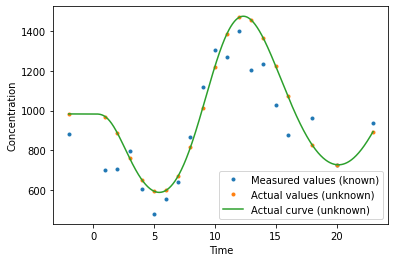

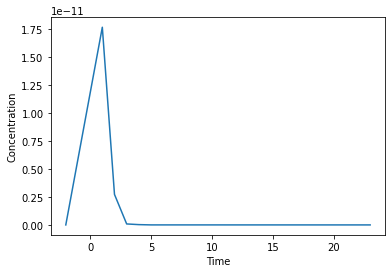

In [3]:
more_times = np.linspace(start_time, end_time, num_obs*10)
more_values = PD_result(dose, num_comp, np.concatenate((PK_params, np.asarray(PD_actual_params[:4]))), more_times)

# Visualise the data
plt.plot(df['TIME']/24, df['OBS'], '.', label='Measured values (known)')
plt.plot(data_times/24, values_no_noise, '.', label='Actual values (unknown)')
plt.plot(more_times/24, more_values, label='Actual curve (unknown)')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

plt.plot(data_times/24, conc_curve)
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show

np.save("./Data_and_parameters/pd_sim_actual_params_dose_"+str(dose), PD_actual_params)

In [5]:
# save the data for ease of use later
data_file = "./Data_and_parameters/pd_sim_data_dose_" + str(dose)
df.to_csv(data_file, index = False)

#### Initial Optimisation

Before performing bayesian inference, I used optimisation to find the parameters with the highest likelihood, given the data. This should give a good starting point for using bayesian inference.

In [6]:
# Create the model in PINTS 
dose = 2
PK_params=np.load('simulated_parameters_actual_dose'+str(dose)+'.npy')
df = pandas.read_csv("./Data_and_parameters/pd_sim_data_dose_" + str(dose))
pints_model_simulated = PintsPDFriberg(PK_params, dose, start_time=start_time)
print(df)

     TIME          OBS
0   -48.0   880.063612
1    24.0   701.805171
2    48.0   702.517047
3    72.0   793.468869
4    96.0   603.161821
5   120.0   477.752708
6   144.0   553.906644
7   168.0   638.049944
8   192.0   867.261726
9   216.0  1119.507128
10  240.0  1305.345233
11  264.0  1269.282600
12  288.0  1401.152017
13  312.0  1202.683779
14  336.0  1234.964947
15  360.0  1030.277957
16  384.0   876.858270
17  432.0   962.801962
18  480.0   724.780658
19  552.0   935.096790


Before starting the optimisation we can estimate the parameter Circ_0.

In [7]:
df_before_0 = df[df["TIME"] < 0]
Circ_0_approx = sum(df_before_0["OBS"])/times_before_dose
print("approximate Circ_0: ", Circ_0_approx)

approximate Circ_0:  880.063611968053


I also used 2 different error scores for the optimisation. Sum of squares error and the combined relative and constant gaussian noise log likelihood.

In [10]:
# Optimise the model with respect to the data
problem = pints.SingleOutputProblem(pints_model_simulated, df['TIME'].to_numpy()-start_time, df['OBS'].to_numpy())
error_measure = pints.SumOfSquaresError(problem)
lower_bound = [0.1, 0.1, 0.01, 0.001]
upper_bound = [10000, 1000, 100, 10]

point = np.exp((np.log(np.asarray(lower_bound)) + np.log(np.asarray(upper_bound)))/2)
point[0] = Circ_0_approx
unchanged_threshold = 1e-4

optimisation = pints.OptimisationController(error_measure, point, method=pints.CMAES, boundaries=pints.RectangularBoundaries(lower_bound, upper_bound))
optimisation.set_max_unchanged_iterations(threshold=unchanged_threshold)

optimisation.set_log_to_screen(True)

In [12]:
parametersadd, erroradd = optimisation.run()
actual_error = error_measure(PD_actual_params[:4])
parametersadd = (parametersadd, erroradd, actual_error)

np.save("./Data_and_parameters/pd_sim_opt_add_params_dose_"+str(dose), parametersadd)

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [15]:
# Optimise the model with respect to the data by maximising the Log Likelihood.
problem = pints.SingleOutputProblem(pints_model_simulated, df['TIME'].to_numpy()-start_time, df['OBS'].to_numpy())
log_likelihood = ConstantAndMultiplicativeGaussianLogLikelihood(problem)
error_measure = pints.ProbabilityBasedError(log_likelihood)
lower_bound = [1e-1, 1e0, 1e-3, 1e-3, 1e-4, 1e-2, 1e-4]
upper_bound = [1e4, 1e4, 1e1, 1e1, 1e2, 1e2, 1e2]

point = np.exp((np.log(np.asarray(lower_bound)) + np.log(np.asarray(upper_bound)))/2)
point[0] = Circ_0_approx
unchanged_threshold = 1e-4

optimisation = pints.OptimisationController(error_measure, point, method=pints.CMAES, boundaries=pints.RectangularBoundaries(lower_bound, upper_bound))
optimisation.set_max_unchanged_iterations(threshold=unchanged_threshold)

optimisation.set_log_to_screen(True)

In [17]:
parameterslike, errorlike = optimisation.run()
actual_error = error_measure(PD_actual_params)
parameterslike = (parameterslike, errorlike, actual_error)

np.save("./Data_and_parameters/pd_sim_opt_like_params_dose_"+str(dose), parameterslike)

##### Optimisation results

In [18]:
# Table of Parameters

dose = 2


parameter_names =['Circ_0', 'MTT', 'gamma', 'slope', 'sigma_base', 'eta', 'sigma_rel']

parametersadd = np.load("./Data_and_parameters/pd_sim_opt_like_params_dose_"+str(dose)+"_less_noise.npy", allow_pickle=True)
parameterslike = np.load("./Data_and_parameters/pd_sim_opt_like_params_dose_"+str(dose)+".npy", allow_pickle=True)
PD_actual_params = np.load("./Data_and_parameters/pd_sim_actual_params_dose_"+str(dose)+".npy")

print('\t\tLess Noise \t\tMore Noise \t\tReal')
print(parameter_names[0] + ': \t' + str(parametersadd[0][0]) + '\t' + str(parameterslike[0][0]) + '\t' + str(PD_actual_params[0]))
print(parameter_names[1] + ': \t\t' + str(parametersadd[0][1]) + '\t' + str(parameterslike[0][1]) + '\t' + str(PD_actual_params[1]))
print(parameter_names[2] + ': \t\t' + str(parametersadd[0][2]) + '\t' + str(parameterslike[0][2]) + '\t' + str(PD_actual_params[2]))
print(parameter_names[3] + ': \t\t' + str(parametersadd[0][3]) + '\t' + str(parameterslike[0][3]) + '\t' + str(PD_actual_params[3]))
print('Error: \t\t'+str(parametersadd[1])+'\t'+str(parameterslike[1]) +'\t'+str(error_measure(PD_actual_params)))

		Less Noise 		More Noise 		Real
Circ_0: 	5.500672865526565	936.4041449285212	983.1
MTT: 		65.08962670320871	74.95551440598818	85.26
gamma: 		0.17539734313126468	0.35710743805089484	0.44
slope: 		0.12484745015682397	0.01970205193717087	0.02
Error: 		-7.1470005085066655	117.78434213122726	126.2030827750135


In [20]:
# Lets Visualise using Plotly

data_file = "./Data_and_parameters/pd_sim_data_dose_" + str(dose)
df = pandas.read_csv(data_file)

more_times = np.linspace(start_time, end_time, num_obs*10)
more_values = PD_result(dose, num_comp, np.concatenate((PK_params, np.asarray(PD_actual_params[:4]))), more_times)

y_label = "Concentration"
x_label = "Time"

fig = px.scatter(
    df,
    title="Blood cell Concentration Mean",
    x="TIME",
    y="OBS",
    width=800, 
    height=500,
)

fig.update_xaxes(title_text=x_label)
fig.update_yaxes(title_text=y_label)
fig.update_traces(mode='markers+lines')
fig['data'][0]['showlegend']=True
fig['data'][0]['name']='Observed Values'
fig.add_trace(go.Scatter(x=more_times, y=pints_model_simulated.simulate(parametersadd[0][:4], more_times-start_time),
                    mode='lines',
                    name='Prediction - additive noise'))

fig.add_trace(go.Scatter(x=more_times, y=pints_model_simulated.simulate(parameterslike[0][:4], more_times-start_time),
                    mode='lines',
                    name='Prediction - combination noise'))

fig.add_trace(go.Scatter(x=more_times, y=more_values,
                    mode='lines',
                    name='Actual'))

fig.update_layout(
    updatemenus=[
        dict(
            type = "buttons",
            direction = "left",
            buttons=list([
                dict(
                    args=[{"yaxis.type": "linear"}],
                    label="Linear y-scale",
                    method="relayout"
                ),
                dict(
                    args=[{"yaxis.type": "log"}],
                    label="Log y-scale",
                    method="relayout"
                )
            ]),
            pad={"r": 0, "t": -10},
            showactive=True,
            x=1.0,
            xanchor="right",
            y=1.15,
            yanchor="top"
        ),
    ]
)
fig.show()

In [20]:
# num_points = 100
# P_0 = np.asarray(PD_actual_params)
# P_1 = parametersadd
# errors = []
# xs = np.linspace(0, 1, num_points)

# for x in xs:
#     point = x*P_0+(1-x)*P_1
#     errors.append(error_measure(point))
    
# plt.plot(xs, errors)
# plt.show()

This is a useful way of estimating the correct parameters and visualising how good the model and estimated parameters fit the data. However, it would also be useful to know how sure we are on these parameter values. To do this we use Bayesian inference and MCMC to sample the parameter space and give a distribution of probable parameter values.

In [23]:
log_prior = pints.UniformLogPrior(np.asarray(lower_bound)*0.8, np.asarray(upper_bound)*1.2)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)
num_iterations = (pints_model_simulated.n_parameters()+3)*3000

startpoints = [parameterslike[0], parameterslike[0]*0.8, parameterslike[0]*1.2]
mcmc = pints.MCMCController(log_posterior, 3, startpoints, method=pints.HaarioBardenetACMC)
mcmc.set_max_iterations(num_iterations)
# mcmc.set_log_to_screen(False)
samples = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.4
1     6      0         0         0          0:00.7
2     9      0         0         0          0:01.0
3     12     0         0         0          0:01.3
20    63     0         0.19      0.143      0:06.6
40    123    0.0244    0.22      0.0732     0:12.9
60    183    0.0328    0.197     0.0656     0:19.4
80    243    0.0494    0.148     0.0988     0:25.8
100   303    0.0396    0.139     0.0792     0:31.9
120   363    0.0413    0.132     0.0826     0:37.9
140   423    0.0355    0.121     0.078      0:43.9
160   483    0.0311    0.106     0.0745     0:49.6
180   543    0.0276    0.0939    0.0718     0:55.4
Initial phase completed.
200   603    0.0249    0.0846    0.0697     1:01.8
220   663    0.0769    0.118     0.104      1:08.3
240   723    0.108     0.145     0.141      1:14.9
260   783   

3100  9303   0.192841  0.2       0.203     15:21.8
3120  9363   0.193     0.2       0.203     15:27.7
3140  9423   0.193     0.201     0.20312   15:33.4
3160  9483   0.194     0.2       0.203     15:39.1
3180  9543   0.194     0.201     0.204     15:44.9
3200  9603   0.193     0.201     0.203     15:51.0
3220  9663   0.193     0.201     0.201     15:55.5
3240  9723   0.194     0.201     0.202     16:01.1
3260  9783   0.194     0.202     0.202     16:06.6
3280  9843   0.192929  0.202     0.203     16:11.0
3300  9903   0.194     0.204     0.204     16:16.2
3320  9963   0.194     0.204     0.203     16:21.9
3340  10023  0.195     0.204     0.203     16:27.4
3360  10083  0.195     0.205     0.202     16:33.0
3380  10143  0.194     0.204     0.203     16:38.5
3400  10203  0.195     0.203     0.205     16:43.3
3420  10263  0.193803  0.204     0.204     16:49.1
3440  10323  0.193839  0.204     0.204     16:54.4
3460  10383  0.195     0.205     0.204     16:59.3
3480  10443  0.195     0.205688

6320  18963  0.205     0.21215   0.21      30:17.5
6340  19023  0.205     0.212     0.209273  30:23.0
6360  19083  0.205     0.213     0.209     30:28.7
6380  19143  0.2042    0.212     0.21      30:32.6
6400  19203  0.204     0.211     0.209     30:36.1
6420  19263  0.204     0.211     0.209     30:41.0
6440  19323  0.205     0.211     0.209     30:46.6
6460  19383  0.205     0.211     0.209     30:52.4
6480  19443  0.205     0.211     0.209     30:58.1
6500  19503  0.206     0.211     0.209     31:03.9
6520  19563  0.20595   0.211     0.209     31:10.1
6540  19623  0.206     0.211     0.209     31:16.4
6560  19683  0.205     0.21      0.210029  31:22.6
6580  19743  0.205288  0.21      0.21      31:29.5
6600  19803  0.205     0.211     0.211     31:35.8
6620  19863  0.205256  0.211     0.21      31:41.2
6640  19923  0.205     0.21      0.21      31:47.3
6660  19983  0.205     0.21      0.21      31:53.4
6680  20043  0.206     0.21      0.21      31:59.1
6700  20103  0.206     0.209   

9540  28623  0.212     0.212     0.214     45:25.5
9560  28683  0.212     0.211     0.214     45:30.3
9580  28743  0.211982  0.211     0.214     45:35.5
9600  28803  0.212     0.211     0.214     45:39.8
9620  28863  0.212     0.210685  0.215     45:45.2
9640  28923  0.213     0.211     0.215     45:50.7
9660  28983  0.213     0.211     0.214     45:55.4
9680  29043  0.213     0.210722  0.214     46:00.9
9700  29103  0.213     0.21      0.214     46:06.0
9720  29163  0.212     0.211     0.214     46:11.3
9740  29223  0.212     0.211     0.214     46:15.9
9760  29283  0.212     0.211     0.214     46:21.3
9780  29343  0.212     0.211     0.214702  46:27.2
9800  29403  0.212     0.211     0.215     46:32.4
9820  29463  0.212     0.211     0.215     46:38.2
9840  29523  0.212     0.211     0.215     46:44.4
9860  29583  0.211439  0.211     0.215     46:50.0
9880  29643  0.211     0.211     0.215     46:54.9
9900  29703  0.212     0.212     0.215     46:59.9
9920  29763  0.211773  0.212   

12760 38283  0.217     0.219     0.219732  60:59.1
12780 38343  0.217     0.219     0.22      61:05.3
12800 38403  0.217     0.219     0.22      61:10.8
12820 38463  0.217     0.219     0.22      61:16.1
12840 38523  0.217     0.219     0.22      61:21.8
12860 38583  0.217     0.219112  0.221     61:27.9
12880 38643  0.217     0.219     0.220635  61:33.5
12900 38703  0.217     0.219     0.221     61:38.2
12920 38763  0.217     0.219     0.221     61:43.8
12940 38823  0.217     0.219303  0.22      61:49.2
12960 38883  0.217     0.219     0.22      61:54.3
12980 38943  0.217     0.219     0.221     61:59.7
13000 39003  0.217     0.219     0.221     62:06.2
13020 39063  0.217     0.219     0.22049   62:11.9
13040 39123  0.217698  0.219     0.221     62:17.3
13060 39183  0.218     0.219     0.221     62:22.8
13080 39243  0.218     0.219     0.22      62:28.0
13100 39303  0.217617  0.219     0.22      62:33.6
13120 39363  0.218     0.219     0.221     62:38.8
13140 39423  0.218     0.219   

15980 47943  0.222     0.221     0.223     76:33.1
16000 48003  0.222     0.221     0.223     76:38.7
16020 48063  0.222     0.221     0.223     76:44.2
16040 48123  0.222     0.221     0.223     76:48.9
16060 48183  0.222     0.221     0.223     76:54.6
16080 48243  0.222     0.221     0.222623  76:59.4
16100 48303  0.222     0.221     0.222     77:05.0
16120 48363  0.222     0.221     0.222     77:10.5
16140 48423  0.222     0.221     0.222     77:15.8
16160 48483  0.222     0.221     0.222511  77:21.8
16180 48543  0.222     0.221     0.223     77:26.9
16200 48603  0.222     0.221     0.223     77:32.7
16220 48663  0.222     0.222     0.223     77:38.2
16240 48723  0.222     0.222     0.223     77:43.6
16260 48783  0.222     0.222     0.223049  77:48.9
16280 48843  0.222     0.222     0.223     77:54.9
16300 48903  0.222     0.222     0.223     78:01.3
16320 48963  0.222     0.222     0.223     78:07.1
16340 49023  0.222     0.222     0.223     78:12.0
16360 49083  0.222     0.222   

19200 57603  0.223     0.222     0.225     90:48.2
19220 57663  0.223     0.222     0.225     90:53.2
19240 57723  0.222     0.222     0.225     90:58.0
19260 57783  0.222     0.222     0.224547  91:03.5
19280 57843  0.222     0.222     0.224729  91:09.3
19300 57903  0.222     0.222     0.225     91:14.7
19320 57963  0.222     0.222     0.225     91:19.9
19340 58023  0.222     0.222     0.225     91:25.3
19360 58083  0.223     0.222096  0.225     91:30.7
19380 58143  0.222     0.222     0.225     91:35.7
19400 58203  0.222     0.222     0.225     91:40.8
19420 58263  0.222     0.222     0.225     91:46.3
19440 58323  0.222     0.222     0.225     91:51.6
19460 58383  0.222     0.222     0.225     91:56.6
19480 58443  0.222     0.222     0.225     92:00.7
19500 58503  0.222     0.222     0.225     92:05.8
19520 58563  0.222     0.222     0.225     92:10.2
19540 58623  0.222     0.222     0.225     92:15.1
19560 58683  0.222     0.222279  0.225     92:21.0
19580 58743  0.222     0.222   

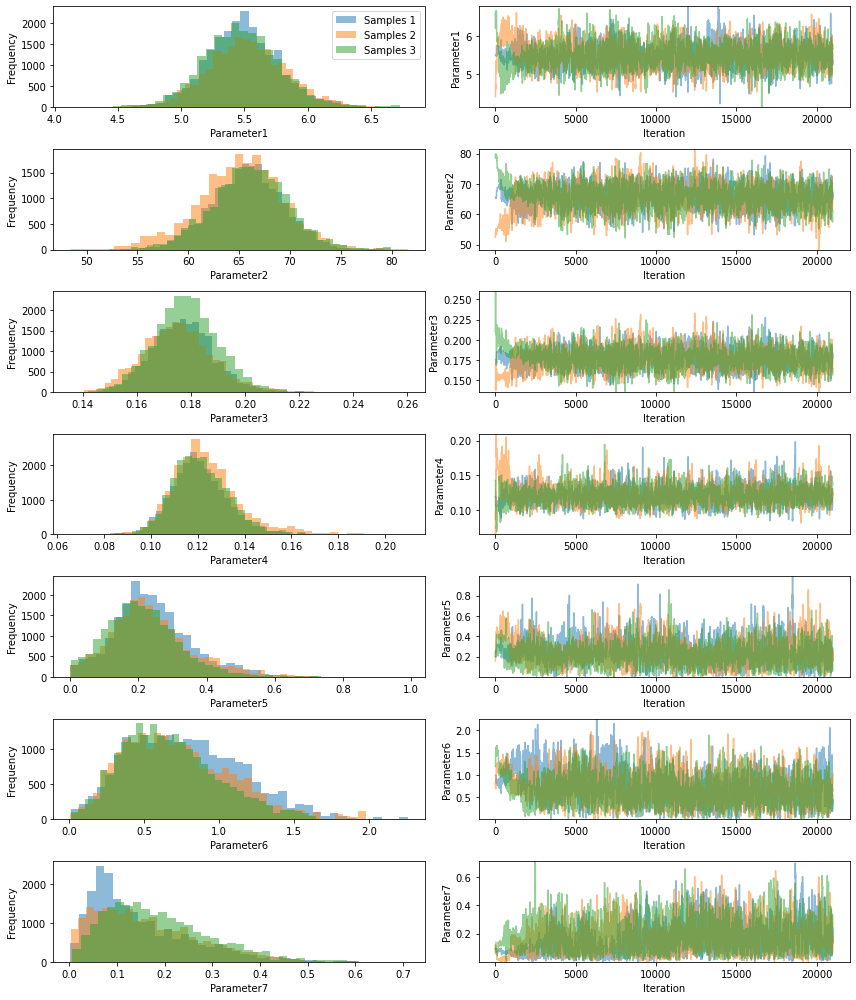

In [24]:
np.save("./Data_and_parameters/pd_sim_mcmc_comb_params_dose_"+str(dose), samples)
pints.plot.trace(samples)
plt.show()

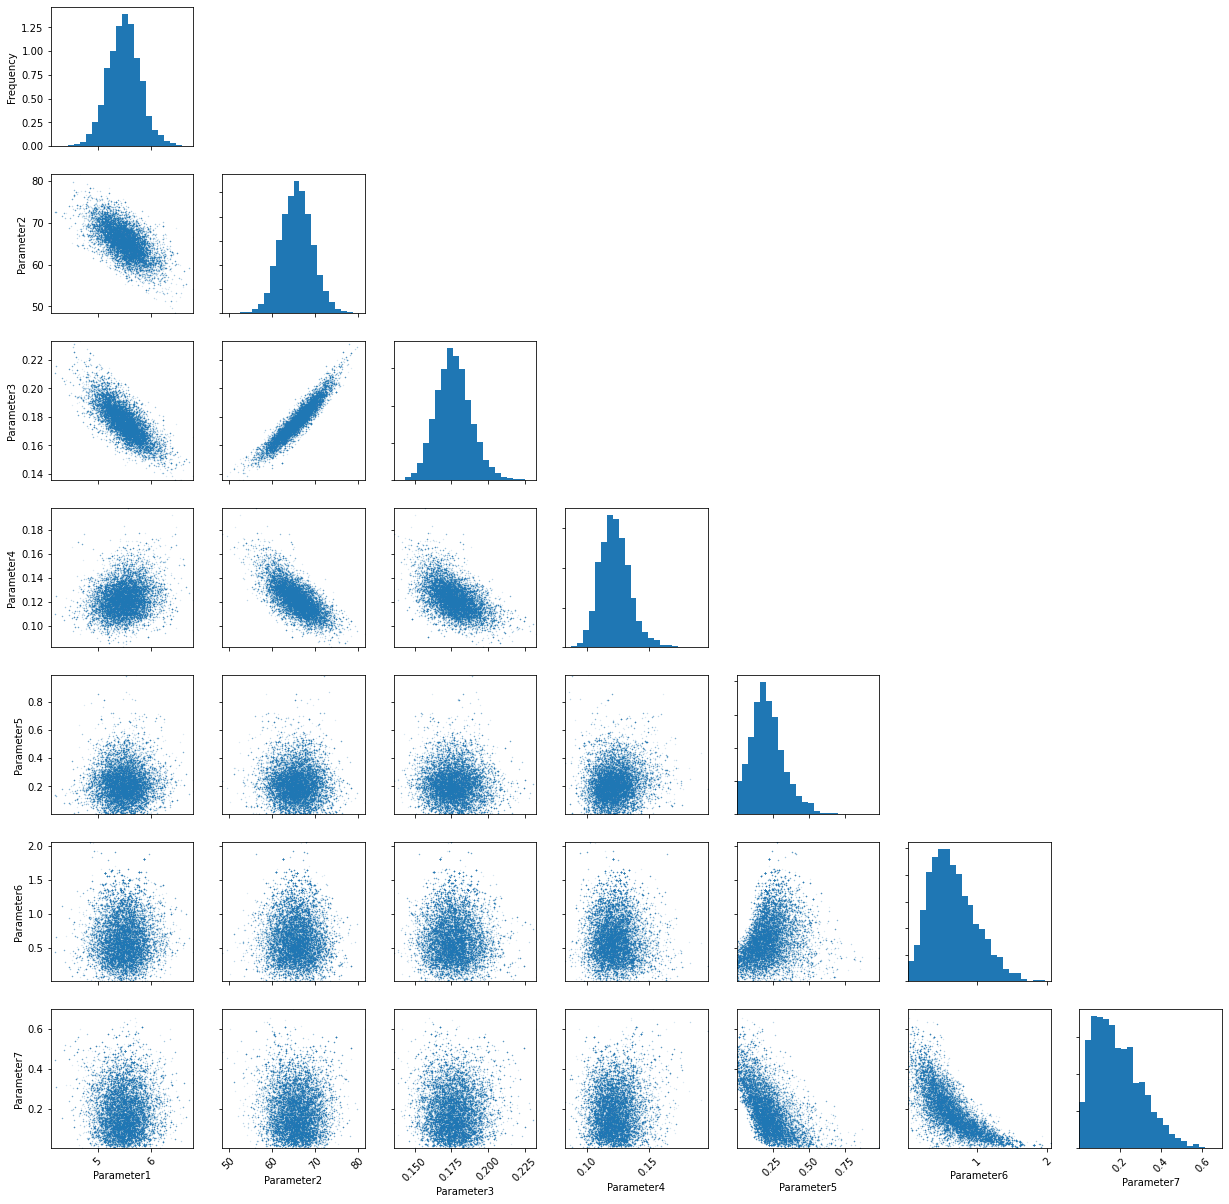

In [25]:
pints.plot.pairwise(np.vstack(samples[:,int(num_iterations/2):]))
plt.show()

#### K-Fold Validation: Simulated Data

For both the LOO and WAIC calculations a warning was given (LOO: Estimated shape parameter of Pareto distribution is greater than 0.7; WAIC: For one or more samples the posterior variance of the log predictive densities exceeds 0.4). This is likely due to one or more of the observations being highly influential in the fit. Thus, to confirm the results of the model comparison, I will use a more computationally intensive method, K-fold validation, that will be less impacted by these influential points.

We start this process by splitting up the data into $K$ subsets, $X^{Obs}_k$.

In [21]:
# Options
drug = 'Simulated Drug'
dose = 2

# Retrieve the parameters for the conc-time curve
num_comp = int(len(PK_params)/2)  # If this has a linear PK model

K = 4
model_type = "multNoEta" # choose from: "combNoEta", "add" or "multNoEta"

# Split into the K subsets
df= pandas.read_csv("./Data_and_parameters/pd_sim_data_dose_" + str(dose))
df_shuffled = df.sample(frac=1)
data_k = np.array_split(df_shuffled, K)
np.save("./Data_and_parameters/pd_sim_mcmc_"+model_type+"_datak_dose_"+str(dose)+"K_fold", data_k)
# data_k = np.load("./Data_and_parameters/pd_sim_mcmc_"+model_type+"_datak_dose_"+str(dose)+"K_fold2.npy")
# data_k = [pandas.DataFrame(data=data_k[0], columns=['TIME','OBS']), pandas.DataFrame(data=data_k[1], columns=['TIME','OBS']), pandas.DataFrame(data=data_k[2], columns=['TIME','OBS']), pandas.DataFrame(data=data_k[3], columns=['TIME','OBS'])]

Then the model needs to be fit to each set $X^{obs}_{-k} = \cup_{j \neq k} X^{obs}_j $ thus providing the posterior distribution, $P(\theta | X^{obs}_{-k})$.

In [22]:
# Get the data_-k for fitting
data_minus_k = [None]*K
for i in range(0, K):
    data = data_k[:i] + data_k[i+1:]
    data_minus_k[i] = pandas.concat(data)
    data_minus_k[i] = data_minus_k[i].sort_values(['TIME'], ascending=True)

In [26]:
# Set up details of the MCMC run
PK_params=np.load('simulated_parameters_actual_dose'+str(dose)+'.npy')
start_time = df['TIME'].min()

pints_model_real = PintsPDFriberg(PK_params, dose, num_comp=num_comp, start_time=start_time)

df_before_0 = df[df["TIME"] < 0]
times_before_dose = len(df_before_0["OBS"])
Circ_0_approx = sum(df_before_0["OBS"])/times_before_dose
parameter_names =['Circ_0', 'MTT', 'gamma', 'slope', 'sigma_base', 'sigma_rel']

lower_bound = [1e0, 1e0, 1e-3, 1e-3, 1e-4, 1e-2, 1e-4]
upper_bound = [1e4, 1e4, 1e1, 1e1, 1e2, 1e2, 1e2]
log_posterior = [None]*K
num_iterations = (pints_model_real.n_parameters()+3)*3000
parameters = np.load("./Data_and_parameters/pd_sim_opt_like_params_dose_"+str(dose)+".npy", allow_pickle=True)[0]

In [27]:
# Create the problem and log posteriors in Pints
for k in range(0, K):
    problem = pints.SingleOutputProblem(pints_model_real, np.asarray(data_minus_k[k]['TIME'])-start_time, data_minus_k[k]['OBS'])
    if model_type == "add":
        log_likelihood = GaussianLogLikelihood(problem)
        log_prior = pints.UniformLogPrior(np.asarray(lower_bound)[:-2]*0.8, np.asarray(upper_bound)[:-2]*1.2)
        startpoints = [np.asarray(parameters)[:-2], np.asarray(parameters)[:-2]*0.8, np.asarray(parameters)[:-2]*1.2]
    elif model_type == "multNoEta":
        log_likelihood = MultiplicativeGaussianLogLikelihood(problem, fix_eta=1)
        log_prior = pints.UniformLogPrior(np.asarray(lower_bound)[:-2]*0.8, np.asarray(upper_bound)[:-2]*1.2)
        startpoints = [np.asarray(parameters)[:-2], np.asarray(parameters)[:-2]*0.8, np.asarray(parameters)[:-2]*1.2]
    elif model_type == "combNoEta":
        log_likelihood = ConstantAndMultiplicativeGaussianLogLikelihood(problem, fix_eta=1)
        log_prior = pints.UniformLogPrior(np.asarray(lower_bound)[:-1]*0.8, np.asarray(upper_bound)[:-1]*1.2)
        startpoints = [np.asarray(parameters)[:-1], np.asarray(parameters)[:-1]*0.8, np.asarray(parameters)[:-1]*1.2]
    log_posterior[k] = pints.LogPosterior(log_likelihood, log_prior)

In [28]:
# run MCMC on the log posteriors
for k in range(0, K):
    mcmc = pints.MCMCController(log_posterior[k], 3, startpoints, method=pints.HaarioBardenetACMC)
    mcmc.set_max_iterations(num_iterations)
    mcmc.set_log_to_screen(True)
    samples = mcmc.run()
    np.save("./Data_and_parameters/pd_sim_mcmc_"+model_type+"_params_dose_"+str(dose)+"K_fold"+str(k), samples)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.3
1     6      0.5       0.5       0.5        0:00.6
2     9      0.667     0.333     0.333      0:00.8
3     12     0.75      0.5       0.5        0:01.1
20    63     0.714     0.619     0.571      0:05.6
40    123    0.659     0.415     0.366      0:09.6
60    183    0.492     0.311     0.262      0:12.9
80    243    0.407     0.259     0.21       0:17.2
100   303    0.337     0.228     0.178      0:20.3
120   363    0.298     0.19      0.157      0:23.7
140   423    0.27      0.17      0.135      0:27.6
160   483    0.242236  0.168     0.143      0:32.5
180   543    0.227     0.155     0.144      0:36.5
Initial phase completed.
200   603    0.209     0.139     0.129      0:39.5
220   663    0.217     0.158371  0.145      0:44.7
240   723    0.245     0.203     0.178      0:50.8
260   783   

3100  9303   0.223     0.215     0.234     12:29.9
3120  9363   0.222685  0.215636  0.235     12:35.3
3140  9423   0.222859  0.217     0.234     12:40.7
3160  9483   0.223     0.217     0.233     12:46.2
3180  9543   0.222     0.217     0.233     12:51.9
3200  9603   0.222     0.218     0.232     12:57.2
3220  9663   0.221     0.217     0.232     13:02.4
3240  9723   0.222     0.217     0.232     13:07.1
3260  9783   0.221     0.217418  0.231     13:12.4
3280  9843   0.221274  0.218     0.23      13:17.6
3300  9903   0.222     0.216904  0.228     13:22.5
3320  9963   0.221     0.218     0.22704   13:27.2
3340  10023  0.221     0.218     0.226     13:31.9
3360  10083  0.221     0.219     0.226     13:37.5
3380  10143  0.222     0.219     0.225     13:43.1
3400  10203  0.221     0.219     0.224     13:48.6
3420  10263  0.223     0.218     0.224     13:54.1
3440  10323  0.222     0.217     0.224     13:59.6
3460  10383  0.223     0.216     0.223     14:05.1
3480  10443  0.223499  0.216   

6320  18963  0.22623   0.224     0.229     27:13.6
6340  19023  0.226     0.224     0.228986  27:19.1
6360  19083  0.226     0.224     0.229052  27:24.7
6380  19143  0.226     0.224     0.23      27:30.4
6400  19203  0.226     0.224     0.229     27:35.9
6420  19263  0.226756  0.224     0.23      27:41.4
6440  19323  0.227     0.224344  0.231     27:47.1
6460  19383  0.227     0.224     0.231     27:52.9
6480  19443  0.226     0.224     0.23      27:58.6
6500  19503  0.227     0.225     0.231     28:04.4
6520  19563  0.227     0.225     0.23      28:10.1
6540  19623  0.227     0.225     0.23      28:15.6
6560  19683  0.227     0.225     0.23      28:21.2
6580  19743  0.227     0.224434  0.23      28:26.7
6600  19803  0.227     0.224     0.229     28:32.1
6620  19863  0.227     0.224     0.229     28:37.8
6640  19923  0.227     0.225     0.229     28:43.5
6660  19983  0.226     0.224     0.229     28:49.0
6680  20043  0.226     0.225     0.229     28:54.4
6700  20103  0.225     0.225   

9540  28623  0.227     0.223247  0.228802  42:01.3
9560  28683  0.227     0.223303  0.229     42:06.6
9580  28743  0.228     0.223985  0.229     42:12.1
9600  28803  0.228     0.224     0.23      42:17.6
9620  28863  0.228     0.225     0.23      42:23.1
9640  28923  0.228     0.225     0.23      42:28.7
9660  28983  0.228     0.225     0.23      42:34.2
9680  29043  0.228     0.225     0.23      42:39.6
9700  29103  0.228     0.225     0.23      42:44.9
9720  29163  0.228     0.225     0.23      42:50.3
9740  29223  0.228     0.225     0.23      42:55.7
9760  29283  0.227     0.225     0.229792  43:01.1
9780  29343  0.227     0.225     0.23      43:06.5
9800  29403  0.227     0.226     0.23      43:11.9
9820  29463  0.227     0.226     0.229     43:17.4
9840  29523  0.227     0.226     0.23      43:22.8
9860  29583  0.227     0.226     0.23      43:28.2
9880  29643  0.227     0.226     0.229     43:33.6
9900  29703  0.227     0.226     0.229     43:39.1
9920  29763  0.227     0.226   

12760 38283  0.225766  0.225766  0.233     56:33.6
12780 38343  0.226     0.226     0.233     56:39.1
12800 38403  0.225998  0.226     0.234     56:44.4
12820 38463  0.226     0.226     0.234     56:49.7
12840 38523  0.22654   0.226     0.234     56:55.0
12860 38583  0.226732  0.227     0.234     57:00.4
12880 38643  0.227     0.226     0.234     57:05.8
12900 38703  0.227     0.226184  0.234     57:11.3
12920 38763  0.227     0.226     0.234     57:16.9
12940 38823  0.227     0.226     0.234     57:22.3
12960 38883  0.22668   0.226     0.234     57:27.7
12980 38943  0.227     0.226     0.234     57:33.2
13000 39003  0.227     0.226521  0.234     57:38.7
13020 39063  0.227     0.226     0.234     57:44.1
13040 39123  0.227     0.227     0.234     57:49.5
13060 39183  0.227     0.226782  0.234     57:55.0
13080 39243  0.227582  0.227     0.234     58:00.3
13100 39303  0.228     0.227     0.234     58:05.7
13120 39363  0.227     0.227     0.234     58:11.2
13140 39423  0.227     0.22738 

15980 47943  0.231     0.229     0.231     70:54.7
16000 48003  0.231     0.228     0.23      71:00.1
16020 48063  0.231     0.228     0.23      71:05.5
16040 48123  0.232     0.22829   0.23      71:10.9
16060 48183  0.231     0.228     0.23      71:16.2
16080 48243  0.231     0.228     0.23      71:21.7
16100 48303  0.231     0.228     0.23      71:27.0
16120 48363  0.231     0.228894  0.231     71:32.5
16140 48423  0.231     0.229168  0.231     71:37.8
16160 48483  0.231     0.229     0.231     71:43.2
16180 48543  0.231     0.229     0.231     71:48.5
16200 48603  0.231     0.229     0.231     71:53.9
16220 48663  0.231     0.228     0.230627  71:59.2
16240 48723  0.231     0.228     0.230774  72:04.4
16260 48783  0.231     0.228     0.231     72:09.7
16280 48843  0.231     0.228     0.231     72:15.1
16300 48903  0.231     0.228     0.231     72:20.5
16320 48963  0.231     0.228     0.231     72:25.9
16340 49023  0.232     0.228     0.231     72:31.3
16360 49083  0.231     0.228   

19200 57603  0.227     0.227     0.23      85:19.6
19220 57663  0.227     0.227     0.23      85:25.3
19240 57723  0.227     0.227     0.23      85:30.7
19260 57783  0.227     0.227     0.23      85:36.1
19280 57843  0.227     0.227     0.23      85:41.6
19300 57903  0.227     0.227     0.23      85:47.3
19320 57963  0.227     0.227     0.229543  85:52.8
19340 58023  0.227     0.227     0.229409  85:58.2
19360 58083  0.227     0.227     0.23      86:03.8
19380 58143  0.227     0.226     0.229     86:09.3
19400 58203  0.227     0.226     0.229     86:14.9
19420 58263  0.227     0.226     0.229     86:20.3
19440 58323  0.228     0.226     0.229     86:25.6
19460 58383  0.228     0.226     0.229     86:30.9
19480 58443  0.227863  0.226     0.229     86:36.4
19500 58503  0.228     0.226     0.229     86:41.9
19520 58563  0.228     0.226     0.229     86:47.4
19540 58623  0.228     0.226     0.229     86:52.8
19560 58683  0.228     0.226     0.228976  86:58.3
19580 58743  0.228     0.227   

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/model_simulation.ipynb:150: RuntimeWarning:

invalid value encountered in power



520   1563   0.217     0.242     0.255      2:01.4
540   1623   0.214     0.235     0.245841   2:05.7
560   1683   0.207     0.232     0.239      2:09.7
580   1743   0.201     0.227     0.232358   2:13.5
600   1803   0.195     0.223     0.226      2:16.6
620   1863   0.188     0.219     0.221      2:20.3
640   1923   0.183     0.218     0.217      2:24.3
660   1983   0.177     0.219     0.213      2:28.8
680   2043   0.172     0.215859  0.207      2:32.3
700   2103   0.167     0.217     0.203      2:35.8
720   2163   0.166     0.218     0.197      2:39.6
740   2223   0.162     0.219     0.193      2:42.7
760   2283   0.158     0.216     0.191      2:45.7
780   2343   0.15621   0.212548  0.187      2:48.2
800   2403   0.156     0.211     0.19       2:51.5
820   2463   0.153     0.207     0.19       2:55.7
840   2523   0.15      0.202     0.187      2:58.7
860   2583   0.152     0.2       0.189      3:01.7
880   2643   0.15437   0.199     0.188      3:04.9
900   2703   0.156     0.201   

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.



1800  5403   0.227     0.17      0.178      6:04.1
1820  5463   0.227     0.171     0.178      6:08.2
1840  5523   0.228     0.171     0.178      6:13.1
1860  5583   0.228     0.174     0.175712   6:16.8
1880  5643   0.229     0.174     0.174      6:22.6
1900  5703   0.227     0.179     0.173      6:27.1
1920  5763   0.226     0.182     0.171      6:31.3
1940  5823   0.229     0.186     0.171      6:35.3
1960  5883   0.229     0.188     0.169      6:39.8
1980  5943   0.229682  0.187     0.172      6:44.8
2000  6003   0.23      0.186     0.17       6:49.0
2020  6063   0.232     0.189     0.172      6:53.8
2040  6123   0.232     0.19      0.171      6:57.2
2060  6183   0.23      0.192     0.175      7:02.2
2080  6243   0.229     0.194618  0.179      7:07.3
2100  6303   0.228     0.196     0.18       7:11.8
2120  6363   0.228     0.198     0.181      7:16.1
2140  6423   0.227     0.2       0.182      7:20.7
2160  6483   0.227     0.203     0.184      7:28.3
2180  6543   0.228     0.203   

5020  15063  0.163     0.219     0.214     28:33.6
5040  15123  0.163     0.219     0.21464   28:41.4
5060  15183  0.164     0.22      0.215     28:49.3
5080  15243  0.165     0.22      0.215     28:57.3
5100  15303  0.164     0.22      0.217     29:05.0
5120  15363  0.164421  0.219     0.217     29:12.7
5140  15423  0.164     0.219     0.217     29:20.6
5160  15483  0.164     0.22      0.217     29:28.3
5180  15543  0.163     0.22      0.217     29:36.3
5200  15603  0.162661  0.221     0.216     29:44.2
5220  15663  0.162     0.221     0.216     29:52.1
5240  15723  0.163     0.222     0.215     29:59.9
5260  15783  0.164     0.223     0.215     30:07.8
5280  15843  0.164     0.223     0.216     30:15.8
5300  15903  0.164     0.224     0.215997  30:23.8
5320  15963  0.163691  0.224206  0.217     30:31.6
5340  16023  0.164     0.224     0.218     30:39.5
5360  16083  0.165     0.224     0.217     30:47.3
5380  16143  0.164     0.224     0.218     30:55.2
5400  16203  0.164     0.223   

8240  24723  0.181     0.227885  0.22      49:33.3
8260  24783  0.181     0.228     0.22      49:41.4
8280  24843  0.181     0.227     0.22      49:49.5
8300  24903  0.182     0.228     0.22      49:57.5
8320  24963  0.182     0.228     0.221     50:05.6
8340  25023  0.182     0.228     0.22      50:13.4
8360  25083  0.182     0.228     0.220189  50:21.2
8380  25143  0.182     0.228     0.22      50:29.2
8400  25203  0.183     0.228     0.22      50:37.0
8420  25263  0.183     0.228     0.22      50:44.9
8440  25323  0.183     0.228     0.22      50:53.0
8460  25383  0.183548  0.227869  0.22      51:01.0
8480  25443  0.183     0.228     0.22      51:09.2
8500  25503  0.182802  0.228     0.22      51:17.2
8520  25563  0.182     0.227     0.221     51:25.0
8540  25623  0.182     0.228     0.221     51:32.3
8560  25683  0.182     0.228     0.221     51:40.3
8580  25743  0.181     0.228     0.221     51:48.3
8600  25803  0.181     0.228     0.221     51:56.1
8620  25863  0.18      0.228   

11460 34383  0.224675  0.229     0.22      69:33.2
11480 34443  0.224632  0.229     0.220277  69:46.5
11500 34503  0.225     0.229     0.22      69:58.8
11520 34563  0.225     0.229     0.22      70:08.6
11540 34623  0.225     0.229     0.22      70:18.4
11560 34683  0.225     0.229     0.22      70:25.7
11580 34743  0.225     0.229     0.22      70:36.3
11600 34803  0.225     0.229     0.221     70:52.2
11620 34863  0.225     0.228896  0.221     71:06.2
11640 34923  0.225     0.229     0.221     71:15.0
11660 34983  0.225     0.228     0.222     71:25.6
11680 35043  0.225     0.228     0.222     71:32.8
11700 35103  0.225     0.229     0.222     71:46.0
11720 35163  0.225     0.229     0.222     71:56.6
11740 35223  0.226     0.229     0.222     72:04.6
11760 35283  0.226     0.229     0.221     72:11.9
11780 35343  0.226     0.229     0.221628  72:19.1
11800 35403  0.227     0.229     0.222     72:26.3
11820 35463  0.227     0.229     0.222     72:33.5
11840 35523  0.227     0.229   

14680 44043  0.226     0.231     0.233     92:26.5
14700 44103  0.225     0.231     0.233     92:39.4
14720 44163  0.225     0.231     0.233     92:52.0
14740 44223  0.224883  0.231     0.233     93:06.9
14760 44283  0.225     0.231     0.232911  93:24.4
14780 44343  0.224     0.231     0.233     93:38.1
14800 44403  0.224174  0.231133  0.233     93:52.9
14820 44463  0.224     0.231091  0.232     94:01.8
14840 44523  0.225     0.231     0.232     94:08.9
14860 44583  0.225     0.231     0.232     94:20.0
14880 44643  0.225     0.231     0.232     94:27.0
14900 44703  0.22475   0.231     0.232065  94:34.0
14920 44763  0.225     0.231     0.232156  94:43.5
14940 44823  0.225     0.231     0.233     94:55.7
14960 44883  0.225     0.231     0.232     95:06.8
14980 44943  0.225     0.231     0.233     95:18.1
15000 45003  0.225     0.231     0.233     95:30.0
15020 45063  0.225     0.232     0.232874  95:38.9
15040 45123  0.224     0.2317    0.233     95:49.6
15060 45183  0.224     0.232   

17900 53703  0.2       0.228423  0.234    113:27.7
17920 53763  0.199     0.228     0.234    113:35.0
17940 53823  0.19932   0.228     0.234    113:42.2
17960 53883  0.199     0.227994  0.234    113:49.4
17980 53943  0.199     0.227796  0.234    113:56.6
18000 54003  0.199     0.228     0.234    114:03.8
18020 54063  0.199     0.228     0.234    114:11.0
18040 54123  0.199     0.228     0.234    114:18.3
18060 54183  0.199     0.228     0.234    114:25.5
18080 54243  0.199     0.227587  0.234    114:32.8
18100 54303  0.198     0.228     0.234    114:40.1
18120 54363  0.199     0.228     0.234    114:47.4
18140 54423  0.198     0.228047  0.235    114:54.7
18160 54483  0.198     0.228     0.235    115:01.9
18180 54543  0.199     0.228     0.235    115:09.2
18200 54603  0.198     0.228394  0.235042 115:16.5
18220 54663  0.198     0.229     0.235    115:23.7
18240 54723  0.198     0.22888   0.23502  115:30.9
18260 54783  0.198     0.229     0.235    115:38.1
18280 54843  0.198     0.229   

2     9      0.333     0.667     0.333      0:00.7
3     12     0.5       0.75      0.5        0:01.0
20    63     0.714     0.619     0.476      0:05.9
40    123    0.537     0.366     0.293      0:10.1
60    183    0.393     0.311     0.262      0:14.2
80    243    0.345679  0.259     0.259      0:18.5
100   303    0.297     0.218     0.248      0:21.9
120   363    0.273     0.182     0.223      0:25.7
140   423    0.255     0.156     0.22       0:29.2
160   483    0.224     0.155     0.23       0:33.1
180   543    0.204     0.144     0.232      0:37.1
Initial phase completed.
200   603    0.209     0.134     0.224      0:41.0
220   663    0.213     0.149     0.244      0:46.0
240   723    0.249     0.186722  0.266      0:51.9
260   783    0.28      0.207     0.28       0:57.3
280   843    0.292     0.217     0.281      1:02.3
300   903    0.286     0.226     0.276      1:06.2
320   963    0.293     0.24      0.28       1:10.8
340   1023   0.299     0.24      0.28739    1:16.1
360   

3200  9603   0.217     0.167     0.227     12:50.4
3220  9663   0.219     0.168     0.228     12:57.8
3240  9723   0.219     0.168     0.227     13:05.3
3260  9783   0.219     0.167     0.228     13:12.3
3280  9843   0.22      0.166     0.227     13:19.3
3300  9903   0.221     0.166     0.228     13:26.3
3320  9963   0.221     0.165     0.227     13:33.3
3340  10023  0.221     0.165     0.227     13:40.3
3360  10083  0.221     0.164     0.227     13:47.3
3380  10143  0.222     0.165     0.228039  13:54.4
3400  10203  0.222     0.165     0.228     14:01.4
3420  10263  0.223     0.164     0.229     14:08.2
3440  10323  0.223     0.166     0.228     14:15.2
3460  10383  0.224     0.165     0.229     14:22.2
3480  10443  0.224     0.165     0.229     14:29.2
3500  10503  0.225     0.164     0.23      14:36.2
3520  10563  0.226     0.164     0.229     14:43.1
3540  10623  0.226     0.164     0.229     14:50.0
3560  10683  0.226     0.163     0.228     14:56.9
3580  10743  0.227     0.162   

6420  19263  0.225     0.164     0.23      31:39.6
6440  19323  0.225     0.164105  0.229778  31:46.6
6460  19383  0.224     0.164     0.23      31:53.7
6480  19443  0.225     0.164     0.23      32:00.7
6500  19503  0.225     0.164     0.23      32:07.9
6520  19563  0.225     0.164     0.23      32:15.0
6540  19623  0.226     0.165     0.229     32:22.1
6560  19683  0.226     0.165     0.229     32:29.2
6580  19743  0.225     0.164     0.229     32:36.2
6600  19803  0.225     0.165     0.229     32:43.2
6620  19863  0.225     0.164     0.228     32:50.2
6640  19923  0.226     0.164     0.228     32:57.2
6660  19983  0.226     0.164     0.228194  33:04.2
6680  20043  0.226     0.164197  0.228     33:11.2
6700  20103  0.226     0.164     0.228     33:18.2
6720  20163  0.226     0.165     0.228835  33:25.3
6740  20223  0.227     0.165     0.229     33:32.2
6760  20283  0.22615   0.164     0.229     33:39.2
6780  20343  0.226     0.164     0.229     33:46.2
6800  20403  0.226     0.164   

9640  28923  0.23      0.17      0.226     50:29.4
9660  28983  0.23      0.171     0.226     50:36.4
9680  29043  0.23      0.171     0.226113  50:43.3
9700  29103  0.231     0.170601  0.226     50:50.4
9720  29163  0.231     0.171     0.226     50:57.4
9740  29223  0.231     0.171     0.226     51:04.3
9760  29283  0.231     0.171089  0.226     51:11.4
9780  29343  0.232     0.171     0.225846  51:18.3
9800  29403  0.232     0.17      0.226     51:25.2
9820  29463  0.232     0.17      0.227     51:32.2
9840  29523  0.232     0.171     0.227     51:39.1
9860  29583  0.231     0.171     0.227     51:46.1
9880  29643  0.231     0.171     0.227     51:53.1
9900  29703  0.231     0.171     0.227     52:00.1
9920  29763  0.231     0.171     0.227094  52:07.0
9940  29823  0.232     0.171     0.227     52:14.0
9960  29883  0.231     0.171     0.228     52:20.9
9980  29943  0.231     0.172     0.228     52:27.9
10000 30003  0.231     0.171     0.228     52:34.8
10020 30063  0.231     0.17144 

12860 38583  0.23      0.189     0.23      68:59.3
12880 38643  0.23      0.189     0.23      69:06.2
12900 38703  0.23      0.189     0.23      69:13.0
12920 38763  0.23      0.19      0.229394  69:19.9
12940 38823  0.229735  0.189     0.229     69:26.8
12960 38883  0.23      0.189     0.229     69:33.7
12980 38943  0.23      0.19      0.23      69:40.5
13000 39003  0.231     0.19      0.229     69:47.3
13020 39063  0.231     0.19      0.229     69:54.2
13040 39123  0.231424  0.19      0.229     70:01.1
13060 39183  0.231     0.19      0.229     70:07.9
13080 39243  0.231     0.19      0.228958  70:14.9
13100 39303  0.231     0.19      0.229     70:21.7
13120 39363  0.231     0.191     0.229327  70:28.6
13140 39423  0.231     0.190777  0.229     70:35.5
13160 39483  0.231     0.191     0.229     70:42.4
13180 39543  0.231     0.191     0.229     70:49.3
13200 39603  0.231     0.192     0.229     70:56.2
13220 39663  0.231     0.192     0.229559  71:03.1
13240 39723  0.231     0.192   

16080 48243  0.23      0.196     0.229028  87:28.6
16100 48303  0.23      0.196     0.229     87:35.6
16120 48363  0.23      0.196     0.228956  87:42.6
16140 48423  0.23      0.196     0.229     87:49.6
16160 48483  0.229     0.196     0.229     87:56.5
16180 48543  0.229     0.196     0.229     88:03.5
16200 48603  0.229492  0.196099  0.229     88:10.5
16220 48663  0.23      0.196     0.229     88:17.6
16240 48723  0.23      0.196     0.229     88:24.6
16260 48783  0.23      0.196     0.229     88:31.5
16280 48843  0.23      0.196     0.229     88:38.4
16300 48903  0.23      0.196     0.229     88:45.4
16320 48963  0.229459  0.196     0.229     88:52.4
16340 49023  0.229     0.196     0.229     88:59.4
16360 49083  0.229387  0.197     0.229     89:06.3
16380 49143  0.229229  0.197     0.23      89:13.1
16400 49203  0.229     0.196     0.229     89:20.0
16420 49263  0.229     0.197     0.229     89:27.0
16440 49323  0.228879  0.197     0.229     89:33.9
16460 49383  0.229     0.197   

19300 57903  0.231     0.2       0.23     106:16.3
19320 57963  0.231     0.2       0.23     106:23.4
19340 58023  0.231     0.2       0.23     106:30.4
19360 58083  0.231     0.199938  0.23     106:37.4
19380 58143  0.230793  0.2       0.23     106:44.5
19400 58203  0.231     0.2       0.23     106:51.6
19420 58263  0.231     0.2       0.23     106:58.7
19440 58323  0.231     0.199     0.23     107:05.7
19460 58383  0.231     0.199     0.230204 107:12.6
19480 58443  0.231     0.199     0.23     107:19.6
19500 58503  0.23      0.199     0.23     107:26.5
19520 58563  0.23      0.2       0.23     107:33.4
19540 58623  0.23      0.2       0.23     107:40.4
19560 58683  0.230203  0.2       0.23     107:47.4
19580 58743  0.23      0.2       0.23     107:54.6
19600 58803  0.23      0.2       0.231    108:01.6
19620 58863  0.23      0.2       0.231    108:08.6
19640 58923  0.23      0.2       0.23064  108:15.7
19660 58983  0.23      0.2       0.231    108:22.8
19680 59043  0.23      0.2     

1360  4083   0.215     0.187     0.201      4:40.6
1380  4143   0.214     0.186097  0.204      4:46.5
1400  4203   0.215     0.186     0.205      4:50.6
1420  4263   0.217     0.187     0.203      4:54.8
1440  4323   0.219     0.189     0.201      4:59.0
1460  4383   0.218     0.19      0.199      5:03.0
1480  4443   0.219     0.189     0.199865   5:05.8
1500  4503   0.217     0.188541  0.202      5:09.4
1520  4563   0.218     0.190664  0.202      5:14.3
1540  4623   0.217     0.193     0.203      5:19.7
1560  4683   0.217     0.197     0.202      5:24.6
1580  4743   0.214     0.197976  0.203      5:29.1
1600  4803   0.213     0.197     0.201      5:32.9
1620  4863   0.215     0.197409  0.2        5:37.1
1640  4923   0.218     0.19805   0.202925   5:41.6
1660  4983   0.217     0.199     0.201      5:45.2
1680  5043   0.218     0.199     0.202      5:49.6
1700  5103   0.219     0.199     0.202      5:53.8
1720  5163   0.22      0.196     0.204      5:57.3
1740  5223   0.219     0.194   

4580  13743  0.218     0.202     0.192971  14:03.6
4600  13803  0.217     0.202782  0.192     14:06.7
4620  13863  0.218     0.203     0.191     14:09.9
4640  13923  0.218     0.205     0.191     14:13.5
4660  13983  0.218     0.206     0.190088  14:16.5
4680  14043  0.218543  0.206     0.189     14:19.4
4700  14103  0.217826  0.20719   0.188     14:22.2
4720  14163  0.218     0.209     0.188     14:25.5
4740  14223  0.217     0.209     0.187935  14:28.4
4760  14283  0.218     0.209     0.188     14:31.8
4780  14343  0.218     0.21      0.187     14:35.0
4800  14403  0.219     0.211     0.186     14:38.1
4820  14463  0.219     0.211     0.186061  14:41.5
4840  14523  0.218     0.21      0.186     14:44.7
4860  14583  0.218     0.211     0.186     14:47.7
4880  14643  0.218     0.212     0.185     14:51.0
4900  14703  0.217     0.212     0.185     14:54.1
4920  14763  0.217     0.212152  0.185     14:57.2
4940  14823  0.216353  0.213     0.185     15:00.3
4960  14883  0.216287  0.214   

7800  23403  0.219     0.233     0.227     22:40.7
7820  23463  0.218     0.233     0.227     22:43.5
7840  23523  0.218     0.233     0.227     22:46.3
7860  23583  0.218     0.233     0.227     22:49.6
7880  23643  0.219     0.233346  0.227     22:52.6
7900  23703  0.219     0.233     0.228     22:56.1
7920  23763  0.219     0.234     0.227749  22:59.6
7940  23823  0.219     0.234     0.227     23:02.7
7960  23883  0.219     0.234     0.227     23:06.2
7980  23943  0.219     0.234     0.226     23:10.1
8000  24003  0.218     0.234     0.226     23:13.7
8020  24063  0.218     0.235     0.225     23:16.7
8040  24123  0.217     0.235     0.224     23:20.1
8060  24183  0.217     0.235     0.224     23:24.1
8080  24243  0.216     0.235     0.223     23:27.4
8100  24303  0.216     0.234     0.222812  23:30.8
8120  24363  0.215     0.234     0.222     23:34.4
8140  24423  0.21447   0.234     0.222     23:37.9
8160  24483  0.214312  0.234     0.221     23:40.9
8180  24543  0.215     0.235   

11020 33063  0.222     0.234     0.191     35:54.7
11040 33123  0.222     0.234     0.191     36:00.1
11060 33183  0.222     0.234156  0.192     36:05.5
11080 33243  0.221     0.234     0.192     36:10.7
11100 33303  0.221     0.234     0.192     36:16.5
11120 33363  0.221     0.234     0.192     36:22.6
11140 33423  0.221     0.234     0.192     36:28.7
11160 33483  0.221     0.234     0.192     36:33.6
11180 33543  0.222     0.2337    0.192     36:38.6
11200 33603  0.222123  0.233372  0.192     36:44.1
11220 33663  0.222     0.233     0.193     36:49.7
11240 33723  0.222     0.233     0.193     36:55.1
11260 33783  0.222     0.233     0.193     37:00.7
11280 33843  0.222     0.233     0.193     37:06.2
11300 33903  0.222     0.233     0.193     37:10.5
11320 33963  0.222     0.23293   0.194     37:15.9
11340 34023  0.223     0.233     0.194     37:20.8
11360 34083  0.223     0.23255   0.195     37:27.1
11380 34143  0.223     0.232     0.195     37:32.1
11400 34203  0.223     0.232   

14240 42723  0.210238  0.23      0.206     52:02.3
14260 42783  0.21      0.23      0.207     52:09.9
14280 42843  0.21      0.23      0.207     52:17.3
14300 42903  0.209356  0.23      0.206     52:25.0
14320 42963  0.209     0.23      0.207     52:32.4
14340 43023  0.209     0.22997   0.206471  52:38.4
14360 43083  0.208     0.23      0.206     52:43.9
14380 43143  0.208     0.23      0.206     52:49.3
14400 43203  0.208     0.23      0.206     52:55.3
14420 43263  0.208     0.23      0.205     53:01.3
14440 43323  0.207     0.229     0.205     53:07.1
14460 43383  0.207     0.229583  0.205     53:14.5
14480 43443  0.207     0.23      0.205     53:21.1
14500 43503  0.207     0.23      0.205     53:28.3
14520 43563  0.206253  0.229     0.205     53:35.8
14540 43623  0.206     0.229489  0.206     53:43.1
14560 43683  0.206     0.229     0.206     53:49.4
14580 43743  0.205     0.229271  0.206     53:57.0
14600 43803  0.205     0.229     0.206     54:04.9
14620 43863  0.205     0.229   

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning:

Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.



14780 44343  0.203     0.229     0.205     55:10.6
14800 44403  0.202689  0.229     0.205     55:19.2
14820 44463  0.202     0.23      0.205     55:26.9
14840 44523  0.202     0.23      0.205     55:33.8
14860 44583  0.202     0.23      0.205     55:40.4
14880 44643  0.202     0.23      0.205     55:47.2
14900 44703  0.201     0.23      0.205     55:52.9
14920 44763  0.201     0.23      0.205     55:59.6
14940 44823  0.201     0.23      0.205     56:07.2
14960 44883  0.201     0.229998  0.205     56:14.5
14980 44943  0.2       0.23      0.205     56:21.8
15000 45003  0.2       0.229718  0.205     56:28.2
15020 45063  0.2       0.23      0.205     56:33.2
15040 45123  0.199     0.229772  0.205     56:38.8
15060 45183  0.19919   0.23      0.205     56:45.2
15080 45243  0.199     0.23      0.205     56:52.8
15100 45303  0.199     0.23      0.205     56:58.5
15120 45363  0.198     0.23      0.205     57:05.9
15140 45423  0.198     0.23      0.205     57:13.7
15160 45483  0.198     0.23    

18000 54003  0.172     0.233487  0.205     76:18.4
18020 54063  0.172     0.233     0.205205  76:26.5
18040 54123  0.172     0.233     0.205     76:35.6
18060 54183  0.171     0.233     0.205     76:43.9
18080 54243  0.171     0.233     0.205     76:52.8
18100 54303  0.171     0.233     0.205182  77:01.7
18120 54363  0.171     0.233     0.205     77:10.3
18140 54423  0.171049  0.233     0.205     77:19.5
18160 54483  0.171     0.233     0.205     77:28.6
18180 54543  0.171     0.233     0.205     77:37.8
18200 54603  0.17065   0.233     0.205     77:46.9
18220 54663  0.171     0.233     0.205     77:56.1
18240 54723  0.171     0.233485  0.205     78:05.1
18260 54783  0.171     0.234     0.205     78:14.3
18280 54843  0.171     0.234     0.205     78:23.4
18300 54903  0.17      0.234     0.205     78:32.5
18320 54963  0.170351  0.23383   0.205     78:41.6
18340 55023  0.17      0.234     0.205     78:49.8
18360 55083  0.17      0.234     0.205     78:58.0
18380 55143  0.17      0.234   

The out-of-sample predictive power of the model for each $x^{Obs}_i \in X^{Obs}_k$ is then given by the expected log pointwise predictive density, 

$$elpd_i = \log \frac{1}{S}\sum_{s=1}^{S}P(x^{Obs}_i | \theta^{-k, s})$$

where $\theta^{-k, s}$ is the $s$-th parameter sample from the MCMC sampling done with the $X^{Obs}_{-k}$ dataset and $S$ is the total number of parameters sampled. The validation score is then the sum of $elpd_i$ for all $i$.


In [1]:
for k in range(0, 1):
    # load parameter samples
    samples = np.load("./Data_and_parameters/pd_sim_mcmc_"+model_type+"_params_dose_"+str(dose)+"K_fold"+str(k)+".npy")
    samples = np.vstack(samples[:,int(0.75*num_iterations):])
    no_samples = samples.shape[0]
                        
    # create log posterior for data subset k
    data_k[k] = data_k[k].sort_values(['TIME'], ascending=True)
    problem = pints.SingleOutputProblem(pints_model_real, np.asarray(data_k[k]['TIME'])-start_time, data_k[k]['OBS'])
    if model_type == "add":
        log_likelihood = GaussianLogLikelihood(problem)
    elif model_type == "multNoEta":
        log_likelihood = MultiplicativeGaussianLogLikelihood(problem, fix_eta=1)
    elif model_type == "combNoEta":
        log_likelihood = ConstantAndMultiplicativeGaussianLogLikelihood(problem, fix_eta=1)
    
    # Get pointwise likelihoods for each sample parameter
    # This creates a matrix of size S x N/K
    
    pointwise = np.zeros((no_samples, len(data_k[k])), dtype = np.longdouble)
    proportion_check = 0.0
    first_sample_error = 0
    for j, sample_parameters in enumerate(samples):
             
        single_pointwise = log_likelihood.create_pointwise_loglikelihoods(sample_parameters)
        pointwise[j]= single_pointwise
    mean = np.average(pointwise, axis=0)
    pointwise_differences = np.exp(pointwise - mean) # pointwise is log likelihood, we need likelihood
    elpd = - np.log(no_samples) + mean + np.log(np.sum(pointwise_differences, axis=0))
    if k==0:
        elpd_i = elpd
    else:
        elpd_i = np.concatenate((elpd_i, elpd))

print(elpd_i)

NameError: name 'np' is not defined

In [30]:
model_types = ["multNoEta"] # "combNoEta", "add", 

for model_type in model_types:
    for k in range(0, K):
        print(model_type + "k=" + str(k))
        # load parameter samples
        samples = np.load("./Data_and_parameters/pd_sim_mcmc_"+model_type+"_params_dose_"+str(dose)+"K_fold"+str(k)+".npy")
        print(pints.MCMCSummary(samples))
        samples = np.vstack(samples[:,int(0.75*num_iterations):])
        print("---------------------------------")

multNoEtak=0
param    mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess
-------  ------  ------  ------  ------  ------  ------  -------  ------  ------
param 1  971.43  135.95  827.04  921.88  947.94  976.93  1514.91  1.14    50.67
param 2  76.15   14.55   15.04   73.55   78.12   82.77   96.10    1.13    85.50
param 3  0.35    0.12    0.01    0.32    0.36    0.41    0.56     1.09    89.55
param 4  0.02    0.01    0.01    0.02    0.02    0.02    0.03     1.01    163.19
param 5  2.41    12.76   0.09    0.12    0.14    0.17    60.53    1.03    128.18
---------------------------------
multNoEtak=1
param    mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess
-------  ------  ------  ------  ------  ------  ------  -------  ------  ------
param 1  843.34  124.57  566.28  809.91  868.61  916.62  970.03   1.20    65.19
param 2  67.63   55.51   1.97    2.99    82.56   93.82   177.17   2.82    28.60
param 3  0.81    0.95    0.00    0.45    0.54    0.65    3.9

In [31]:
np.save("./Data_and_parameters/pd_sim_elpd_i_K_Fold"+ model_type +"_dose_"+str(dose), elpd_i)

# NEW: Simulated Data Interpolation

#### Interpolation

In [31]:
# Interpolate
df= pandas.read_csv("./Data_and_parameters/pd_sim_data_dose_" + str(dose))
x = np.arange(0, len(df["TIME"]))
x_new = np.arange(0, len(df["TIME"])-0.5, 0.5)
time_new  = np.interp(x_new, x, df["TIME"])
OBS_new = np.interp(time_new, df["TIME"], df["OBS"])
df_new = pandas.DataFrame(data = {"TIME": time_new, "OBS": OBS_new})

In [32]:
# Lets Visualise using Plotly

more_times = np.linspace(start_time, end_time, num_obs*10)
more_values = PD_result(dose, num_comp, np.concatenate((PK_params, np.asarray(PD_actual_params[:4]))), more_times)

y_label = "Concentration"
x_label = "Time"

fig = go.Figure()

fig.update_xaxes(title_text=x_label)
fig.update_yaxes(title_text=y_label)

fig.add_trace(go.Scatter(x=df["TIME"], y=df["OBS"],
                    mode='markers',
                    marker_size=10,
                    name='Original Data'))

fig.add_trace(go.Scatter(x=df_new["TIME"], y=df_new["OBS"],
                    mode='markers',
                    name='Interpolated Data'))

fig.add_trace(go.Scatter(x=more_times, y=more_values,
                    mode='lines',
                    name='Actual'))

fig.update_layout(
    updatemenus=[
        dict(
            type = "buttons",
            direction = "left",
            buttons=list([
                dict(
                    args=[{"yaxis.type": "linear"}],
                    label="Linear y-scale",
                    method="relayout"
                ),
                dict(
                    args=[{"yaxis.type": "log"}],
                    label="Log y-scale",
                    method="relayout"
                )
            ]),
            pad={"r": 0, "t": -10},
            showactive=True,
            x=1.0,
            xanchor="right",
            y=1.15,
            yanchor="top"
        ),
    ]
)
fig.show()

In [33]:
df_new.to_csv("./Data_and_parameters/pd_sim_interp_data_dose_" + str(dose), index = False)

In [8]:
# Options
drug = 'Simulated Drug'
dose = 2

# Retrieve the parameters for the conc-time curve
num_comp = int(len(PK_params)/2)  # If this has a linear PK model

K = 4
model_type = "multNoEta" # choose from: "combNoEta", "add" or "multNoEta"

# Interpolate
df= pandas.read_csv("./Data_and_parameters/pd_sim_interp_data_dose_" + str(dose))

#Split into K subsets
# df_shuffled = df.sample(frac=1)
# data_k = np.array_split(df_shuffled, K)
# np.save("./Data_and_parameters/pd_sim_interp_mcmc_"+model_type+"_datak_dose_"+str(dose)+"K_fold", data_k)
data_k = np.load("./Data_and_parameters/pd_sim_interp_mcmc_"+model_type+"_datak_dose_"+str(dose)+"K_fold.npy", allow_pickle=True)

In [35]:
# Get the data_-k for fitting
data_minus_k = [None]*K
for i in range(0, K):
    data = data_k[:i] + data_k[i+1:]
    data_minus_k[i] = pandas.concat(data)
    data_minus_k[i] = data_minus_k[i].sort_values(['TIME'], ascending=True)

In [10]:
# Set up details of the MCMC run
PK_params=np.load('simulated_parameters_actual_dose'+str(dose)+'.npy')
start_time = df['TIME'].min()

pints_model_real = PintsPDFriberg(PK_params, dose, num_comp=num_comp, start_time=start_time)

df_before_0 = df[df["TIME"] < 0]
times_before_dose = len(df_before_0["OBS"])
Circ_0_approx = sum(df_before_0["OBS"])/times_before_dose
parameter_names =['Circ_0', 'MTT', 'gamma', 'slope', 'sigma_base', 'sigma_rel']

lower_bound = [1e0, 1e0, 1e-3, 1e-3, 1e-4, 1e-2, 1e-4]
upper_bound = [1e4, 1e4, 1e1, 1e1, 1e2, 1e2, 1e2]
log_posterior = [None]*K
num_iterations = (pints_model_real.n_parameters()+3)*3000
parameters = np.load("./Data_and_parameters/pd_sim_opt_like_params_dose_"+str(dose)+".npy", allow_pickle=True)[0]

In [38]:
# Create the problem and log posteriors in Pints
for k in range(0, K):
    problem = pints.SingleOutputProblem(pints_model_real, np.asarray(data_minus_k[k]['TIME'])-start_time, data_minus_k[k]['OBS'])
    if model_type == "add":
        log_likelihood = GaussianLogLikelihood(problem)
        log_prior = pints.UniformLogPrior(np.asarray(lower_bound)[:-2]*0.8, np.asarray(upper_bound)[:-2]*1.2)
        startpoints = [np.asarray(parameters)[:-2], np.asarray(parameters)[:-2]*0.8, np.asarray(parameters)[:-2]*1.2]
    elif model_type == "multNoEta":
        log_likelihood = MultiplicativeGaussianLogLikelihood(problem, fix_eta=1)
        log_prior = pints.UniformLogPrior(np.asarray(lower_bound)[:-2]*0.8, np.asarray(upper_bound)[:-2]*1.2)
        startpoints = [np.asarray(parameters)[:-2], np.asarray(parameters)[:-2]*0.8, np.asarray(parameters)[:-2]*1.2]
    elif model_type == "combNoEta":
        log_likelihood = ConstantAndMultiplicativeGaussianLogLikelihood(problem, fix_eta=1)
        log_prior = pints.UniformLogPrior(np.asarray(lower_bound)[:-1]*0.8, np.asarray(upper_bound)[:-1]*1.2)
        startpoints = [np.asarray(parameters)[:-1], np.asarray(parameters)[:-1]*0.8, np.asarray(parameters)[:-1]*1.2]
    log_posterior[k] = pints.LogPosterior(log_likelihood, log_prior)

In [39]:
# run MCMC on the log posteriors
for k in range(0, K):
    mcmc = pints.MCMCController(log_posterior[k], 3, startpoints, method=pints.HaarioBardenetACMC)
    mcmc.set_max_iterations(num_iterations)
    mcmc.set_log_to_screen(True)
    samples = mcmc.run()
    np.save("./Data_and_parameters/pd_sim_interp_mcmc_"+model_type+"_params_dose_"+str(dose)+"K_fold"+str(k), samples)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.3
1     6      0         0.5       0          0:00.5
2     9      0.333     0.667     0.333      0:00.8
3     12     0.5       0.5       0.5        0:01.0
20    63     0.429     0.667     0.333      0:05.7
40    123    0.366     0.463     0.244      0:09.4
60    183    0.262     0.377     0.18       0:12.8
80    243    0.222     0.308642  0.148      0:15.7
100   303    0.198     0.257     0.129      0:20.3
120   363    0.174     0.223     0.124      0:23.7
140   423    0.163     0.191     0.113      0:27.1
160   483    0.143     0.168     0.0994     0:29.6
180   543    0.127     0.149     0.0884     0:32.1
Initial phase completed.
200   603    0.124     0.134     0.0896     0:35.3
220   663    0.131     0.145     0.113      0:38.9
240   723    0.166     0.166     0.153527   0:43.2
260   783   

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/model_simulation.ipynb:150: RuntimeWarning:

invalid value encountered in power



480   1443   0.237     0.241     0.193      1:35.6
500   1503   0.23      0.234     0.196      1:39.1
520   1563   0.225     0.234     0.19       1:43.5
540   1623   0.218     0.227     0.185      1:46.9
560   1683   0.21      0.221     0.18       1:49.5
580   1743   0.203     0.213     0.174      1:52.7
600   1803   0.198     0.206     0.168      1:55.4
620   1863   0.193     0.2       0.164      1:57.4
640   1923   0.19      0.193     0.159      2:01.0
660   1983   0.189     0.188     0.162      2:04.5
680   2043   0.184     0.185022  0.164464   2:07.7
700   2103   0.178     0.181     0.163      2:10.6
720   2163   0.175     0.18      0.169      2:14.5
740   2223   0.17      0.181     0.175      2:17.9
760   2283   0.167     0.183     0.172      2:20.9
780   2343   0.165     0.186     0.172      2:24.2
800   2403   0.162     0.184769  0.17603    2:27.2
820   2463   0.161     0.188     0.174      2:31.1
840   2523   0.156956  0.188     0.175981   2:34.6
860   2583   0.153     0.187   

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.



2940  8823   0.229     0.19      0.219      7:42.9
2960  8883   0.228639  0.189463  0.217      7:47.1
2980  8943   0.229     0.189     0.216      7:50.9
3000  9003   0.227924  0.188937  0.214      7:54.8
3020  9063   0.227     0.189     0.213      7:58.4
3040  9123   0.228     0.189     0.212759   8:01.8
3060  9183   0.227     0.188     0.211      8:04.8
3080  9243   0.227     0.187     0.21       8:08.1
3100  9303   0.227     0.186     0.209      8:12.3
3120  9363   0.228132  0.185     0.207      8:17.0
3140  9423   0.227     0.184     0.206      8:21.4
3160  9483   0.227     0.184     0.205      8:26.1
3180  9543   0.226     0.186     0.203      8:30.7
3200  9603   0.226     0.187     0.202      8:36.0
3220  9663   0.226     0.188     0.201      8:42.0
3240  9723   0.225     0.189     0.2        8:46.8
3260  9783   0.224471  0.189     0.199      8:51.9
3280  9843   0.224     0.19      0.198      8:57.0
3300  9903   0.224     0.189     0.198      9:02.2
3320  9963   0.225     0.191   

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/model_simulation.ipynb:494: RuntimeWarning:

invalid value encountered in log



3580  10743  0.21642   0.201     0.191     10:14.1
3600  10803  0.215218  0.2       0.191058  10:20.2
3620  10863  0.214     0.199     0.191     10:26.1
3640  10923  0.213     0.198     0.191     10:32.1
3660  10983  0.212     0.197     0.192024  10:38.4
3680  11043  0.211     0.196     0.191     10:44.3
3700  11103  0.209     0.195     0.191     10:50.4
3720  11163  0.209     0.194     0.191     10:56.6
3740  11223  0.207     0.193     0.19166   11:03.1
3760  11283  0.206     0.192     0.192     11:09.5
3780  11343  0.205     0.191     0.193     11:15.7
3800  11403  0.204     0.19      0.194     11:21.5
3820  11463  0.203     0.189     0.194     11:28.2
3840  11523  0.202     0.188     0.194741  11:34.6
3860  11583  0.201     0.188     0.195     11:41.7
3880  11643  0.2       0.187     0.196     11:47.9
3900  11703  0.199     0.186     0.197898  11:54.4
3920  11763  0.198     0.185     0.198     12:00.7
3940  11823  0.197     0.184     0.198     12:07.8
3960  11883  0.196     0.183   

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/model_simulation.ipynb:494: RuntimeWarning:

divide by zero encountered in log

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/model_simulation.ipynb:494: RuntimeWarning:

divide by zero encountered in true_divide

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/model_simulation.ipynb:494: RuntimeWarning:

invalid value encountered in subtract



4040  12123  0.193     0.18      0.201     12:42.6
4060  12183  0.192     0.18      0.202     12:51.1
4080  12243  0.191     0.179     0.201     12:58.6
4100  12303  0.19      0.178     0.202     13:06.3
4120  12363  0.189     0.177     0.203106  13:12.9
4140  12423  0.188     0.176     0.204057  13:18.5
4160  12483  0.187     0.175     0.205     13:26.8
4180  12543  0.186     0.174     0.206     13:35.1
4200  12603  0.185194  0.174     0.207     13:42.3
4220  12663  0.184     0.173     0.208     13:49.6
4240  12723  0.183     0.172     0.209     13:58.4
4260  12783  0.183     0.171     0.211     14:07.7
4280  12843  0.182     0.17      0.2121    14:14.7
4300  12903  0.181     0.169     0.213     14:22.3
4320  12963  0.18      0.169     0.213608  14:30.2
4340  13023  0.179     0.168     0.215     14:38.3
4360  13083  0.178     0.167     0.216     14:46.9
4380  13143  0.177585  0.166     0.216     14:56.0
4400  13203  0.176778  0.166     0.217     15:03.6
4420  13263  0.176     0.165   

7260  21783  0.107     0.1       0.234     35:20.5
7280  21843  0.107     0.1       0.234     35:29.3
7300  21903  0.107     0.0998    0.234     35:37.9
7320  21963  0.106     0.0996    0.234     35:46.6
7340  22023  0.106     0.0993    0.234     35:55.3
7360  22083  0.106     0.099     0.234     36:03.9
7380  22143  0.105     0.0988    0.234     36:12.6
7400  22203  0.105     0.0985    0.234     36:21.3
7420  22263  0.105     0.0982    0.234     36:29.9
7440  22323  0.105     0.098     0.235     36:38.6
7460  22383  0.104     0.0977    0.234553  36:47.3
7480  22443  0.104     0.0974    0.234     36:56.0
7500  22503  0.104     0.0972    0.234     37:04.8
7520  22563  0.103     0.0969    0.234     37:13.5
7540  22623  0.103     0.0967    0.234     37:22.2
7560  22683  0.103     0.0964    0.233     37:30.9
7580  22743  0.102625  0.0962    0.234     37:39.6
7600  22803  0.102355  0.0959    0.234     37:48.3
7620  22863  0.102     0.0957    0.234     37:56.9
7640  22923  0.102     0.0954  

10480 31443  0.0742    0.0696    0.237     58:37.8
10500 31503  0.0741    0.0694    0.237     58:46.5
10520 31563  0.0739    0.0693    0.237     58:55.1
10540 31623  0.0738    0.0692    0.237     59:03.8
10560 31683  0.0737    0.069     0.237     59:12.4
10580 31743  0.0735    0.0689    0.237     59:21.0
10600 31803  0.0734    0.0688    0.237     59:29.8
10620 31863  0.0733    0.0686    0.237     59:38.5
10640 31923  0.0731    0.0685    0.23635   59:47.1
10660 31983  0.073     0.0684    0.236     59:55.8
10680 32043  0.0728    0.0683    0.236     60:04.4
10700 32103  0.0727    0.0681    0.23652   60:13.1
10720 32163  0.0726    0.068     0.236172  60:21.7
10740 32223  0.0724    0.0679    0.236     60:30.3
10760 32283  0.0723    0.0677    0.237     60:39.0
10780 32343  0.0722    0.0676    0.236     60:47.7
10800 32403  0.072     0.0675    0.236     60:56.3
10820 32463  0.0719    0.067369  0.236     61:05.1
10840 32523  0.0718    0.0672    0.236     61:13.7
10860 32583  0.0716    0.0671  

13700 41103  0.0568    0.0532    0.236     81:56.6
13720 41163  0.0567    0.0531    0.236     82:05.2
13740 41223  0.0566    0.0531    0.235     82:13.9
13760 41283  0.0565    0.053     0.236     82:22.5
13780 41343  0.0565    0.0529    0.235     82:31.2
13800 41403  0.0564    0.0528    0.235     82:39.9
13820 41463  0.0563    0.0527    0.235     82:48.6
13840 41523  0.0562    0.0527    0.235     82:57.3
13860 41583  0.0561    0.0526    0.235     83:06.0
13880 41643  0.056     0.0525    0.235     83:14.7
13900 41703  0.056     0.0524    0.235     83:23.4
13920 41763  0.0559    0.0524    0.236     83:32.1
13940 41823  0.0558    0.0523    0.235     83:40.8
13960 41883  0.0557    0.0522    0.235     83:49.5
13980 41943  0.0556    0.0521    0.235     83:58.2
14000 42003  0.0556    0.0521    0.235     84:06.9
14020 42063  0.0555    0.052     0.236     84:15.6
14040 42123  0.0554    0.0519    0.235     84:24.3
14060 42183  0.0553    0.0518    0.235     84:33.0
14080 42243  0.0553    0.0518  

16920 50763  0.046     0.0431    0.234206 105:18.3
16940 50823  0.0459    0.043     0.234    105:27.0
16960 50883  0.0459    0.043     0.234    105:35.7
16980 50943  0.0458    0.0429    0.234144 105:44.5
17000 51003  0.0458    0.0429    0.234    105:53.2
17020 51063  0.0457    0.0428    0.235    106:01.9
17040 51123  0.0457    0.0428    0.235    106:10.5
17060 51183  0.0456    0.0427    0.235    106:19.2
17080 51243  0.0455    0.042679  0.234471 106:27.9
17100 51303  0.0455    0.0426    0.234    106:36.6
17120 51363  0.0454    0.0426    0.234    106:45.2
17140 51423  0.0454    0.0425    0.234    106:53.9
17160 51483  0.0453    0.0425    0.235    107:02.6
17180 51543  0.0453    0.0424    0.235    107:11.2
17200 51603  0.0452    0.0424    0.235    107:19.9
17220 51663  0.0452    0.0423    0.235    107:28.5
17240 51723  0.0451    0.0423    0.234    107:37.2
17260 51783  0.0451    0.0422    0.235    107:45.9
17280 51843  0.045     0.0422    0.234535 107:54.6
17300 51903  0.045     0.0421  

20140 60423  0.0386    0.0362    0.234    128:28.6
20160 60483  0.0386    0.0362    0.234    128:37.2
20180 60543  0.0386    0.0361    0.234    128:45.9
20200 60603  0.0385    0.0361    0.234    128:54.6
20220 60663  0.0385    0.0361    0.234    129:03.2
20240 60723  0.0384    0.036     0.234    129:11.8
20260 60783  0.0384    0.036     0.234    129:20.4
20280 60843  0.0384    0.0359    0.234    129:29.0
20300 60903  0.0383    0.0359    0.235    129:37.6
20320 60963  0.0383    0.0359    0.234    129:46.3
20340 61023  0.0382    0.0358    0.234    129:54.8
20360 61083  0.0382    0.0358    0.234    130:03.4
20380 61143  0.0382    0.0358    0.234434 130:12.0
20400 61203  0.0381    0.0357    0.234    130:20.6
20420 61263  0.0381    0.0357    0.235    130:29.2
20440 61323  0.0381    0.0357    0.235    130:37.8
20460 61383  0.038     0.0356    0.235    130:46.4
20480 61443  0.038     0.0356    0.234803 130:55.0
20500 61503  0.0379    0.0356    0.235    131:03.7
20520 61563  0.0379    0.0355  

2200  6603   0.213     0.204     0.143      8:08.9
2220  6663   0.213     0.205     0.143      8:14.1
2240  6723   0.212     0.207     0.142      8:19.9
2260  6783   0.211     0.208     0.142      8:24.4
2280  6843   0.212     0.209     0.142043   8:29.2
2300  6903   0.213     0.207     0.142      8:33.9
2320  6963   0.212     0.207     0.143      8:38.9
2340  7023   0.211     0.208     0.142      8:44.2
2360  7083   0.21      0.209     0.143      8:49.5
2380  7143   0.21      0.208     0.144      8:54.9
2400  7203   0.21      0.207     0.145      9:00.5
2420  7263   0.211     0.207     0.146      9:06.2
2440  7323   0.212     0.208     0.147      9:11.8
2460  7383   0.212     0.206     0.15       9:16.9
2480  7443   0.212     0.206     0.152761   9:21.7
2500  7503   0.209916  0.206     0.155      9:27.4
2520  7563   0.211     0.207854  0.157      9:33.3
2540  7623   0.211     0.21      0.159      9:38.6
2560  7683   0.212     0.212     0.162      9:44.0
2580  7743   0.214     0.21    

5420  16263  0.229     0.231     0.22      23:22.9
5440  16323  0.229     0.232     0.22      23:28.7
5460  16383  0.229     0.232     0.22      23:34.5
5480  16443  0.23      0.232     0.221     23:40.3
5500  16503  0.229     0.233     0.221     23:46.1
5520  16563  0.23      0.233     0.221     23:52.0
5540  16623  0.23      0.233     0.222     23:57.8
5560  16683  0.229     0.232     0.223     24:03.6
5580  16743  0.229     0.231     0.223     24:09.3
5600  16803  0.229     0.232     0.224     24:15.1
5620  16863  0.229     0.232     0.224     24:21.0
5640  16923  0.228151  0.233     0.224     24:26.7
5660  16983  0.228     0.233     0.225     24:32.5
5680  17043  0.227     0.233     0.225     24:38.3
5700  17103  0.227     0.233     0.226     24:44.1
5720  17163  0.227     0.232     0.227     24:49.9
5740  17223  0.227     0.232     0.227     24:55.7
5760  17283  0.227     0.232     0.227     25:01.6
5780  17343  0.227     0.232     0.228     25:07.4
5800  17403  0.227     0.232   

8640  25923  0.228     0.232     0.236     38:56.7
8660  25983  0.228     0.231613  0.236     39:02.5
8680  26043  0.228     0.231425  0.236     39:08.3
8700  26103  0.229     0.231     0.236     39:14.1
8720  26163  0.229     0.231     0.236     39:19.9
8740  26223  0.229     0.231     0.236     39:25.6
8760  26283  0.229     0.23      0.236     39:31.5
8780  26343  0.228     0.23      0.236     39:37.3
8800  26403  0.228     0.23      0.235     39:43.1
8820  26463  0.229     0.23      0.235     39:48.9
8840  26523  0.229     0.229     0.235     39:54.7
8860  26583  0.229     0.23      0.236     40:00.5
8880  26643  0.229     0.229     0.236     40:06.3
8900  26703  0.229     0.229     0.236     40:12.1
8920  26763  0.229907  0.229     0.236     40:17.9
8940  26823  0.23      0.229     0.236     40:23.7
8960  26883  0.23      0.229     0.236     40:29.6
8980  26943  0.23      0.23      0.236     40:35.4
9000  27003  0.23      0.23      0.236     40:41.3
9020  27063  0.23      0.23    

11860 35583  0.230419  0.231     0.23396   54:28.2
11880 35643  0.23      0.230957  0.234     54:33.8
11900 35703  0.23      0.231     0.234     54:39.5
11920 35763  0.23      0.23      0.234     54:45.1
11940 35823  0.23      0.231     0.234     54:50.8
11960 35883  0.23      0.231     0.234     54:56.4
11980 35943  0.23      0.231     0.234     55:02.2
12000 36003  0.23      0.231     0.234     55:07.9
12020 36063  0.23      0.231     0.234     55:13.6
12040 36123  0.231     0.231     0.234     55:19.3
12060 36183  0.230495  0.231     0.234     55:25.1
12080 36243  0.23      0.231     0.234     55:30.7
12100 36303  0.229981  0.231     0.234     55:36.3
12120 36363  0.23      0.231334  0.234     55:41.9
12140 36423  0.229     0.231859  0.234     55:47.6
12160 36483  0.23      0.232     0.234     55:53.3
12180 36543  0.229     0.232     0.234     55:59.1
12200 36603  0.229     0.232     0.234     56:05.0
12220 36663  0.229     0.232     0.234     56:10.7
12240 36723  0.229     0.232   

15080 45243  0.228     0.23      0.232     69:49.4
15100 45303  0.228     0.23      0.232     69:55.3
15120 45363  0.228     0.23      0.232     70:01.2
15140 45423  0.228     0.23      0.232     70:07.0
15160 45483  0.228     0.23      0.232     70:12.8
15180 45543  0.228     0.230222  0.232     70:18.6
15200 45603  0.228     0.23      0.233     70:24.6
15220 45663  0.228     0.230274  0.233     70:30.5
15240 45723  0.228     0.23      0.233     70:36.4
15260 45783  0.228     0.231     0.233     70:42.2
15280 45843  0.228     0.231     0.233     70:48.1
15300 45903  0.228     0.231     0.232926  70:54.0
15320 45963  0.228     0.231     0.233     70:59.9
15340 46023  0.228     0.231     0.233     71:05.7
15360 46083  0.228     0.2313    0.233     71:11.5
15380 46143  0.228     0.231     0.233     71:17.3
15400 46203  0.228     0.232     0.233     71:23.2
15420 46263  0.228     0.231     0.233     71:29.1
15440 46323  0.228     0.231     0.233     71:35.0
15460 46383  0.228     0.231227

18300 54903  0.228     0.232     0.234     85:32.2
18320 54963  0.228     0.232138  0.234     85:38.1
18340 55023  0.228     0.232     0.234     85:43.9
18360 55083  0.228     0.232     0.234     85:49.7
18380 55143  0.229     0.232     0.234     85:55.5
18400 55203  0.228     0.232     0.234     86:01.4
18420 55263  0.229     0.232     0.234     86:07.2
18440 55323  0.229     0.232     0.233     86:13.1
18460 55383  0.229     0.232     0.234     86:19.0
18480 55443  0.229     0.232     0.233     86:25.0
18500 55503  0.229     0.232     0.233     86:30.8
18520 55563  0.229     0.231413  0.234     86:36.6
18540 55623  0.229006  0.231     0.234     86:42.5
18560 55683  0.229     0.231     0.234     86:48.4
18580 55743  0.229     0.231     0.234     86:54.3
18600 55803  0.229     0.231     0.234     87:00.3
18620 55863  0.229     0.231     0.234     87:06.3
18640 55923  0.229     0.231     0.234     87:12.3
18660 55983  0.229     0.231     0.234     87:18.3
18680 56043  0.229     0.231   

360   1083   0.235     0.238     0.235      1:15.5
380   1143   0.226     0.249     0.228      1:19.2
400   1203   0.217     0.252     0.232      1:23.3
420   1263   0.209     0.247     0.23       1:27.2
440   1323   0.2       0.256     0.224      1:30.6
460   1383   0.191     0.254     0.215      1:34.1
480   1443   0.185     0.252     0.208      1:38.6
500   1503   0.182     0.249501  0.2        1:43.4
520   1563   0.177     0.251     0.198      1:48.1
540   1623   0.183     0.253     0.198      1:53.5
560   1683   0.191     0.246     0.203      1:57.8
580   1743   0.191     0.238     0.205      2:01.9
600   1803   0.19      0.23      0.206      2:05.0
620   1863   0.184     0.224     0.209      2:09.1
640   1923   0.178     0.222     0.22       2:12.9
660   1983   0.175     0.218     0.219      2:16.8
680   2043   0.17      0.213     0.217      2:20.6
700   2103   0.168331  0.213     0.217      2:24.2
720   2163   0.166     0.207     0.212      2:27.5
740   2223   0.163     0.204   

3580  10743  0.236     0.217     0.228     13:21.3
3600  10803  0.235     0.218     0.228     13:26.7
3620  10863  0.234     0.218     0.228     13:32.1
3640  10923  0.233727  0.218     0.228     13:37.7
3660  10983  0.233     0.217     0.226     13:42.9
3680  11043  0.234     0.218     0.225     13:48.3
3700  11103  0.234     0.217779  0.224     13:53.4
3720  11163  0.234     0.218     0.223     13:58.4
3740  11223  0.233     0.219     0.222     14:03.6
3760  11283  0.233     0.219     0.22      14:08.6
3780  11343  0.233     0.22      0.219     14:13.9
3800  11403  0.233     0.221     0.218     14:19.3
3820  11463  0.233     0.222     0.217     14:24.8
3840  11523  0.233     0.222     0.216     14:30.1
3860  11583  0.233     0.221     0.215     14:35.7
3880  11643  0.233     0.221077  0.214     14:41.4
3900  11703  0.233     0.220969  0.213     14:47.2
3920  11763  0.233     0.220607  0.212     14:52.8
3940  11823  0.232     0.221     0.211     14:58.1
3960  11883  0.232     0.221   

6800  20403  0.234     0.228     0.232     28:42.3
6820  20463  0.234     0.228     0.232     28:47.4
6840  20523  0.233     0.228     0.232     28:52.6
6860  20583  0.233     0.228     0.232     28:57.8
6880  20643  0.232815  0.227     0.232     29:03.0
6900  20703  0.232     0.228     0.232     29:08.5
6920  20763  0.232     0.228     0.233     29:13.7
6940  20823  0.232     0.227     0.233     29:18.8
6960  20883  0.233     0.227     0.233     29:24.0
6980  20943  0.233     0.227     0.233     29:29.2
7000  21003  0.233     0.227     0.233     29:34.5
7020  21063  0.233     0.227     0.232     29:39.7
7040  21123  0.233     0.227     0.232     29:44.8
7060  21183  0.232     0.228     0.232     29:50.1
7080  21243  0.232     0.228     0.232     29:55.5
7100  21303  0.23208   0.228     0.23208   30:00.7
7120  21363  0.232     0.228     0.232     30:06.0
7140  21423  0.232     0.228     0.232     30:11.2
7160  21483  0.232     0.229     0.232     30:16.4
7180  21543  0.232     0.229   

10020 30063  0.231     0.23      0.231     42:49.0
10040 30123  0.231     0.23      0.231     42:54.5
10060 30183  0.230991  0.23      0.231     42:59.9
10080 30243  0.231     0.229     0.232     43:05.1
10100 30303  0.231     0.229     0.232     43:10.6
10120 30363  0.230906  0.23      0.232     43:16.1
10140 30423  0.231     0.23      0.233     43:21.3
10160 30483  0.231178  0.23      0.232     43:26.5
10180 30543  0.231     0.23      0.232099  43:31.8
10200 30603  0.231     0.23      0.232     43:36.9
10220 30663  0.231     0.231     0.233     43:42.1
10240 30723  0.231     0.231     0.232     43:47.2
10260 30783  0.231     0.231     0.233     43:52.3
10280 30843  0.231     0.231     0.232954  43:57.5
10300 30903  0.231     0.231     0.233     44:02.7
10320 30963  0.231     0.231     0.233     44:08.1
10340 31023  0.231     0.230732  0.234     44:13.4
10360 31083  0.231     0.231     0.234     44:18.9
10380 31143  0.231     0.23071   0.234     44:24.3
10400 31203  0.231     0.231   

13240 39723  0.232     0.231     0.231     56:48.7
13260 39783  0.232     0.232     0.231     56:53.8
13280 39843  0.232     0.231     0.23      56:58.9
13300 39903  0.232     0.231     0.23      57:04.0
13320 39963  0.232     0.231     0.230313  57:09.1
13340 40023  0.232     0.231     0.23      57:14.3
13360 40083  0.232     0.231     0.23      57:19.4
13380 40143  0.232     0.231     0.23      57:24.6
13400 40203  0.232     0.231     0.231     57:29.7
13420 40263  0.232     0.231     0.231     57:34.7
13440 40323  0.232     0.231     0.23      57:39.9
13460 40383  0.231335  0.231     0.231     57:45.1
13480 40443  0.231     0.231     0.23      57:50.2
13500 40503  0.231     0.231     0.23      57:55.3
13520 40563  0.231     0.231     0.23      58:00.4
13540 40623  0.231     0.231     0.230559  58:05.5
13560 40683  0.231     0.230514  0.231     58:10.6
13580 40743  0.231     0.231     0.231279  58:15.7
13600 40803  0.23138   0.231     0.231     58:20.9
13620 40863  0.232     0.231   

16460 49383  0.233     0.231     0.233     70:35.9
16480 49443  0.233     0.231     0.233     70:40.9
16500 49503  0.232895  0.232     0.233     70:46.0
16520 49563  0.233     0.232     0.233     70:51.2
16540 49623  0.233     0.231     0.232755  70:56.3
16560 49683  0.232655  0.231     0.233     71:01.4
16580 49743  0.233     0.231     0.233     71:06.5
16600 49803  0.233     0.231     0.232     71:11.5
16620 49863  0.232838  0.231033  0.233     71:16.6
16640 49923  0.233     0.231     0.232     71:21.9
16660 49983  0.233     0.231     0.232399  71:27.0
16680 50043  0.233     0.231     0.23254   71:32.1
16700 50103  0.233     0.231     0.233     71:37.2
16720 50163  0.233     0.231     0.232522  71:42.2
16740 50223  0.233     0.231     0.232     71:47.3
16760 50283  0.233     0.231     0.232504  71:52.3
16780 50343  0.233     0.231     0.233     71:57.3
16800 50403  0.233     0.231     0.233     72:02.3
16820 50463  0.233042  0.231     0.233     72:07.4
16840 50523  0.233     0.231   

19680 59043  0.233     0.233     0.233     84:17.2
19700 59103  0.233     0.233     0.233     84:22.3
19720 59163  0.232     0.233     0.232     84:27.3
19740 59223  0.232359  0.233     0.232359  84:32.4
19760 59283  0.232     0.233     0.232     84:37.5
19780 59343  0.232     0.232698  0.232     84:42.6
19800 59403  0.232362  0.233     0.232564  84:47.8
19820 59463  0.232     0.233     0.232733  84:53.0
19840 59523  0.232     0.233     0.233     84:58.1
19860 59583  0.232516  0.233     0.233     85:03.1
19880 59643  0.233     0.233     0.233     85:08.3
19900 59703  0.233     0.233     0.233     85:13.4
19920 59763  0.233     0.233     0.232     85:18.6
19940 59823  0.232     0.233     0.233     85:23.6
19960 59883  0.232     0.233     0.233     85:28.7
19980 59943  0.232     0.232671  0.233     85:33.7
20000 60003  0.232     0.232     0.233     85:38.8
20020 60063  0.232     0.232     0.233     85:43.9
20040 60123  0.232     0.233     0.233     85:49.0
20060 60183  0.232     0.233   

1740  5223   0.217     0.207     0.187      6:16.7
1760  5283   0.217     0.205     0.185      6:20.8
1780  5343   0.216     0.204941  0.187      6:25.9
1800  5403   0.214     0.207     0.185      6:30.3
1820  5463   0.214     0.207     0.184514   6:35.3
1840  5523   0.212     0.208     0.183      6:39.0
1860  5583   0.21      0.208     0.181      6:43.2
1880  5643   0.208     0.208     0.18       6:47.1
1900  5703   0.206     0.21      0.178      6:50.8
1920  5763   0.204     0.21      0.17595    6:54.7
1940  5823   0.204     0.212     0.174137   6:58.4
1960  5883   0.202     0.213     0.172361   7:01.5
1980  5943   0.199899  0.214     0.171      7:05.2
2000  6003   0.198     0.215     0.169      7:08.8
2020  6063   0.196     0.217     0.168      7:12.3
2040  6123   0.195     0.216     0.166585   7:15.4
2060  6183   0.193     0.215     0.165      7:18.5
2080  6243   0.191     0.216     0.163383   7:22.2
2100  6303   0.189     0.217     0.162      7:26.3
2120  6363   0.188     0.217   

4960  14883  0.23      0.226     0.22      18:14.5
4980  14943  0.230275  0.225     0.22104   18:20.1
5000  15003  0.231     0.226     0.222     18:25.4
5020  15063  0.231     0.227     0.222     18:30.6
5040  15123  0.23      0.227     0.223     18:35.8
5060  15183  0.229     0.227     0.223276  18:41.0
5080  15243  0.229     0.227     0.223     18:46.1
5100  15303  0.229     0.227     0.224     18:51.2
5120  15363  0.228     0.227     0.225     18:56.4
5140  15423  0.227     0.227     0.225248  19:01.6
5160  15483  0.227     0.227     0.225     19:06.8
5180  15543  0.226     0.228     0.225     19:12.1
5200  15603  0.225     0.228     0.224     19:17.3
5220  15663  0.224     0.229     0.225     19:22.2
5240  15723  0.224     0.229     0.225     19:27.5
5260  15783  0.223     0.229     0.225     19:32.9
5280  15843  0.222     0.229     0.226     19:38.2
5300  15903  0.222     0.229     0.226     19:43.5
5320  15963  0.221199  0.229     0.226     19:48.7
5340  16023  0.22      0.229   

8180  24543  0.232     0.23      0.24      32:24.2
8200  24603  0.232     0.22985   0.239     32:29.5
8220  24663  0.231602  0.23      0.239     32:34.8
8240  24723  0.231768  0.23      0.239     32:40.1
8260  24783  0.232     0.23      0.239     32:45.5
8280  24843  0.232     0.23      0.24      32:50.7
8300  24903  0.232     0.229     0.240212  32:56.0
8320  24963  0.233     0.229     0.24      33:01.2
8340  25023  0.233     0.229     0.240259  33:06.5
8360  25083  0.232     0.229     0.24      33:11.8
8380  25143  0.232     0.229     0.24      33:17.0
8400  25203  0.232     0.229     0.24      33:22.3
8420  25263  0.232039  0.229     0.24      33:27.6
8440  25323  0.233     0.229     0.239     33:32.9
8460  25383  0.233     0.229     0.239     33:38.3
8480  25443  0.233     0.229572  0.238     33:43.9
8500  25503  0.233     0.23      0.238     33:49.4
8520  25563  0.234     0.23      0.237     33:54.8
8540  25623  0.234     0.23      0.237     34:00.0
8560  25683  0.233968  0.23    

11400 34203  0.234     0.227787  0.234     46:35.3
11420 34263  0.234     0.228     0.234     46:40.4
11440 34323  0.234     0.228     0.235     46:45.7
11460 34383  0.234011  0.228     0.234     46:50.9
11480 34443  0.234     0.228     0.235     46:56.2
11500 34503  0.234     0.227     0.235023  47:01.4
11520 34563  0.234     0.227324  0.235     47:06.7
11540 34623  0.234     0.22745   0.235     47:11.9
11560 34683  0.235     0.227662  0.234     47:17.3
11580 34743  0.234     0.228     0.234     47:22.7
11600 34803  0.235     0.228     0.235     47:28.0
11620 34863  0.234     0.228     0.235     47:33.3
11640 34923  0.234     0.228     0.235     47:38.8
11660 34983  0.234     0.228     0.235     47:44.3
11680 35043  0.234     0.228     0.235     47:49.6
11700 35103  0.234     0.228     0.235     47:55.0
11720 35163  0.234     0.228     0.235     48:00.5
11740 35223  0.234222  0.227     0.235     48:06.0
11760 35283  0.234     0.227     0.234844  48:11.5
11780 35343  0.234     0.228   

14620 43863  0.233363  0.228     0.234     60:53.0
14640 43923  0.233     0.228     0.234     60:58.5
14660 43983  0.233     0.228     0.233     61:04.0
14680 44043  0.233     0.228     0.233     61:09.4
14700 44103  0.233     0.228     0.234     61:14.9
14720 44163  0.233     0.228     0.234     61:20.3
14740 44223  0.233     0.228     0.234     61:25.7
14760 44283  0.234     0.228     0.234     61:31.0
14780 44343  0.233     0.228     0.234     61:36.4
14800 44403  0.233     0.228     0.234     61:41.7
14820 44463  0.233     0.228     0.234     61:47.1
14840 44523  0.233     0.228     0.234     61:52.5
14860 44583  0.233     0.227441  0.234     61:57.7
14880 44643  0.233     0.227     0.233     62:03.1
14900 44703  0.233     0.227166  0.23334   62:08.3
14920 44763  0.233     0.227     0.233     62:13.4
14940 44823  0.233     0.227     0.233     62:18.5
14960 44883  0.233     0.227     0.233     62:23.7
14980 44943  0.233     0.228     0.233     62:28.9
15000 45003  0.233     0.228   

17840 53523  0.235     0.229     0.235     75:12.6
17860 53583  0.235     0.228     0.235     75:17.9
17880 53643  0.235     0.228     0.235     75:23.1
17900 53703  0.235     0.228     0.235     75:28.3
17920 53763  0.235     0.228     0.235     75:33.5
17940 53823  0.234658  0.228     0.235     75:38.7
17960 53883  0.235     0.229     0.235     75:43.9
17980 53943  0.235     0.229     0.235     75:49.0
18000 54003  0.235     0.229     0.235     75:54.3
18020 54063  0.234     0.229     0.235     75:59.6
18040 54123  0.234     0.228923  0.235     76:04.9
18060 54183  0.234     0.229     0.235     76:10.1
18080 54243  0.235     0.229     0.234     76:15.3
18100 54303  0.235     0.229     0.234     76:20.5
18120 54363  0.235     0.229     0.234     76:25.8
18140 54423  0.235     0.229     0.234     76:31.0
18160 54483  0.235     0.229     0.235     76:36.2
18180 54543  0.235     0.229     0.235     76:41.5
18200 54603  0.235     0.229     0.235     76:46.7
18220 54663  0.235     0.229   

In [28]:
for k in range(0, K):
    # load parameter samples
    samples = np.load("./Data_and_parameters/pd_sim_interp_mcmc_"+model_type+"_params_dose_"+str(dose)+"K_fold"+str(k)+".npy")
    samples = np.vstack(samples[:,int(0.75*num_iterations):])
    no_samples = samples.shape[0]
                        
    # create log posterior for data subset k
    data_k[k] = data_k[k].sort_values(['TIME'], ascending=True)
    problem = pints.SingleOutputProblem(pints_model_real, np.asarray(data_k[k]['TIME'])-start_time, data_k[k]['OBS'])
    if model_type == "add":
        log_likelihood = GaussianLogLikelihood(problem)
    elif model_type == "multNoEta":
        log_likelihood = MultiplicativeGaussianLogLikelihood(problem, fix_eta=1)
    elif model_type == "combNoEta":
        log_likelihood = ConstantAndMultiplicativeGaussianLogLikelihood(problem, fix_eta=1)
    
    # Get pointwise likelihoods for each sample parameter
    # This creates a matrix of size S x N/K
    
    pointwise = np.zeros((no_samples, len(data_k[k])), dtype = np.longdouble)
    proportion_check = 0.0
    first_sample_error = 0
    tricky_params = []
    for j, sample_parameters in enumerate(samples):
             
        single_pointwise = log_likelihood.create_pointwise_loglikelihoods(sample_parameters)
        pointwise[j]= single_pointwise
        
        if np.count_nonzero(np.isnan(single_pointwise)) > 0:
            print(sample_parameters)
            tricky_params.append(sample_parameters)
            noise_parameters = np.asarray(sample_parameters[-1:])
            sigma = noise_parameters
            eta = 1

            function_values = log_likelihood._problem.evaluate(sample_parameters[:-1])
            error = log_likelihood._values - function_values
            noise_term = function_values**eta * sigma
            print(-0.5 * np.log(2 * np.pi), np.log(noise_term), error**2/ (2 * noise_term**2))
        
    mean = np.average(pointwise, axis=0)
    pointwise_differences = np.exp(pointwise - mean) # pointwise is log likelihood, we need likelihood
    elpd = - np.log(no_samples) + mean + np.log(np.sum(pointwise_differences, axis=0))
    if k==0:
        elpd_i = elpd
    else:
        elpd_i = np.concatenate((elpd_i, elpd))

print(elpd_i)

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[-6.90708735 -6.45237005 -5.62925642 -5.4036573  -6.15436053 -6.4649103
 -6.2784905  -6.32272381 -6.11484838 -6.22174635 -5.79492971 -7.35040583
 -5.19057799 -5.3636421  -5.34899141 -6.06272701 -5.90471483 -5.85093205
 -5.76410536 -5.76089847 -8.48989136 -6.28612179 -5.19294218 -6.95377109
 -4.93651629 -4.98246083 -5.983739   -5.76601998 -5.87001017 -5.42612758
 -5.54514663 -5.49327787 -5.89017422 -6.02511979 -5.64138239 -5.63537297
 -7.63702089 -5.44839402 -5.44523452]


The ELPD_i on the interpolated results no longer have inf but still have nan, an investigation into why nan is coming up needs to be made.

In [27]:
# df_recombine = pandas.concat(data_k)
df_recombine = data_k[0]
df_recombine["ELPD_i"] = elpd_i
df_recombine = df_recombine.sort_values(['TIME'], ascending=True)
print(df_recombine)
print("number of samples =", len(pointwise[:,0]))
print(pointwise[:])
for i in range(0,10):
    print(np.count_nonzero(np.isnan(pointwise[:,i])))

     TIME          OBS    ELPD_i
1   -12.0   790.934391 -6.907087
7    84.0   698.315345 -6.452370
8    96.0   603.161821 -5.629256
12  144.0   553.906644 -5.403657
17  204.0   993.384427 -6.154361
20  240.0  1305.345233 -6.464910
23  276.0  1335.217308 -6.278490
26  312.0  1202.683779 -6.322724
33  408.0   919.830116 -6.114848
35  456.0   843.791310 -6.221746
number of samples = 15750
[[-7.00175318 -6.53858293 -6.05513379 ... -6.86448305 -6.48226094
  -6.47656893]
 [-7.00175318 -6.53858293 -6.05513379 ... -6.86448305 -6.48226094
  -6.47656893]
 [-7.00175318 -6.53858293 -6.05513379 ... -6.86448305 -6.48226094
  -6.47656893]
 ...
 [-5.93508736 -6.7498604  -5.62507329 ... -5.83792129 -6.08607565
  -6.32513914]
 [-5.9293005  -7.13812972 -5.79703103 ... -5.80940503 -5.98964163
  -6.04206551]
 [-6.13737805 -5.82731559 -5.17564441 ... -6.02581541 -6.00895268
  -6.89261646]]
0
0
0
0
0
0
0
0
0
0


In [30]:
model_types = ["multNoEta"] # "combNoEta", "add", 

for model_type in model_types:
    for k in range(0, K):
        print(model_type + "k=" + str(k))
        # load parameter samples
        samples = np.load("./Data_and_parameters/pd_sim_interp_mcmc_"+model_type+"_params_dose_"+str(dose)+"K_fold"+str(k)+".npy")
        print(pints.MCMCSummary(samples))
        samples = np.vstack(samples[:,int(0.75*num_iterations):])
        print("---------------------------------")

multNoEtak=0
param    mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess
-------  ------  ------  ------  ------  ------  ------  -------  ------  ------
param 1  971.43  135.95  827.04  921.88  947.94  976.93  1514.91  1.14    50.67
param 2  76.15   14.55   15.04   73.55   78.12   82.77   96.10    1.13    85.50
param 3  0.35    0.12    0.01    0.32    0.36    0.41    0.56     1.09    89.55
param 4  0.02    0.01    0.01    0.02    0.02    0.02    0.03     1.01    163.19
param 5  2.41    12.76   0.09    0.12    0.14    0.17    60.53    1.03    128.18
---------------------------------
multNoEtak=1
param    mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess
-------  ------  ------  ------  ------  ------  ------  -------  ------  ------
param 1  843.34  124.57  566.28  809.91  868.61  916.62  970.03   1.20    65.19
param 2  67.63   55.51   1.97    2.99    82.56   93.82   177.17   2.82    28.60
param 3  0.81    0.95    0.00    0.45    0.54    0.65    3.9

In [31]:
np.save("./Data_and_parameters/pd_sim_interp_elpd_i_K_Fold"+ model_type +"_dose_"+str(dose), elpd_i)

In [ ]:
print(np.sum(elpd_i))

In [19]:
# Now compare the models

# "p_waic" effective no. of parameters columns=[,"Rank", , "Weight"]
compare_K_fold = {"Model Type": ["Constant", "Relative", "Combined"]} 

elpd_i = [
    np.load("./Data_and_parameters/pd_sim_elpd_i_K_Fold"+ "add"+"_dose_"+str(dose)+".npy"),
    np.load("./Data_and_parameters/pd_sim_elpd_i_K_Fold"+ "multNoEta" +"_dose_"+str(dose)+".npy"),
    np.load("./Data_and_parameters/pd_sim_elpd_i_K_Fold"+ "combNoEta"+"_dose_"+str(dose)+".npy")
]

compare_K_fold["ELPD"] = np.array([np.sum(elpd_i[0]), np.sum(elpd_i[1]), np.sum(elpd_i[2])])
max_ELPD = compare_K_fold["ELPD"].max()
max_index = np.argmax(compare_K_fold["ELPD"])

compare_K_fold["d_ELPD"] = compare_K_fold["ELPD"]-min_ELPD
compare_K_fold["SE"] = np.array([np.std(elpd_i[0]), np.std(elpd_i[1]), np.std(elpd_i[2])])*np.power(len(elpd_i_comb), 0.5)
d_i = np.asarray(elpd_i) - elpd_i[max_index]
d_std = np.std(d_i, axis=1)
compare_K_fold["dSE"] = d_std*np.power(len(elpd_i_comb), 0.5)

df_compare_K_fold = pandas.DataFrame(data = compare_K_fold)
df_compare_K_fold = df_compare_K_fold.sort_values(["ELPD"], ascending=False, ignore_index=True)
df_compare_K_fold

Model Type        ELPD  d_ELPD        SE  dSE
0   Combined -137.165095     0.0  3.276689  0.0
1   Additive        -inf    -inf       NaN  NaN
2   Relative        -inf    -inf       NaN  NaN

# End of New

### Real Data

The above inference was also be performed on the in vivo data provided by Roche.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
from scipy import optimize, integrate
import pints
import pints.plot
import pandas
import plotly.express as px
import plotly.graph_objects as go
import nbformat
from ipynb.fs.full.model_simulation import PintsPDFriberg # import the pints model
from ipynb.fs.full.model_simulation import GaussianLogLikelihood
from ipynb.fs.full.model_simulation import MultiplicativeGaussianLogLikelihood
from ipynb.fs.full.model_simulation import ConstantAndMultiplicativeGaussianLogLikelihood

In [2]:
# Quick look at what the data contains
df = pandas.read_csv("0470-2008_2018-05-09.csv")
df = df.sort_values(['DOSE', 'TIME'], ascending=True)
group = df.groupby('DRUG')
df_view = group.apply(lambda x: x['DOSE'].unique())
df_view = df_view.apply(pandas.Series)
df_view = df_view.replace(np.nan, '', regex=True)
df_view.columns = ['Dose 1', "Dose 2", "Dose 3"]
print(df_view)

             Dose 1 Dose 2 Dose 3
DRUG                             
Controls        0.0              
Docetaxel       5.0   10.0   15.0
Irinotecan     34.0   68.0       
Topotecan       7.5   15.0       
Vinflunine     10.0   20.0       
Vinorelbine     5.0   10.0   20.0


In [3]:
# Options: change to one of the above drugs and corresponding dose
drug = 'Docetaxel'
observation = 'Platelets '
dose = 10
num_comp = 2

# Refine the Data
df = df.astype({'ID': 'int64'})
df_drug = df.loc[(df['DOSE'] == dose) & (df['DRUG'] == drug)] #
df_OBS = df_drug.loc[(df_drug['YNAME'] == observation)]
# Find average values
df_OBS = df_OBS.drop(df_OBS[df_OBS['OBS'] == '.'].index)[['TIME', 'DOSE', 'OBS']]
df_OBS = df_OBS.astype({'OBS': 'float64'})
df_stats = df_OBS[['TIME', 'DOSE', 'OBS']]
    # df_stats = df_stats.loc[(df_stats['DOSE'] == dose)]
df_stats = df_stats.astype({'OBS': 'float64'})
df_stats = df_stats.groupby(["TIME", "DOSE"], as_index=False).filter(lambda x: len(x) > 1).groupby(["TIME", "DOSE"], as_index=False).agg({'OBS':['mean','std']})
    # print(df_stats)
df_stats.columns = ['TIME', "DOSE", 'mean', 'std']
print(df_stats)
df_stats.to_csv(path_or_buf="./Data_and_parameters/pd_real_data_refined_"+drug+"_dose_"+str(dose))

# Get actual dose amount
dose_amount = df_drug.drop(df_drug[df_drug['AMT'] == '.'].index).astype({'AMT': 'float64'}).mean()['AMT']
print("Average dose amount = " + str(dose_amount))

     TIME  DOSE         mean         std
0   -48.0  10.0   931.083333  122.426570
1    24.0  10.0   773.750000  100.154464
2    48.0  10.0   676.500000   69.173694
3    72.0  10.0   711.750000  135.234056
4    96.0  10.0   642.000000  119.635558
5   120.0  10.0   808.000000   96.249675
6   144.0  10.0   780.750000   90.973897
7   168.0  10.0   711.250000  135.418795
8   192.0  10.0   756.000000   51.961524
9   216.0  10.0   997.500000  170.486559
10  240.0  10.0  1122.500000  163.752863
11  264.0  10.0  1570.333333  214.537487
12  288.0  10.0  1092.500000  320.263954
13  312.0  10.0  1443.666667  177.472064
14  336.0  10.0  1407.000000  130.761870
15  360.0  10.0  1050.333333  210.138843
16  384.0  10.0  1090.750000   75.517658
17  432.0  10.0  1047.250000   91.405233
18  480.0  10.0   826.250000   61.602895
19  552.0  10.0   946.000000  182.383662
Average dose amount = 1.9767777777777777


In [4]:
# Create the model in PINTS (This is the same model as above but with the new dose and num_comp)
PK_params=np.load('PK_parameters_real_'+drug+str(dose)+'.npy')
start_time = df_OBS['TIME'].min()
print(start_time)

pints_model_real = PintsPDFriberg(PK_params, dose_amount, num_comp=num_comp, start_time=start_time)
    

-48.0


In [5]:
# Before starting the optimisation we should estimate the parameter Circ_0. We can do this by averaging over all 
# the values before time 0
df_before_0 = df_stats[df_stats["TIME"] < 0]
print(df_before_0)
times_before_dose = len(df_before_0["mean"])
Circ_0_approx = sum(df_before_0["mean"])/times_before_dose
print(Circ_0_approx)

   TIME  DOSE        mean        std
0 -48.0  10.0  931.083333  122.42657
931.0833333333334


In [6]:
# OSet up the problem
problem = pints.SingleOutputProblem(pints_model_real, np.asarray(df_stats['TIME'])-start_time, df_stats['mean'])
log_likelihood = ConstantAndMultiplicativeGaussianLogLikelihood(problem, fix_eta=1)
parameter_names =['Circ_0', 'MTT', 'gamma', 'slope', 'sigma_base', 'sigma_rel']
error_measure = pints.ProbabilityBasedError(log_likelihood)
# error_measure = pints.SumOfSquaresError(problem)
lower_bound = [0.01*Circ_0_approx, 0.1, 0.01, 0.001, 0.0, 0.0]
upper_bound = [100*Circ_0_approx, 1000, 100, 10, 100, 10]

In [30]:
# Begin optimisation
optimisation = pints.OptimisationController(error_measure, [Circ_0_approx, 100, 1, 0.1, 0.1, 0.1], method=pints.CMAES, boundaries=pints.RectangularBoundaries(lower_bound, upper_bound))
# optimisation.set_log_to_screen(False)
parameters, error = optimisation.run()
# np.save("./Data_and_parameters/pd_real_opt_combNoEta_params_dose_"+str(dose), parameters)

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 9
Iter. Eval. Best      Time m:s
0     9      158.5065   0:01.2
1     18     156.5773   0:02.5
2     27     156.5773   0:03.5
3     36     156.5773   0:04.5
20    189    131.3832   0:17.7
40    369    129.5477   0:30.2
60    549    128.8848   0:42.3
80    729    128.7411   0:54.3
100   909    127.7389   1:06.6
120   1089   126.8948   1:18.8
140   1269   126.8556   1:31.0
160   1449   126.7063   1:43.1
180   1629   126.49     1:55.5
200   1809   126.0799   2:07.7
220   1989   125.9075   2:19.6
240   2169   125.9011   2:31.7
260   2349   125.9005   2:44.1
280   2529   125.9005   2:56.6
300   2709   125.9005   3:09.1
320   2889   125.9005   3:21.3
340   3069   125.9005   3:33.4
360   3249   125.9005   3:45.5
380   3429   125.9005   3:57.9
400   3609   125.9005   4:10.0
420   3789   125.9005   4:22.4
440   3969   125.9005   4:34.7
460   4149   125.9005   4:47

In [32]:
# Quick visualisation
parameters = np.load("./Data_and_parameters/pd_real_opt_combNoEta_params_dose_"+str(dose)+".npy")

time_span = df_stats["TIME"].max()
times = np.linspace(start_time,time_span,1000)

# Show results
print('\t\t Parameter Estimate')
print(parameter_names[0] + ': \t' + str(parameters[0]))
print(parameter_names[1] + ': \t\t' + str(parameters[1]))
print(parameter_names[2] + ': \t\t' + str(parameters[2]))
print(parameter_names[3] + ': \t\t' + str(parameters[3]))
print('Error: \t\t'+str(error_measure(parameters)))

		 Parameter Estimate
Circ_0: 	987.1821898030241
MTT: 		84.29566402755697
gamma: 		0.414055226474274
slope: 		0.016537788114348556
Error: 		143.23883610499405


In [31]:
# Visualisation using Plotly
y_label = drug + " Concentration"
x_label = "Time"

fig = px.scatter(
    df_stats,
    title=drug + " Concentration Mean",
    x="TIME",
    y="mean",
    error_y = "std",
    # facet_col="DOSE",
    # color="DOSE",
    width=800, 
    height=500,
)

fig.update_xaxes(title_text=x_label)
fig.update_yaxes(title_text=y_label)
fig.update_traces(mode='markers+lines')
fig['data'][0]['showlegend']=True
fig['data'][0]['name']='Observed Values'
fig.add_trace(go.Scatter(x=times, y=pints_model_real.simulate(parameters[:4], times-start_time),
                    mode='lines',
                    name='Prediction'))

fig.update_layout(
    updatemenus=[
        dict(
            type = "buttons",
            direction = "left",
            buttons=list([
                dict(
                    args=[{"yaxis.type": "linear"}],
                    label="Linear y-scale",
                    method="relayout"
                ),
                dict(
                    args=[{"yaxis.type": "log"}],
                    label="Log y-scale",
                    method="relayout"
                )
            ]),
            pad={"r": 0, "t": -10},
            showactive=True,
            x=1.0,
            xanchor="right",
            y=1.15,
            yanchor="top"
        ),
    ]
)
fig.show()

NameError: name 'times' is not defined

## MCMC Sampling

To determine the parameter distribution I performed MCMC sampling of the log posterior. However for this system, the noise term is unknown. So I will compare three different models that have the same ODE structure but different log likelihoods to capture differing noises. These noise models will be:
 - Constant Gausian noise
 - Relative Gaussian noise
 - A Combination of the above

To compare these models I will be using WAIC and LOO-PSIS scores, which estimates the prediction accuracy for out-of-sample datapoints without requiring out-of-sample data. To do this I will need to save the pointwise loglikelihoods, i.e. $\log L(\sigma|x^{obs}_i)$ for each data point, $x^{obs}_i \in X^{obs}$, and each parameter sample, $\sigma$, obtained from the MCMC sampling.

### Combined Constant and Relative Noise

If we assume that the distrbution of observations around the true value has both a constant and relative part, i.e. 
$$
X^{obs} = f\left(t, \theta\right) + \left(\sigma_{base} + \sigma_{rel} f\left(t, \theta\right)^\eta\right) \epsilon,
$$
where $ \epsilon \sim N\left(0,1\right)$.

Then the likelihood of our data is given by

$$ \log L\left(\theta,\sigma_{base}, \sigma_{rel}, \eta | X^{obs}\right) = \sum_{i=1}^{n_o}\sum_{j=1}^{n_t}\left[\log L\left(\theta,\sigma_{base}, \sigma_{rel}, \eta|x^{obs}_{ij}\right)\right] $$

where the pointwise log liklihoods are

$$\log L\left(\theta,\sigma, \eta|x^{obs}_{ij}\right) = - \frac{1}{2} \log 2\pi - \log \sigma_{tot,ij} -\frac{\left(x^{obs}_{ij} - f_i\left(t_j, \theta\right)\right)^2}{2\sigma_{tot,ij}^2}$$

and 
$$\sigma_{tot,ij} = \sigma_{base, i} + f_i\left(t_j, \theta\right)^{\eta_i}\sigma_{rel, i}$$

In [12]:
# A look at the distribution of the parameters
parameters = np.load("./Data_and_parameters/pd_real_opt_combNoEta_params_dose_"+str(dose)+".npy")
log_likelihood = ConstantAndMultiplicativeGaussianLogLikelihoodFixEta(problem)
log_prior = pints.UniformLogPrior(np.asarray(lower_bound)*0.8, np.asarray(upper_bound)*1.2)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)
num_iterations = (pints_model_real.n_parameters()+3)*3000

startpoints = [np.asarray(parameters), np.asarray(parameters)*0.8, np.asarray(parameters)*1.2]
mcmc = pints.MCMCController(log_posterior, 3, startpoints, method=pints.HaarioBardenetACMC)
mcmc.set_max_iterations(num_iterations)
# mcmc.set_log_to_screen(False)
samples = mcmc.run()
np.save("./Data_and_parameters/pd_real_mcmc_combNoEta_params_dose_"+str(dose), samples)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.5
1     6      0         0         0          0:00.9
2     9      0         0.333     0          0:01.1
3     12     0.25      0.25      0          0:01.4
20    63     0.0952    0.286     0          0:04.9
40    123    0.0488    0.195122  0.0976     0:11.1
60    183    0.0328    0.23      0.164      0:17.0
80    243    0.0494    0.222     0.21       0:23.7
100   303    0.0693    0.208     0.267      0:30.7
120   363    0.0909    0.182     0.289      0:37.3
140   423    0.0922    0.156     0.291      0:43.9
160   483    0.087     0.149     0.286      0:51.2
180   543    0.0884    0.155     0.281768   0:59.1
Initial phase completed.
200   603    0.0896    0.174     0.264      1:06.6
220   663    0.136     0.213     0.299      1:14.6
240   723    0.158     0.232     0.303      1:22.0
260   783   

3100  9303   0.203     0.211     0.21      15:49.5
3120  9363   0.202     0.211     0.21      15:55.0
3140  9423   0.202     0.21      0.21      16:01.8
3160  9483   0.202     0.21      0.21      16:08.5
3180  9543   0.203     0.21      0.212     16:15.7
3200  9603   0.204     0.211     0.212     16:22.3
3220  9663   0.204     0.21      0.212     16:29.4
3240  9723   0.205     0.211046  0.213     16:35.7
3260  9783   0.205     0.211     0.213     16:42.0
3280  9843   0.206     0.211     0.21274   16:48.5
3300  9903   0.208     0.211     0.213     16:55.2
3320  9963   0.208371  0.211     0.212     17:02.4
3340  10023  0.208     0.212     0.212     17:08.3
3360  10083  0.208     0.212     0.212     17:14.4
3380  10143  0.207     0.212659  0.212     17:21.4
3400  10203  0.20788   0.214     0.213     17:27.9
3420  10263  0.207     0.215     0.213     17:34.4
3440  10323  0.206626  0.216     0.213     17:41.6
3460  10383  0.208     0.215     0.213     17:48.6
3480  10443  0.207     0.216   

6320  18963  0.212     0.212     0.221     32:10.8
6340  19023  0.213     0.214     0.221     32:16.6
6360  19083  0.212388  0.214     0.221     32:22.7
6380  19143  0.212     0.214     0.221     32:28.4
6400  19203  0.212     0.214     0.221     32:34.6
6420  19263  0.212     0.214     0.221     32:39.8
6440  19323  0.212     0.214     0.221     32:45.6
6460  19383  0.212     0.216     0.221     32:50.6
6480  19443  0.212     0.216     0.221     32:57.8
6500  19503  0.212275  0.217     0.221     33:03.5
6520  19563  0.212084  0.217     0.221     33:08.7
6540  19623  0.213     0.217     0.22122   33:14.5
6560  19683  0.21262   0.217     0.221     33:20.4
6580  19743  0.212     0.218052  0.221     33:25.9
6600  19803  0.213301  0.218     0.221     33:31.5
6620  19863  0.213     0.219     0.221     33:36.6
6640  19923  0.213     0.219     0.221051  33:43.0
6660  19983  0.213     0.219     0.221     33:49.1
6680  20043  0.214     0.219     0.221     33:55.5
6700  20103  0.214     0.219   

9540  28623  0.218     0.217     0.22      47:04.4
9560  28683  0.218178  0.217     0.22      47:10.4
9580  28743  0.218     0.216     0.22      47:15.4
9600  28803  0.218     0.217     0.22      47:20.4
9620  28863  0.218     0.217     0.22      47:25.4
9640  28923  0.218     0.216     0.22      47:32.0
9660  28983  0.218     0.216     0.22      47:38.6
9680  29043  0.218     0.216     0.22      47:44.5
9700  29103  0.218     0.216     0.22      47:49.8
9720  29163  0.218     0.216     0.220142  47:55.8
9740  29223  0.218     0.216     0.221     48:02.4
9760  29283  0.217908  0.216     0.221     48:08.0
9780  29343  0.218     0.217     0.221     48:14.3
9800  29403  0.219     0.217     0.221     48:20.2
9820  29463  0.219     0.217     0.221     48:26.2
9840  29523  0.22      0.217     0.221     48:32.3
9860  29583  0.219     0.217625  0.221     48:37.9
9880  29643  0.219     0.218     0.221     48:43.9
9900  29703  0.219     0.218     0.221     48:50.4
9920  29763  0.219     0.218   

12760 38283  0.222     0.222     0.223     62:33.4
12780 38343  0.222     0.222     0.222596  62:39.0
12800 38403  0.222     0.222     0.223     62:45.4
12820 38463  0.221     0.222     0.223     62:51.2
12840 38523  0.221     0.222     0.223     62:57.6
12860 38583  0.222     0.222     0.223     63:04.1
12880 38643  0.222     0.222     0.223     63:09.7
12900 38703  0.222     0.222     0.222     63:16.0
12920 38763  0.222     0.222     0.223     63:21.4
12940 38823  0.222     0.222     0.222     63:26.9
12960 38883  0.222     0.222     0.223     63:32.6
12980 38943  0.222     0.222     0.223     63:39.0
13000 39003  0.222     0.222     0.222     63:44.4
13020 39063  0.222     0.222     0.223     63:50.7
13040 39123  0.222     0.222     0.223     63:57.4
13060 39183  0.222     0.222     0.223     64:02.8
13080 39243  0.222     0.222     0.223     64:09.2
13100 39303  0.222     0.222     0.222     64:14.6
13120 39363  0.222     0.222     0.222     64:20.3
13140 39423  0.221977  0.223   

15980 47943  0.222     0.224     0.225     77:43.2
16000 48003  0.222     0.224     0.225     77:48.7
16020 48063  0.222     0.224     0.225     77:54.0
16040 48123  0.222     0.224     0.225     78:00.3
16060 48183  0.222     0.224     0.225     78:06.1
16080 48243  0.222     0.224     0.225     78:09.8
16100 48303  0.221539  0.224     0.225     78:14.7
16120 48363  0.221     0.224     0.224     78:20.8
16140 48423  0.221     0.224     0.224     78:26.3
16160 48483  0.221     0.224     0.224     78:32.1
16180 48543  0.221     0.224     0.224     78:37.6
16200 48603  0.221     0.224     0.224     78:43.5
16220 48663  0.221     0.224     0.224     78:48.9
16240 48723  0.221     0.224     0.223     78:54.2
16260 48783  0.221     0.225     0.223     78:59.7
16280 48843  0.221     0.225     0.223205  79:05.8
16300 48903  0.221     0.225     0.223     79:11.8
16320 48963  0.221     0.225     0.223     79:17.5
16340 49023  0.221     0.225     0.223     79:23.1
16360 49083  0.221     0.225   

19200 57603  0.225     0.225     0.226     93:26.4
19220 57663  0.225     0.225     0.226     93:31.9
19240 57723  0.225     0.225     0.226     93:38.3
19260 57783  0.225     0.225     0.226     93:44.6
19280 57843  0.225     0.225507  0.226     93:49.5
19300 57903  0.225     0.225     0.226465  93:54.3
19320 57963  0.226     0.225     0.227     93:58.3
19340 58023  0.225     0.225     0.226     94:03.0
19360 58083  0.226     0.225     0.226     94:08.1
19380 58143  0.226     0.225     0.227     94:14.2
19400 58203  0.226     0.225     0.227     94:20.4
19420 58263  0.225     0.225     0.226     94:26.0
19440 58323  0.226     0.225     0.226     94:31.4
19460 58383  0.226     0.225     0.226     94:37.0
19480 58443  0.226     0.225     0.226     94:42.1
19500 58503  0.226     0.225     0.226     94:47.0
19520 58563  0.226     0.225     0.226     94:53.0
19540 58623  0.226     0.225     0.226     94:58.3
19560 58683  0.226     0.225     0.226     95:03.8
19580 58743  0.225678  0.225   

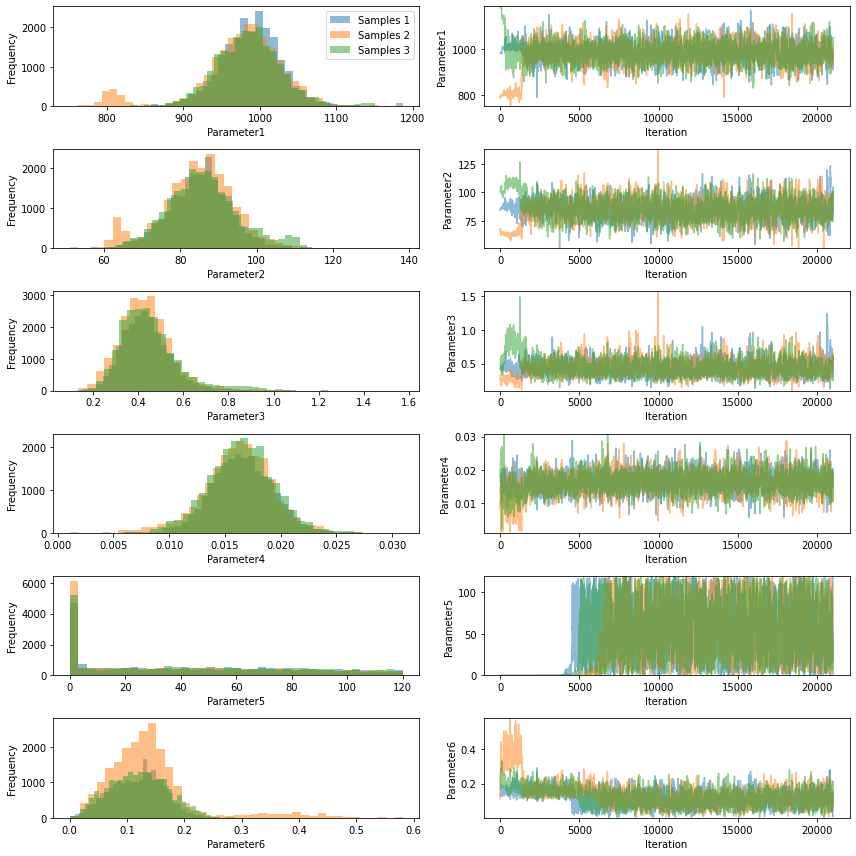

In [20]:
samples = np.load("./Data_and_parameters/pd_real_mcmc_combNoEta_params_dose_"+str(dose)+".npy")
pints.plot.trace(samples)
plt.show()

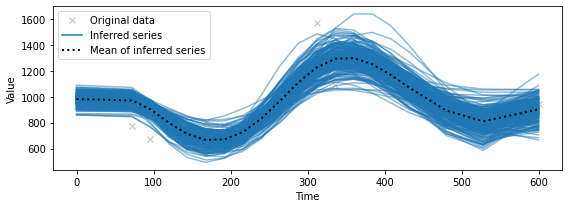

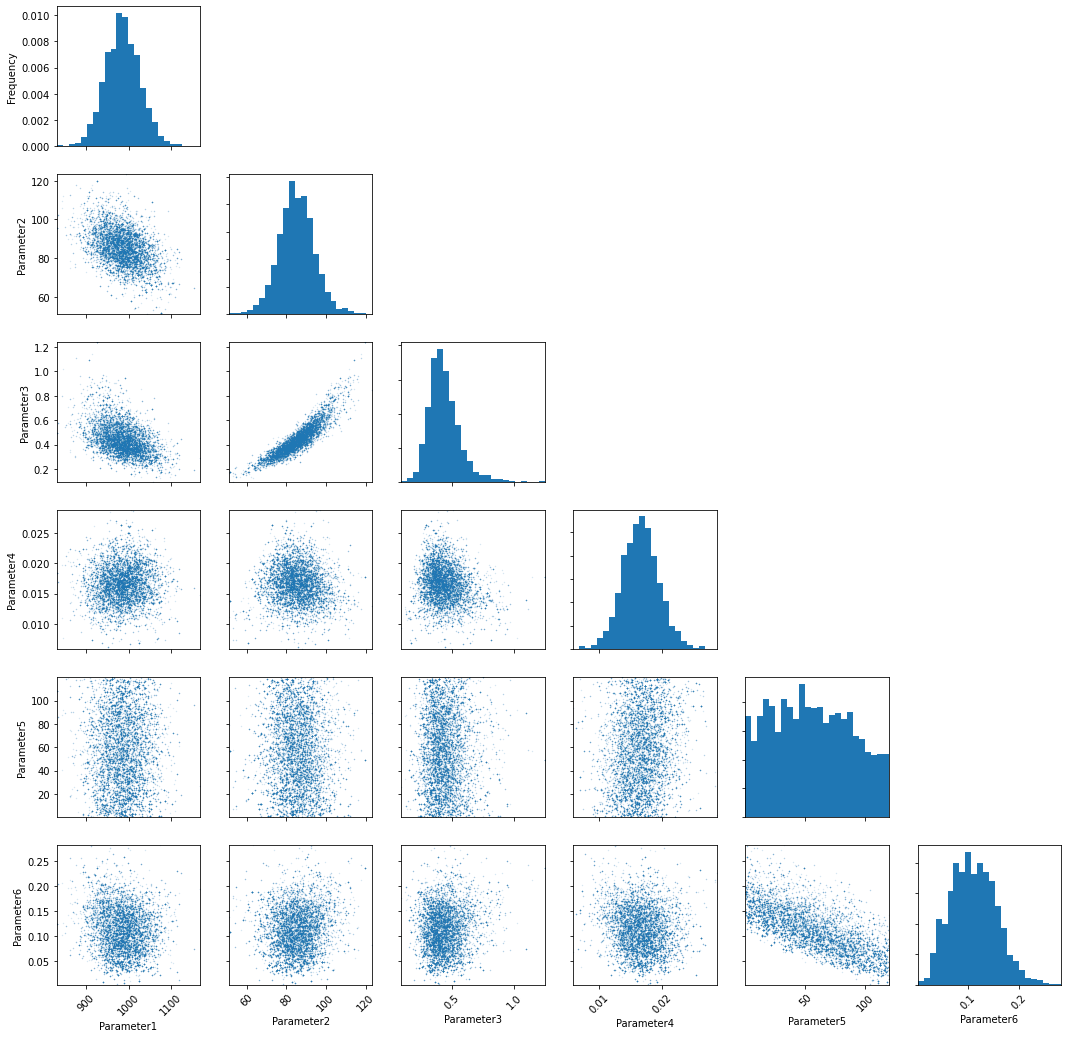

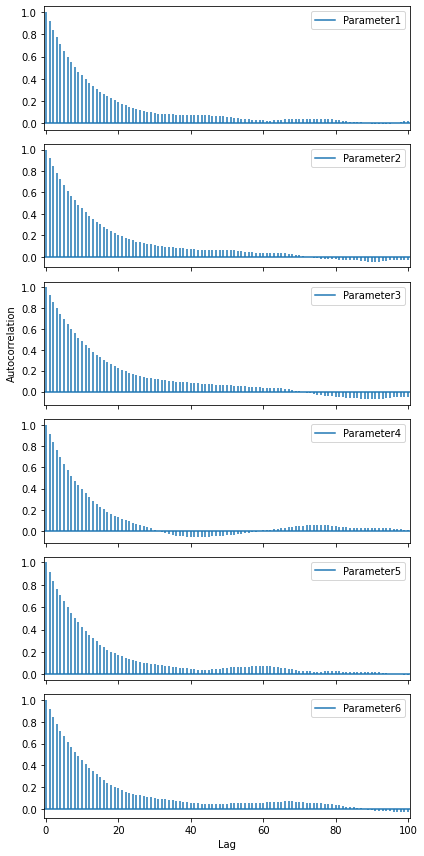

In [14]:
pints.plot.series(np.vstack(samples[:,int(3*num_iterations/4):]), problem)
plt.show()
pints.plot.pairwise(np.vstack(samples[:,int(3*num_iterations/4):]))
plt.show()
pints.plot.autocorrelation(np.vstack(samples[:,int(3*num_iterations/4):]))
plt.show()

In [23]:
print(pints.MCMCSummary(samples))

param    mean    std.    2.5%    25%     50%     75%      97.5%    rhat    ess
-------  ------  ------  ------  ------  ------  -------  -------  ------  -------
param 1  983.10  48.62   873.64  957.73  985.73  1011.89  1069.35  1.03    656.58
param 2  85.26   9.19    65.07   79.64   85.43   90.75    105.03   1.01    757.39
param 3  0.44    0.12    0.24    0.36    0.43    0.50     0.75     1.01    818.39
param 4  0.02    0.00    0.01    0.01    0.02    0.02     0.02     1.01    1230.17
param 5  42.43   37.50   0.00    2.54    37.07   73.38    114.30   1.11    31.01
param 6  0.13    0.06    0.03    0.09    0.12    0.16     0.25     1.09    48.48


### Constant Gaussian Noise

If we assume that the distrbution of observations around the true value is given by a Gaussian distribution, i.e. 
$$
X^{obs} \sim f(t, \theta) + \sigma N(0,1),
$$

then the likelihood of our data is given by

$$ \log L(\theta, \sigma | X^{obs}) = \sum_{i=1}^{n_t}\sum_{j=1}^{n_t}\left[\log L(\theta,\sigma|x^{obs}_j)\right] $$

where our pointwise log liklihoods are

$$\log L(\theta,\sigma|x^{obs}_{ij}) = - \frac{1}{2} \log 2\pi -  \log\sigma_i +\frac{(x^{obs}_{ij} - f_i(t_j, \theta))^2}{2\sigma_i^2}$$

In [10]:
# A look at the distribution of the parameters
parameters = np.load("./Data_and_parameters/pd_real_opt_combNoEta_params_dose_"+str(dose)+".npy")
log_likelihood = pints.GaussianLogLikelihood(problem)
log_prior = pints.UniformLogPrior(np.asarray(lower_bound[:5])*0.8, np.asarray(upper_bound[:5])*1.2)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)
num_iterations = (pints_model_real.n_parameters()+3)*3000

startpoints = [np.asarray(parameters[:5]), np.asarray(parameters[:5])*0.8, np.asarray(parameters[:5])*1.2]
mcmc = pints.MCMCController(log_posterior, 3, startpoints, method=pints.HaarioBardenetACMC)
mcmc.set_max_iterations(num_iterations)
# mcmc.set_log_to_screen(False)
samples = mcmc.run()
np.save("./Data_and_parameters/pd_real_mcmc_add_params_dose_"+str(dose), samples)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.3
1     6      0         0         0.5        0:00.4
2     9      0         0         0.333      0:00.4
3     12     0         0.25      0.25       0:00.5
20    63     0.333     0.333     0.143      0:05.6
40    123    0.268     0.293     0.268      0:11.9
60    183    0.23      0.279     0.213      0:16.6
80    243    0.222     0.247     0.21       0:24.0
100   303    0.198     0.257     0.238      0:30.1
120   363    0.165     0.24      0.223      0:37.9
140   423    0.141844  0.22      0.248227   0:46.2
160   483    0.136646  0.242236  0.224      0:53.4
180   543    0.133     0.238     0.198895   1:00.3
Initial phase completed.
200   603    0.124     0.234     0.189      1:07.7
220   663    0.163     0.258     0.199095   1:15.7
240   723    0.174     0.27      0.199      1:23.0
260   783   

3100  9303   0.0429    0.115     0.162     13:33.6
3120  9363   0.0426    0.115     0.161     13:38.0
3140  9423   0.0423    0.114     0.16      13:42.6
3160  9483   0.0421    0.113888  0.159     13:47.4
3180  9543   0.0418    0.113     0.158     13:52.6
3200  9603   0.0415    0.113     0.158     13:58.6
3220  9663   0.0413    0.112077  0.157     14:04.1
3240  9723   0.041     0.111     0.156     14:10.2
3260  9783   0.0408    0.111     0.155     14:16.1
3280  9843   0.0405    0.11      0.154     14:22.2
3300  9903   0.0403    0.109     0.154     14:28.0
3320  9963   0.04      0.109     0.152966  14:33.5
3340  10023  0.0401    0.108     0.152     14:39.5
3360  10083  0.0399    0.107     0.151     14:45.6
3380  10143  0.0396    0.107     0.15      14:51.8
3400  10203  0.0394    0.106     0.149     14:57.5
3420  10263  0.0398    0.105817  0.148     15:03.4
3440  10323  0.0401    0.106     0.148     15:09.3
3460  10383  0.0399    0.106     0.147     15:15.4
3480  10443  0.0396    0.105   

6320  18963  0.281     0.128     0.109     29:08.6
6340  19023  0.283     0.128     0.11      29:14.5
6360  19083  0.285     0.128     0.112     29:20.3
6380  19143  0.287     0.127     0.114     29:26.4
6400  19203  0.289     0.127     0.115     29:32.9
6420  19263  0.291     0.126     0.116     29:39.5
6440  19323  0.292     0.126     0.116     29:45.4
6460  19383  0.293     0.126     0.117     29:51.1
6480  19443  0.293     0.125     0.119     29:57.0
6500  19503  0.295     0.125     0.119     30:02.3
6520  19563  0.296     0.125     0.121     30:08.0
6540  19623  0.297     0.12414   0.121     30:13.2
6560  19683  0.297668  0.124     0.123     30:18.6
6580  19743  0.299     0.123     0.124905  30:24.1
6600  19803  0.301318  0.123     0.125     30:29.5
6620  19863  0.302     0.123     0.126     30:34.8
6640  19923  0.303     0.123     0.127541  30:40.0
6660  19983  0.304     0.122     0.129     30:45.3
6680  20043  0.305     0.121838  0.13      30:50.6
6700  20103  0.305     0.121   

9540  28623  0.234     0.0878    0.223     45:20.6
9560  28683  0.233     0.0876    0.224     45:27.6
9580  28743  0.233     0.0875    0.223985  45:34.2
9600  28803  0.232     0.0875    0.224     45:41.0
9620  28863  0.232     0.0873    0.224     45:47.7
9640  28923  0.231615  0.0874    0.225     45:53.3
9660  28983  0.231     0.0873    0.226     45:58.4
9680  29043  0.230658  0.0872    0.226     46:04.0
9700  29103  0.23      0.087     0.227     46:09.7
9720  29163  0.23      0.087     0.227     46:15.3
9740  29223  0.229     0.0871    0.228     46:21.2
9760  29283  0.229     0.087     0.229     46:27.5
9780  29343  0.228     0.0868    0.229     46:33.9
9800  29403  0.228     0.0867    0.23      46:40.0
9820  29463  0.227     0.0865    0.23      46:45.5
9840  29523  0.227     0.0865    0.230566  46:50.8
9860  29583  0.226     0.0865    0.231     46:57.3
9880  29643  0.226     0.0863    0.232     47:04.4
9900  29703  0.226     0.0862    0.233     47:10.2
9920  29763  0.225     0.086   

12760 38283  0.175     0.134     0.223     56:12.5
12780 38343  0.175     0.135     0.222     56:15.4
12800 38403  0.175     0.136     0.222092  56:18.4
12820 38463  0.175     0.137     0.222     56:21.3
12840 38523  0.174     0.138307  0.221     56:23.8
12860 38583  0.174     0.139     0.221     56:26.3
12880 38643  0.174     0.14      0.221     56:28.9
12900 38703  0.174     0.142     0.22      56:31.4
12920 38763  0.173     0.142     0.22      56:34.2
12940 38823  0.173016  0.143     0.22      56:37.0
12960 38883  0.172749  0.144     0.219     56:39.8
12980 38943  0.172     0.144     0.219     56:42.4
13000 39003  0.172     0.145     0.219     56:46.0
13020 39063  0.171953  0.146     0.218     56:49.0
13040 39123  0.172     0.147     0.218     56:51.8
13060 39183  0.171     0.148     0.218     56:54.7
13080 39243  0.171     0.149377  0.217     56:57.5
13100 39303  0.170903  0.15      0.217     57:00.9
13120 39363  0.171     0.152     0.217     57:03.9
13140 39423  0.17      0.153   

15980 47943  0.143     0.28      0.179     64:13.8
16000 48003  0.143     0.281     0.178     64:17.2
16020 48063  0.143     0.282     0.178     64:19.8
16040 48123  0.143     0.282     0.178     64:23.1
16060 48183  0.142     0.283     0.178     64:26.0
16080 48243  0.142     0.283     0.177     64:29.5
16100 48303  0.142     0.284     0.177194  64:33.4
16120 48363  0.142     0.285     0.177     64:37.9
16140 48423  0.142     0.285     0.177     64:41.5
16160 48483  0.142256  0.286     0.177     64:44.8
16180 48543  0.142     0.287     0.176     64:48.1
16200 48603  0.142     0.287     0.176162  64:51.6
16220 48663  0.142223  0.288     0.176     64:54.6
16240 48723  0.142     0.288     0.176     64:58.1
16260 48783  0.143     0.289     0.175512  65:01.8
16280 48843  0.142     0.29      0.175     65:05.3
16300 48903  0.143     0.29      0.175     65:08.7
16320 48963  0.143     0.291     0.175     65:12.3
16340 49023  0.143     0.291353  0.175     65:16.1
16360 49083  0.143     0.292   

19200 57603  0.204     0.274     0.149     73:03.7
19220 57663  0.204     0.273711  0.149     73:07.9
19240 57723  0.205     0.273     0.149     73:11.4
19260 57783  0.205     0.273     0.149     73:14.8
19280 57843  0.205     0.273     0.148     73:17.2
19300 57903  0.206     0.273     0.148     73:20.3
19320 57963  0.207     0.272     0.148     73:23.4
19340 58023  0.207     0.272     0.148     73:26.6
19360 58083  0.208     0.272     0.148     73:29.5
19380 58143  0.209     0.271     0.147722  73:32.3
19400 58203  0.21      0.271     0.148     73:35.6
19420 58263  0.21      0.271     0.147     73:38.4
19440 58323  0.211     0.271     0.147     73:41.5
19460 58383  0.212     0.27      0.147     73:45.0
19480 58443  0.212     0.270058  0.147     73:48.3
19500 58503  0.213     0.269781  0.146813  73:50.8
19520 58563  0.214     0.27      0.147     73:53.4
19540 58623  0.214     0.269     0.147     73:55.6
19560 58683  0.215     0.269     0.146     73:59.0
19580 58743  0.215515  0.269   

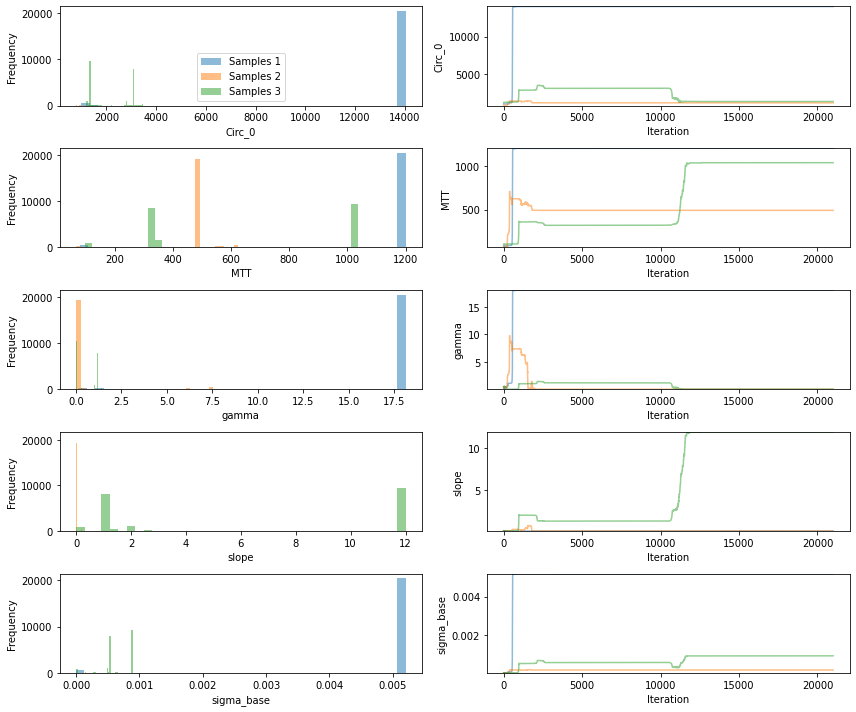

In [24]:
samples = np.load("./Data_and_parameters/pd_real_mcmc_add_params_dose_"+str(dose)+".npy")
pints.plot.trace(samples, parameter_names=parameter_names[:5])
plt.show()

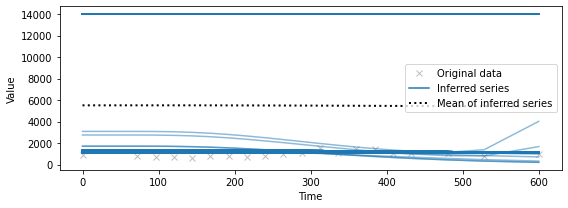

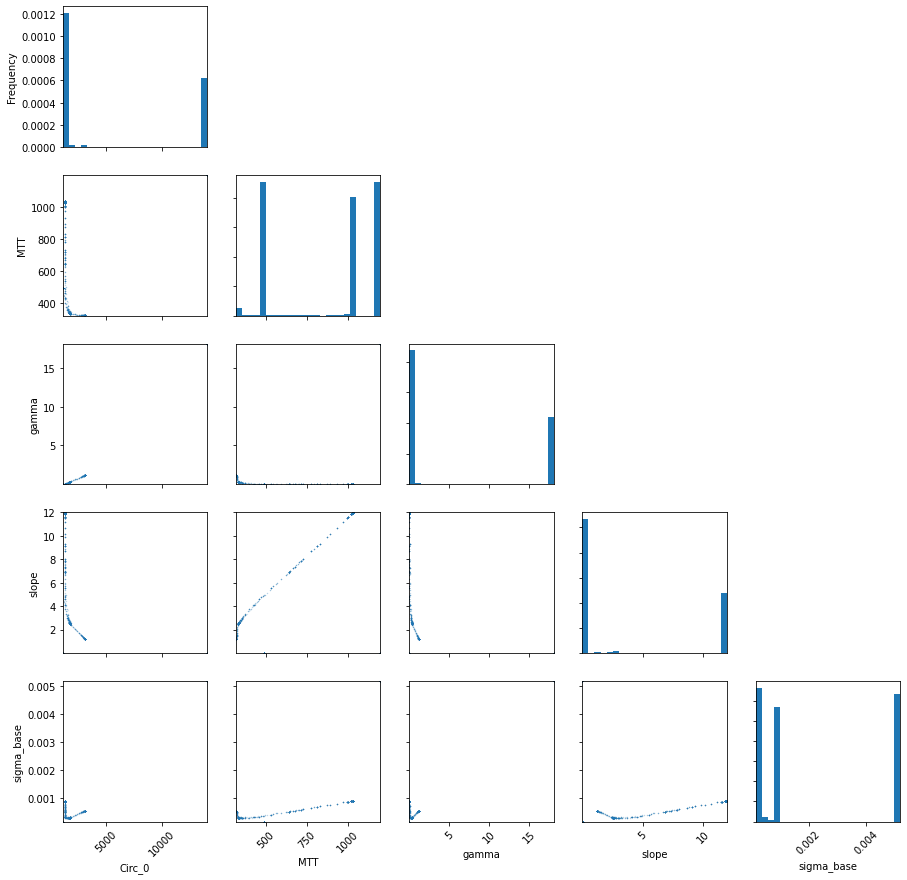

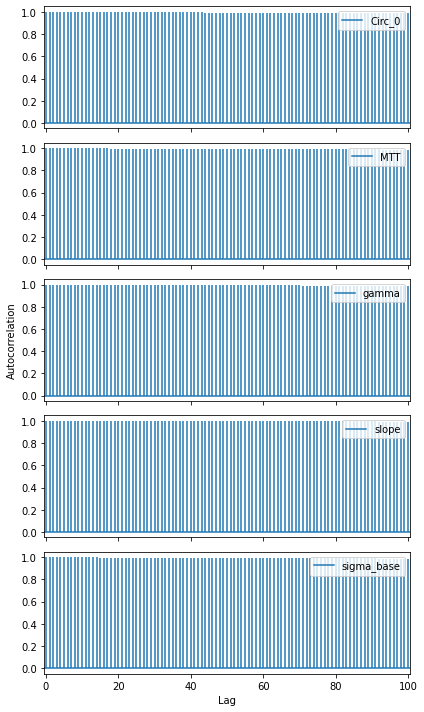

param    mean     std.     2.5%     25%      50%      75%       97.5%     rhat    ess
-------  -------  -------  -------  -------  -------  --------  --------  ------  ------
param 1  5652.27  5836.63  1135.26  1136.49  1363.15  14018.40  14037.24  5.26    76.46
param 2  767.39   374.51   105.92   490.60   543.92   1200.00   1200.00   3.05    102.28
param 3  6.20     8.30     0.01     0.01     1.00     18.10     18.11     4.95    57.39
param 4  2.07     4.23     0.00     0.00     0.01     1.19      12.00     4.39    112.02
param 5  0.00     0.00     0.00     0.00     0.00     0.01      0.01      5.12    98.36


In [31]:
num_iterations = (pints_model_real.n_parameters()+3)*3000
pints.plot.series(np.vstack(samples[:,int(2*num_iterations/4):]), problem)
plt.show()
pints.plot.pairwise(np.vstack(samples[:,int(2*num_iterations/4):]), parameter_names=parameter_names[:5])
plt.show()
pints.plot.autocorrelation(np.vstack(samples[:,int(2*num_iterations/4):]), parameter_names=parameter_names[:5])
plt.show()

### Relative Gaussian likelihood

If we assume that the distrbution of observations around the true value is relative to the magnitude of the true value, i.e. 
$$
X^{obs} = f\left(t, \theta\right) + \sigma f\left(t, \theta\right)^\eta \epsilon,
$$
where $ \epsilon \sim N\left(0,1\right)$.

Then the likelihood of our data is given by

$$ \log L\left(\theta, \sigma, \eta | X^{obs}\right) = \sum_{i=1}^{n_t}\sum_{j=1}^{n_t}\left[\log L\left(\theta,\sigma, \eta|x^{obs}_{ij}\right)\right] $$

where our pointwise log liklihoods are

$$\log L\left(\theta,\sigma, \eta|x^{obs}_{ij}\right) = - \frac{1}{2} \log 2\pi - \log f_i\left(t_j, \theta\right)^{\eta_i}\sigma_i -\frac{\left(x^{obs}_{ij} - f_i\left(t_j, \theta\right)\right)^2}{2\left(f_i\left(t_j, \theta\right)^{\eta_i}\sigma_i\right)^2}$$

In [32]:
# A look at the distribution of the parameters
parameters = np.load("./Data_and_parameters/pd_real_opt_combNoEta_params_dose_"+str(dose)+".npy")

lower_bound = [0.01*Circ_0_approx, 0.1, 0.01, 0.001, 0.0]
upper_bound = [100*Circ_0_approx, 1000, 100, 10, 10]

log_likelihood = MultiplicativeGaussianLogLikelihoodFixEta(problem)
log_prior = pints.UniformLogPrior(np.asarray(lower_bound)*0.8, np.asarray(upper_bound)*1.2)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)
num_iterations = (pints_model_real.n_parameters()+3)*3000

print(parameters)

[9.87182190e+02 8.42956640e+01 4.14055226e-01 1.65377881e-02
 1.48100237e-12 1.38470015e-01]


In [7]:
start_point = np.concatenate((np.asarray(parameters[:4]),np.asarray(parameters[5:])))

startpoints = [start_point, start_point*0.8, start_point*1.2]
mcmc = pints.MCMCController(log_posterior, 3, startpoints, method=pints.HaarioBardenetACMC)
mcmc.set_max_iterations(num_iterations)
# mcmc.set_log_to_screen(False)
samples = mcmc.run()
np.save("./Data_and_parameters/pd_real_mcmc_multNoEta_params_dose_"+str(dose), samples)

[9.87182190e+02 8.42956640e+01 4.14055226e-01 1.65377881e-02
 1.48100237e-12 1.38470015e-01]
Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.3
1     6      0         0         0.5        0:00.5
2     9      0         0         0.333      0:00.7
3     12     0         0         0.25       0:00.9
20    63     0         0.19      0.143      0:05.6
40    123    0.0244    0.22      0.195122   0:10.2
60    183    0.0492    0.18      0.23       0:15.4
80    243    0.0741    0.173     0.235      0:20.5
100   303    0.099     0.218     0.257      0:25.4
120   363    0.116     0.214876  0.256      0:30.2
140   423    0.113     0.206     0.277      0:35.0
160   483    0.0994    0.211     0.286      0:39.8
180   543    0.0939    0.21      0.281768   0:45.0
Initial phase completed.
200   603    0.109     0.224     0.289      0:49.8
220   663    0.149   

3060  9183   0.204     0.212     0.22      14:35.3
3080  9243   0.204     0.212     0.22      14:41.3
3100  9303   0.204     0.212     0.22      14:47.4
3120  9363   0.203     0.212     0.22      14:53.5
3140  9423   0.202     0.214     0.220312  14:59.5
3160  9483   0.202     0.214     0.22      15:05.5
3180  9543   0.202     0.214     0.219     15:11.3
3200  9603   0.203     0.214     0.218     15:17.0
3220  9663   0.205     0.215     0.218     15:22.6
3240  9723   0.204     0.214     0.217834  15:28.3
3260  9783   0.205     0.213     0.217418  15:34.1
3280  9843   0.205     0.214     0.218     15:40.1
3300  9903   0.205     0.215     0.218     15:45.8
3320  9963   0.205     0.216     0.217     15:51.5
3340  10023  0.205     0.217     0.216     15:57.2
3360  10083  0.205     0.217     0.217     16:03.0
3380  10143  0.204     0.215     0.217     16:08.7
3400  10203  0.203     0.215     0.218     16:14.6
3420  10263  0.203     0.215     0.219     16:20.2
3440  10323  0.204     0.216   

6280  18843  0.216     0.216     0.222     30:28.0
6300  18903  0.216     0.216     0.222     30:33.7
6320  18963  0.216     0.216     0.221     30:39.5
6340  19023  0.216     0.216     0.222     30:45.1
6360  19083  0.216     0.216     0.222     30:51.0
6380  19143  0.216     0.216     0.221     30:56.5
6400  19203  0.216     0.21606   0.221     31:02.1
6420  19263  0.216     0.21601   0.221     31:08.1
6440  19323  0.216     0.216     0.22      31:14.0
6460  19383  0.217     0.216     0.221     31:19.7
6480  19443  0.217     0.217     0.221     31:25.7
6500  19503  0.217     0.217     0.22      31:31.4
6520  19563  0.217     0.217298  0.22      31:37.3
6540  19623  0.217     0.217398  0.22      31:43.2
6560  19683  0.217     0.217     0.221     31:49.1
6580  19743  0.218     0.218     0.221091  31:54.9
6600  19803  0.218     0.218     0.221     32:00.7
6620  19863  0.217     0.217     0.221     32:06.4
6640  19923  0.217     0.217     0.221     32:12.0
6660  19983  0.216     0.218   

9500  28503  0.218     0.222     0.226292  46:41.1
9520  28563  0.219     0.222     0.226     46:47.0
9540  28623  0.219     0.222     0.226601  46:52.9
9560  28683  0.219     0.222     0.227     46:58.9
9580  28743  0.22      0.222     0.227     47:05.1
9600  28803  0.22      0.222     0.227     47:11.1
9620  28863  0.22      0.222     0.227     47:17.1
9640  28923  0.22      0.222     0.227     47:23.2
9660  28983  0.22006   0.222     0.227     47:29.2
9680  29043  0.219812  0.222     0.227     47:35.3
9700  29103  0.22      0.221     0.226     47:42.2
9720  29163  0.22      0.221     0.226     47:48.9
9740  29223  0.22      0.221     0.226     47:55.6
9760  29283  0.22      0.221     0.226     48:02.5
9780  29343  0.22      0.221143  0.226     48:09.1
9800  29403  0.22      0.221     0.226     48:15.8
9820  29463  0.22      0.221     0.227     48:21.7
9840  29523  0.22      0.221     0.227     48:27.5
9860  29583  0.22      0.221     0.227     48:33.4
9880  29643  0.22      0.221   

12720 38163  0.221     0.222624  0.228     62:53.0
12740 38223  0.222     0.223     0.228     62:59.0
12760 38283  0.221     0.223     0.228     63:05.2
12780 38343  0.221     0.223     0.228     63:11.3
12800 38403  0.221389  0.223     0.228     63:17.2
12820 38463  0.221     0.223     0.228     63:23.2
12840 38523  0.222     0.223425  0.228     63:29.4
12860 38583  0.222     0.224     0.228     63:35.4
12880 38643  0.222     0.224     0.228     63:41.3
12900 38703  0.222     0.224     0.228     63:47.5
12920 38763  0.222     0.225     0.228     63:53.6
12940 38823  0.222     0.225     0.228     63:59.7
12960 38883  0.222     0.225     0.228     64:05.9
12980 38943  0.222     0.225     0.228     64:12.1
13000 39003  0.222     0.224675  0.228     64:18.1
13020 39063  0.222     0.225     0.228     64:24.2
13040 39123  0.223     0.225     0.229     64:30.4
13060 39183  0.222571  0.225     0.229     64:36.5
13080 39243  0.223     0.225     0.229     64:42.4
13100 39303  0.223     0.22525 

15940 47823  0.225     0.226021  0.223     79:16.7
15960 47883  0.225     0.226051  0.223     79:22.4
15980 47943  0.225     0.226     0.22314   79:28.4
16000 48003  0.225     0.226     0.223     79:34.1
16020 48063  0.225     0.22664   0.223     79:39.8
16040 48123  0.225173  0.227     0.223     79:44.9
16060 48183  0.225     0.226636  0.223336  79:50.5
16080 48243  0.225     0.227     0.223307  79:56.5
16100 48303  0.225     0.226694  0.223     80:02.3
16120 48363  0.225     0.227     0.224     80:08.2
16140 48423  0.225     0.227     0.223654  80:14.1
16160 48483  0.225     0.226     0.224     80:20.1
16180 48543  0.225     0.226     0.224     80:26.1
16200 48603  0.224     0.226     0.224     80:32.1
16220 48663  0.224     0.22588   0.224     80:38.1
16240 48723  0.224     0.226     0.224     80:44.1
16260 48783  0.225     0.226     0.223664  80:50.1
16280 48843  0.225     0.226     0.224     80:55.9
16300 48903  0.225     0.226     0.223974  81:01.7
16320 48963  0.225     0.226   

19160 57483  0.227     0.229059  0.228     95:31.7
19180 57543  0.226422  0.229     0.228     95:38.2
19200 57603  0.226     0.229     0.228     95:44.7
19220 57663  0.226     0.229     0.228344  95:51.2
19240 57723  0.226     0.229     0.228     95:57.8
19260 57783  0.226     0.229     0.228     96:04.3
19280 57843  0.226     0.229345  0.228     96:10.9
19300 57903  0.226     0.22947   0.228     96:17.5
19320 57963  0.226     0.229     0.228     96:24.0
19340 58023  0.226     0.229     0.228     96:30.3
19360 58083  0.226     0.229     0.228     96:36.4
19380 58143  0.226     0.23      0.228     96:42.8
19400 58203  0.226     0.23      0.228     96:49.2
19420 58263  0.226147  0.23      0.228     96:55.7
19440 58323  0.226     0.229875  0.228     97:01.7
19460 58383  0.226     0.23      0.228     97:07.7
19480 58443  0.226     0.23      0.228     97:13.4
19500 58503  0.226091  0.23      0.228296  97:19.2
19520 58563  0.226     0.23      0.228267  97:24.8
19540 58623  0.226     0.23    

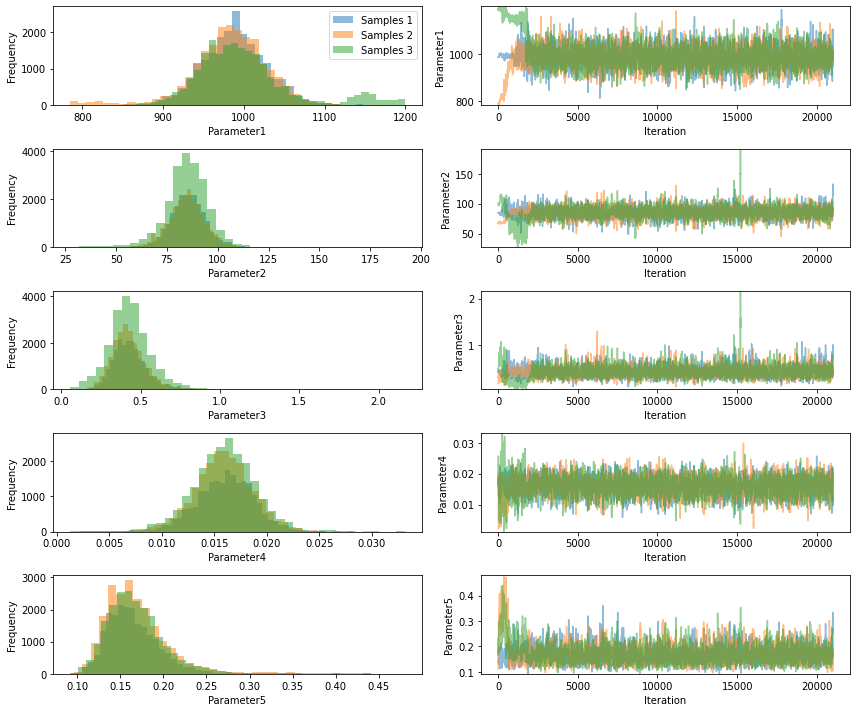

param    mean    std.    2.5%    25%     50%     75%      97.5%    rhat    ess
-------  ------  ------  ------  ------  ------  -------  -------  ------  -------
param 1  990.76  50.73   902.33  960.69  987.82  1015.09  1133.94  1.04    1224.02
param 2  84.95   9.64    65.48   79.44   85.14   90.82    103.25   1.01    1338.61
param 3  0.43    0.12    0.22    0.36    0.42    0.49     0.71     1.00    1656.06
param 4  0.02    0.00    0.01    0.01    0.02    0.02     0.02     1.00    2550.76
param 5  0.17    0.04    0.12    0.14    0.16    0.18     0.25     1.00    901.16


In [34]:
samples = np.load("./Data_and_parameters/pd_real_mcmc_multNoEta_params_dose_"+str(dose)+'.npy')
pints.plot.trace(samples)
plt.show()
print(pints.MCMCSummary(samples))

#### Getting pointwise loglikelihoods

In [13]:
import numpy as np
import pints
import pandas

# Get our Log-likelihoods:
from ipynb.fs.full.model_simulation import GaussianLogLikelihood
from ipynb.fs.full.model_simulation import MultiplicativeGaussianLogLikelihood
from ipynb.fs.full.model_simulation import ConstantAndMultiplicativeGaussianLogLikelihood

In [35]:
data_type = 'real'
model_type = 'multNoEta'
drug = 'Docetaxel'
observation = 'Platelets '
dose = 10
num_comp = 2

# Load data
df = pandas.read_csv("0470-2008_2018-05-09.csv")
df = df.sort_values(['DOSE', 'TIME'], ascending=True)
df = df.astype({'ID': 'int64'})
df_drug = df.loc[(df['DOSE'] == dose) & (df['DRUG'] == drug)] #
df_OBS = df_drug.loc[(df_drug['YNAME'] == observation)]
df_OBS = df_OBS.drop(df_OBS[df_OBS['OBS'] == '.'].index)[['TIME', 'DOSE', 'OBS']]
df_OBS = df_OBS.astype({'OBS': 'float64'})
df_stats = df_OBS[['TIME', 'DOSE', 'OBS']]
df_stats = df_stats.astype({'OBS': 'float64'})
df_stats = df_stats.groupby(["TIME", "DOSE"], as_index=False).filter(lambda x: len(x) > 1).groupby(["TIME", "DOSE"], as_index=False).agg({'OBS':['mean','std']})
df_stats.columns = ['TIME', "DOSE", 'mean', 'std']

# Load samples
samples = np.load("./Data_and_parameters/pd_"+data_type+"_mcmc_"+model_type+"_params_dose_"+str(dose)+".npy")

In [15]:
from ipynb.fs.full.model_simulation import PintsPDFriberg # import the pints model

# Create the model in PINTS
PK_params=np.load('PK_parameters_real_'+drug+str(dose)+'.npy')
start_time = df_OBS['TIME'].min()
print(start_time)

pints_model_real = PintsPDFriberg(PK_params, dose, num_comp=num_comp, start_time=start_time)
problem = pints.SingleOutputProblem(pints_model_real, np.asarray(df_stats['TIME'])-start_time, df_stats['mean'])
    

-48.0


In [16]:
# Recreate
parameters = np.load("./Data_and_parameters/pd_"+data_type+"_opt_"+"combNoEta"+"_params_dose_"+str(dose)+".npy")

log_likelihood = GaussianLogLikelihood(problem)
test_likelihood = pints.GaussianLogLikelihood(problem)
num_iterations = (pints_model_real.n_parameters()+3)*3000

print(parameters)

[9.87182190e+02 8.42956640e+01 4.14055226e-01 1.65377881e-02
 1.48100237e-12 1.38470015e-01]


In [9]:
pointwise = []
sum_likelihoods = []

no_samples = samples.shape[1]
for chain_no, chain in enumerate(samples):
    proportion_check = 0
    for j, sample_parameters in enumerate(chain):
        single_pointwise = log_likelihood.create_pointwise_loglikelihoods(sample_parameters)
        pointwise.append(single_pointwise)
        test = test_likelihood.__call__(sample_parameters)
        sum_likelihoods.append(test)
        proportion = (j+1)/no_samples
        if proportion > proportion_check:
            print("chain "+str(chain_no+1)+"\t\t" +str(proportion_check*100)+"%")
            if proportion_check < 0.1:
                proportion_check += 0.01
            else:
                proportion_check += 0.1
pointwise = np.asarray(pointwise)

chain 1		0%
chain 1		1.0%
chain 1		2.0%
chain 1		3.0%
chain 1		4.0%
chain 1		5.0%
chain 1		6.000000000000001%
chain 1		7.000000000000001%
chain 1		8.0%
chain 1		9.0%
chain 1		10.0%
chain 1		10.999999999999998%
chain 1		21.0%
chain 1		31.0%
chain 1		41.0%
chain 1		51.0%
chain 1		61.0%
chain 1		71.0%
chain 1		81.0%
chain 1		90.99999999999999%
chain 2		0%
chain 2		1.0%
chain 2		2.0%
chain 2		3.0%
chain 2		4.0%
chain 2		5.0%
chain 2		6.000000000000001%
chain 2		7.000000000000001%
chain 2		8.0%
chain 2		9.0%
chain 2		10.0%
chain 2		10.999999999999998%
chain 2		21.0%
chain 2		31.0%
chain 2		41.0%
chain 2		51.0%
chain 2		61.0%
chain 2		71.0%
chain 2		81.0%
chain 2		90.99999999999999%
chain 3		0%
chain 3		1.0%
chain 3		2.0%
chain 3		3.0%
chain 3		4.0%
chain 3		5.0%
chain 3		6.000000000000001%
chain 3		7.000000000000001%
chain 3		8.0%
chain 3		9.0%
chain 3		10.0%
chain 3		10.999999999999998%
chain 3		21.0%
chain 3		31.0%
chain 3		41.0%
chain 3		51.0%
chain 3		61.0%
chain 3		71.0%
chain 3		81.0%

In [17]:
np.save("./Data_and_parameters/pd_"+data_type+"_mcmc_"+"add"+"_pointwiseLogLikelihoods_dose_"+str(dose)+".npy", pointwise)

NameError: name 'pointwise' is not defined

In [12]:
print(pointwise.shape)
sum_points = np.sum(pointwise, axis=1)
print(np.sum(sum_likelihoods-sum_points))

(63000, 20)
6.039626896381378e-07


### Model Comparison

Using these samples and the pointwise likelihoods I can compare the ability of these models to predict out-of-sample data. I will be using the python package Arvix to calculate the WAIC and LOO score.

In [21]:
import arviz as az
import matplotlib.pyplot as plt

model_type = "add"

samples = np.load("./Data_and_parameters/pd_"+data_type+"_mcmc_"+model_type+"_params_dose_"+str(dose)+".npy")
pointwise =np.load("./Data_and_parameters/pd_"+data_type+"_mcmc_"+model_type+"_pointwiseLogLikelihoods_dose_"+str(dose)+".npy")
pointwise=[pointwise[:21000,:],pointwise[21000:42000,:],pointwise[42000:,:]]
pointwise= np.asarray(pointwise)
print(pointwise.shape)

(3, 21000, 20)


In [80]:
likelihood = az.convert_to_inference_data(pointwise, group='log_likelihood')
posterior = az.convert_to_inference_data(samples, group='posterior')
observed = az.convert_to_inference_data(np.asarray(df_stats['mean']), group='observed_data')

inference_data = az.concat(likelihood, posterior, observed)

add
Computed from 63000 by 20 log-likelihood matrix

         Estimate       SE
elpd_loo -683636579566717558238123917312.00  165749805732667883592527904768.00
p_loo    683636579566717558238123917312.00        -

There has been a warning during the calculation. Please check the results.


/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


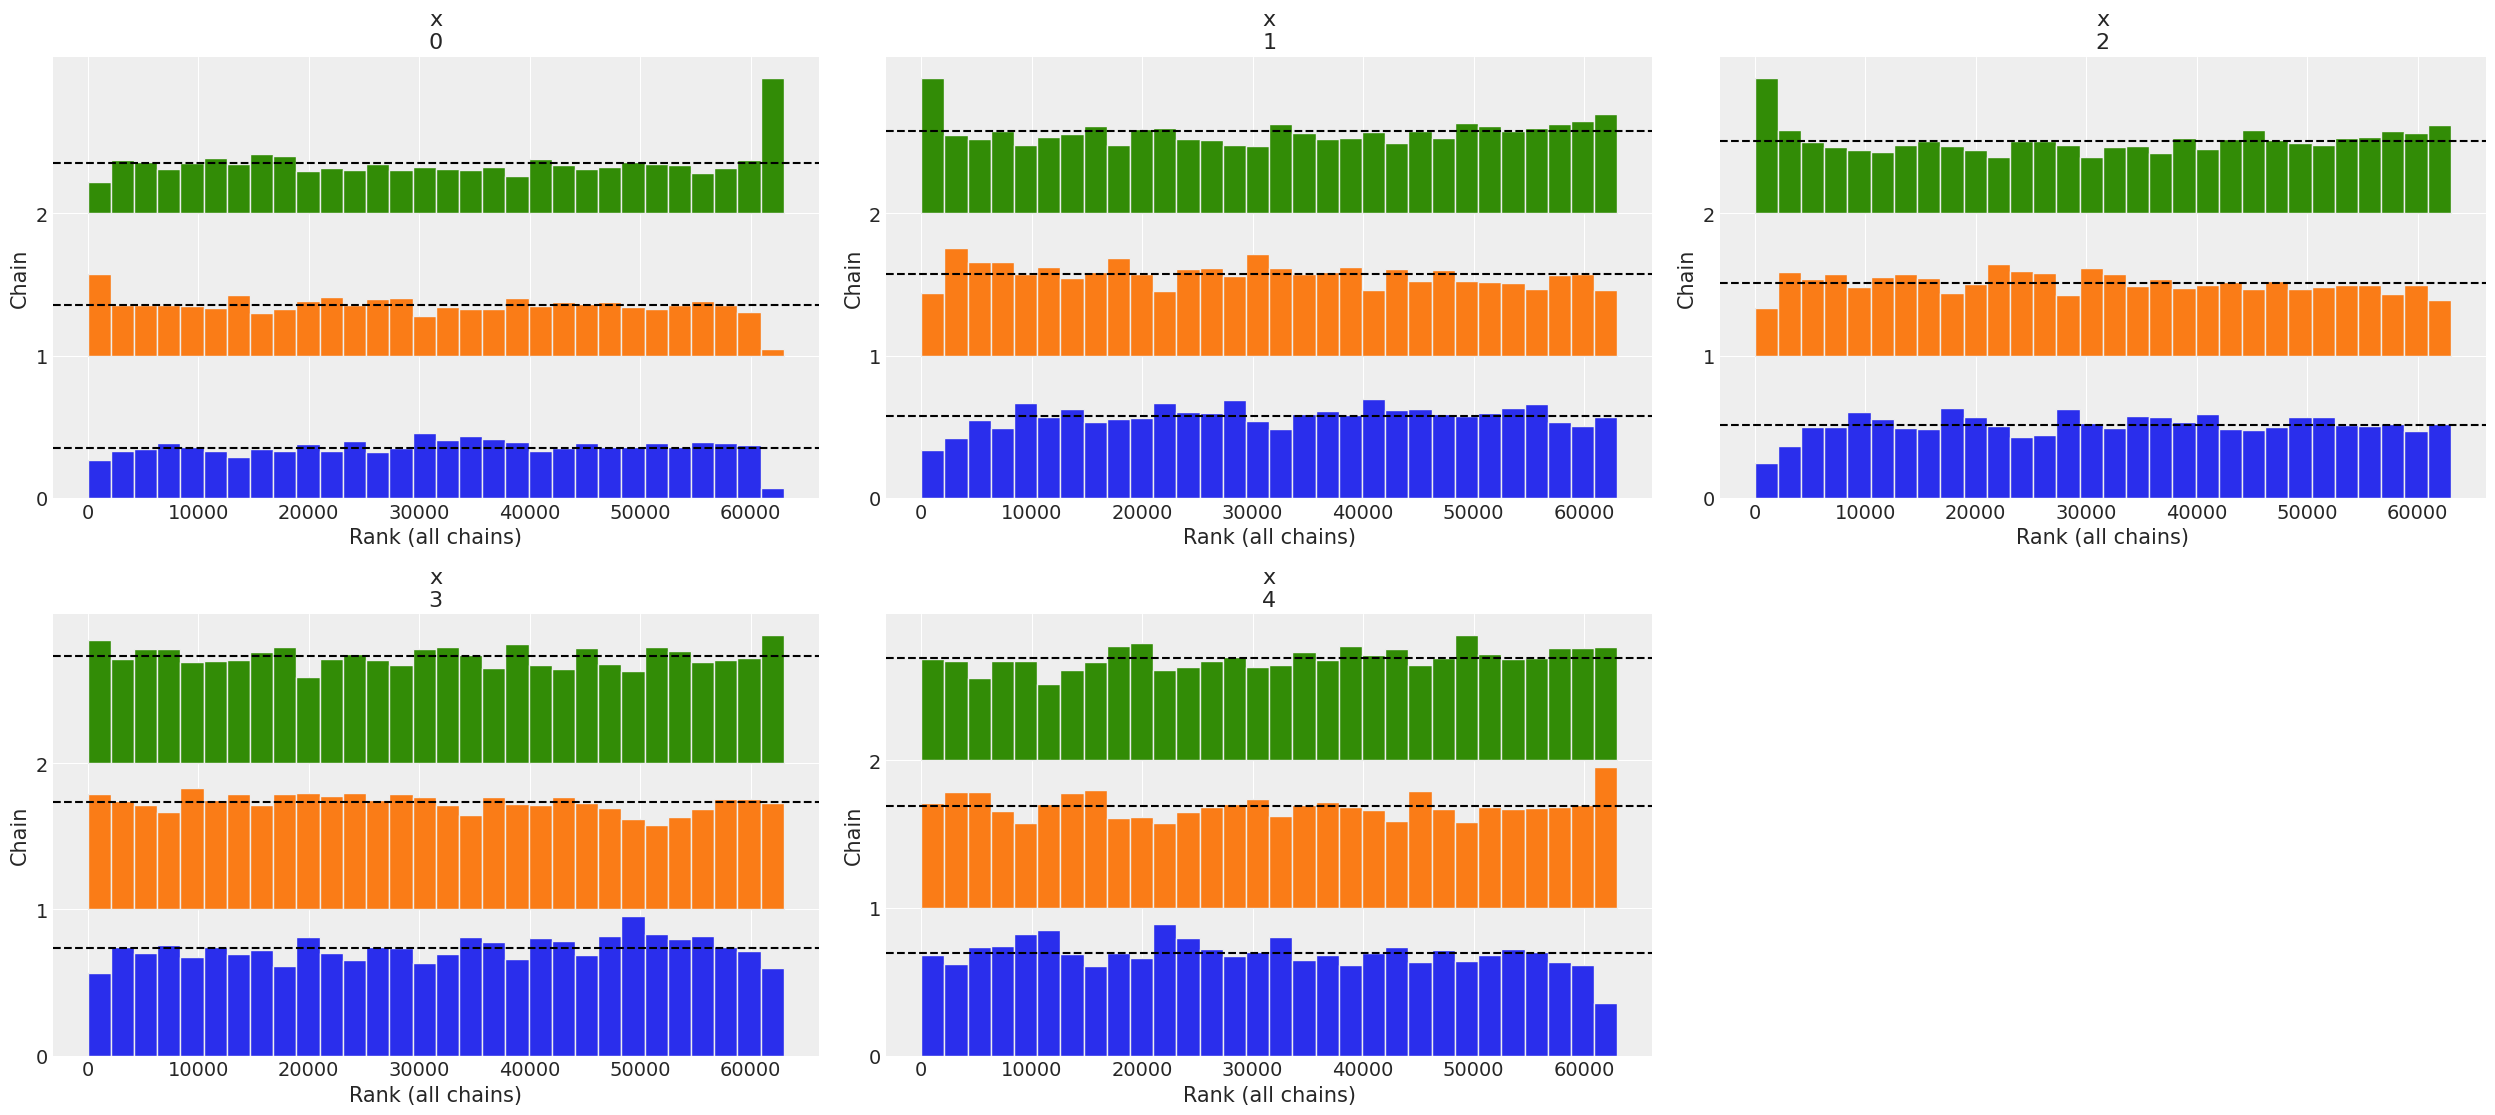

In [23]:
parameter_names = ['Circ_0', 'MTT', 'gamma', 'slope', 'sigma_base', 'eta', 'sigma_rel']
n_param = 5

az.style.use("arviz-darkgrid")
var_names=parameter_names[:n_param]

# az.plot_autocorr(inference_data)
# plt.show()

# az.plot_ess(inference_data, kind="evolution")
# plt.show()

# loo = az.loo(inference_data, pointwise=True)
# az.plot_khat(loo, show_bins=True)
# plt.show()

az.plot_rank(inference_data)
plt.show()

# az.plot_loo_pit(inference_data, y="0", ecdf=True, color="maroon")
# plt.show()

# Needs posterior predictive

# az.plot_bpv(inference_data)
# plt.show()
# az.plot_bpv(inference_data, kind="t_stat", t_stat="0.5")
# plt.show()

# Needs sample_stats

# az.plot_energy(inference_data, figsize=(12, 8))
# plt.show()




#### Comparisons

I looked at the MCMC summary for each of the models, especially $\hat{r}$ to determine whether the chains converged, as well as comparing the models using both LOO-PSIS and WAIC.

In [24]:
model_types = ["combNoEta", "add", "multNoEta"]
compare_dict = {}
data_type = 'real'

for model_type in model_types:
    samples = np.load("./Data_and_parameters/pd_"+data_type+"_mcmc_"+model_type+"_params_dose_"+str(dose)+".npy")
    print(model_type)
    print(pints.MCMCSummary(samples))
    
    pointwise =np.load("./Data_and_parameters/pd_"+data_type+"_mcmc_"+model_type+"_pointwiseLogLikelihoods_dose_"+str(dose)+".npy")
    pointwise=[pointwise[:21000,:],pointwise[21000:42000,:],pointwise[42000:,:]]
    pointwise= np.asarray(pointwise)
    likelihood = az.convert_to_inference_data(pointwise, group='log_likelihood')
    posterior = az.convert_to_inference_data(samples, group='posterior')
    observed = az.convert_to_inference_data(np.asarray(df_stats['mean']), group='observed_data')
    inference_data = az.concat(likelihood, posterior, observed)
    compare_dict[model_type] = inference_data

comparison = az.compare(compare_dict)
comparison

combNoEta
param    mean    std.    2.5%    25%     50%     75%      97.5%    rhat    ess
-------  ------  ------  ------  ------  ------  -------  -------  ------  -------
param 1  983.10  48.62   873.64  957.73  985.73  1011.89  1069.35  1.03    656.58
param 2  85.26   9.19    65.07   79.64   85.43   90.75    105.03   1.01    757.39
param 3  0.44    0.12    0.24    0.36    0.43    0.50     0.75     1.01    818.39
param 4  0.02    0.00    0.01    0.01    0.02    0.02     0.02     1.01    1230.17
param 5  42.43   37.50   0.00    2.54    37.07   73.38    114.30   1.11    31.01
param 6  0.13    0.06    0.03    0.09    0.12    0.16     0.25     1.09    48.48
add
param    mean     std.     2.5%     25%      50%      75%       97.5%     rhat    ess
-------  -------  -------  -------  -------  -------  --------  --------  ------  ------
param 1  5652.27  5836.63  1135.26  1136.49  1363.15  14018.40  14037.24  5.26    76.46
param 2  767.39   374.51   105.92   490.60   543.92   1200.00   1200.0

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance 

rank           loo         p_loo         d_loo        weight  \
combNoEta     0 -9.506079e+01  4.235018e+00  0.000000e+00  1.000000e+00   
multNoEta     1 -1.318854e+02  4.398985e+00  3.682460e+01  0.000000e+00   
add           2 -6.836366e+29  6.836366e+29  6.836366e+29  6.631806e-12   

                     se           dse  warning loo_scale  
combNoEta  2.765604e+00  0.000000e+00     True       log  
multNoEta  2.864171e+00  2.539391e-01     True       log  
add        1.657498e+29  1.657498e+29     True       log

$\hat{r}$ shows that when MCMC sampling was performed on constant gaussian noise ("add" in the table) there was no convergence in the chains. This explains the incredibly low LOO score with very high standard error. The multiplicative noise and combined noise models mostly converged and performed better in the LOO analysis with combined noise performing the best.

In [71]:
model_type = "multNoEta"
z_value = comparison["d_loo"][model_type] / comparison["dse"][model_type]
p_value = scipy.stats.norm.sf(abs(z_value))
print(model_type)
print("\t z value =", z_value)
print("\t p value =", p_value)

model_type = "add"
z_value = comparison["d_loo"][model_type] / comparison["dse"][model_type]
p_value = scipy.stats.norm.sf(abs(z_value))
print(model_type)
print("\t z value =", z_value)
print("\t p value =", p_value)

multNoEta
	 z value = 145.0135084348868
	 p value = 0.0
add
	 z value = 4.124509084911576
	 p value = 1.8576316426314295e-05


In [65]:
comparison = az.compare(compare_dict, ic="waic")
comparison

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.

rank          waic        p_waic        d_waic        weight  \
combNoEta     0 -9.459548e+01  3.769708e+00  0.000000e+00  1.000000e+00   
multNoEta     1 -1.313813e+02  3.894887e+00  3.678582e+01  0.000000e+00   
add           2 -2.434745e+54  2.434745e+54  2.434745e+54  1.800116e-12   

                     se           dse  warning waic_scale  
combNoEta  2.646156e+00  0.000000e+00     True        log  
multNoEta  2.685906e+00  2.268053e-01     True        log  
add        1.036791e+54  1.036791e+54     True        log

WAIC also confirms the results from LOO.

In [68]:
model_type = "multNoEta"
z_value = comparison["d_waic"][model_type] / comparison["dse"][model_type]
p_value = scipy.stats.norm.sf(abs(z_value))
print(model_type)
print("\t z value =", z_value)
print("\t p value =", p_value)

model_type = "add"
z_value = comparison["d_waic"][model_type] / comparison["dse"][model_type]
p_value = scipy.stats.norm.sf(abs(z_value))
print(model_type)
print("\t z value =", z_value)
print("\t p value =", p_value)

multNoEta
	 z value = 162.1911744652855
	 p value = 0.0
add
	 z value = 2.348347874194466
	 p value = 0.009428450172006612


#### K-Fold Validation

For both the LOO and WAIC calculations a warning was given (LOO: Estimated shape parameter of Pareto distribution is greater than 0.7; WAIC: For one or more samples the posterior variance of the log predictive densities exceeds 0.4). This is likely due to one or more of the observations being highly influential in the fit. Thus, to confirm the results of the model comparison, I will use a more computationally intensive method, K-fold validation, that will be less impacted by these influential points.

We start this process by splitting up the data into $K$ subsets, $X^{Obs}_k$.

In [7]:
K = 4
model_type = "add" # choose from: "combNoEta", "add" or "multNoEta"

# Split into the K subsets
df= pandas.read_csv("./Data_and_parameters/pd_real_data_refined_"+drug+"_dose_"+str(dose))
df_shuffled = df.sample(frac=1)
data_k = np.array_split(df_shuffled, K)

Then the model needs to be fit to each set $X^{obs}_{-k} = \cup_{j \neq k} X^{obs}_j $ thus providing the posterior distribution, $P(\theta | X^{obs}_{-k})$.

In [8]:
# Get the data_-k for fitting
data_minus_k = [None]*K
for i in range(0, K):
    data = data_k[:i] + data_k[i+1:]
    data_minus_k[i] = pandas.concat(data)
    data_minus_k[i] = data_minus_k[i].sort_values(['DOSE', 'TIME'], ascending=True)
    # print(data_minus_k[i])

In [9]:
# Set up details of the MCMC run
PK_params=np.load('PK_parameters_real_'+drug+str(dose)+'.npy')
start_time = df['TIME'].min()

pints_model_real = PintsPDFriberg(PK_params, dose_amount, num_comp=num_comp, start_time=start_time)

df_before_0 = df[df["TIME"] < 0]
times_before_dose = len(df_before_0["mean"])
Circ_0_approx = sum(df_before_0["mean"])/times_before_dose
parameter_names =['Circ_0', 'MTT', 'gamma', 'slope', 'sigma_base', 'sigma_rel']

lower_bound = [0.01*Circ_0_approx, 0.1, 0.01, 0.001, 0.0, 0.0]
upper_bound = [100*Circ_0_approx, 1000, 100, 10, 100, 10]
log_posterior = [None]*K
num_iterations = (pints_model_real.n_parameters()+3)*3000
parameters = np.load("./Data_and_parameters/pd_real_opt_combNoEta_params_dose_"+str(dose)+".npy")

In [10]:
# Create the problem and log posteriors in Pints
for k in range(0, K):
    problem = pints.SingleOutputProblem(pints_model_real, np.asarray(data_minus_k[k]['TIME'])-start_time, data_minus_k[k]['mean'])
    if model_type == "add":
        log_likelihood = GaussianLogLikelihood(problem)
        log_prior = pints.UniformLogPrior(np.asarray(lower_bound)[:-1]*0.8, np.asarray(upper_bound)[:-1]*1.2)
        startpoints = [np.asarray(parameters)[:-1], np.asarray(parameters)[:-1]*0.8, np.asarray(parameters)[:-1]*1.2]
    elif model_type == "multNoEta":
        log_likelihood = MultiplicativeGaussianLogLikelihood(problem, fix_eta=1)
        log_prior = pints.UniformLogPrior(np.asarray(lower_bound)[:-1]*0.8, np.asarray(upper_bound)[:-1]*1.2)
        startpoints = [np.asarray(parameters)[:-1], np.asarray(parameters)[:-1]*0.8, np.asarray(parameters)[:-1]*1.2]
    elif model_type == "combNoEta":
        log_likelihood = ConstantAndMultiplicativeGaussianLogLikelihood(problem, fix_eta=1)
        log_prior = pints.UniformLogPrior(np.asarray(lower_bound)*0.8, np.asarray(upper_bound)*1.2)
        startpoints = [np.asarray(parameters), np.asarray(parameters)*0.8, np.asarray(parameters)*1.2]
    log_posterior[k] = pints.LogPosterior(log_likelihood, log_prior)

In [ ]:
# run MCMC on the log posteriors
for k in range(0, K):
    mcmc = pints.MCMCController(log_posterior[k], 3, startpoints, method=pints.HaarioBardenetACMC)
    mcmc.set_max_iterations(num_iterations)
    mcmc.set_log_to_screen(False)
    samples = mcmc.run()
    np.save("./Data_and_parameters/pd_real_mcmc_"+model_type+"_params_dose_"+str(dose)+"K_fold"+str(k), samples)

The out-of-sample predictive power of the model for each $x^{Obs}_i \in X^{Obs}_k$ is then given by the expected log pointwise predictive density, 

$$elpd_i = \log \frac{1}{S}\sum_{s=1}^{S}P(x^{Obs}_i | \theta^{-k, s})$$

where $\theta^{-k, s}$ is the $s$-th parameter sample from the MCMC sampling done with the $X^{Obs}_{-k}$ dataset and $S$ is the total number of parameters sampled. The validation score is then the sum of $elpd_i$ for all $i$.

In [ ]:
for k in range(0, K):
    # load parameter samples
    samples = np.load("./Data_and_parameters/pd_real_mcmc_"+model_type+"_params_dose_"+str(dose)+"K_fold"+str(k)+".npy")
    samples = np.vstack(samples[:,int(0.75*num_iterations):])
    no_samples = samples.shape[0]
                        
    # create log posterior for data subset k
    data_k[k] = data_k[k].sort_values(['DOSE', 'TIME'], ascending=True)
    problem = pints.SingleOutputProblem(pints_model_real, np.asarray(data_k[k]['TIME'])-start_time, data_k[k]['mean'])
    if model_type == "add":
        log_likelihood = GaussianLogLikelihood(problem)
    elif model_type == "multNoEta":
        log_likelihood = MultiplicativeGaussianLogLikelihood(problem, fix_eta=1)
    elif model_type == "combNoEta":
        log_likelihood = ConstantAndMultiplicativeGaussianLogLikelihood(problem, fix_eta=1)
    
    # Get pointwise likelihoods for each sample parameter
    # This creates a matrix of size S x N/K
    
    pointwise = np.zeros((no_samples, len(data_k[k])), dtype = np.longdouble)
    proportion_check = 0.0
    first_sample_error = 0
    for j, sample_parameters in enumerate(samples):
             
        single_pointwise = log_likelihood.create_pointwise_loglikelihoods(sample_parameters)
        pointwise[j]= single_pointwise
    mean = np.average(pointwise, axis=0)
    pointwise_differences = np.exp(pointwise - mean) # pointwise is log likelihood, we need likelihood
    elpd = - np.log(no_samples) + scipy.special.logsumexp(pointwise, axis=0)
    if k==0:
        elpd_i = elpd
    else:
        elpd_i = np.concatenate((elpd_i, elpd))

# elpd_i = np.log(elpd_i)
print(elpd_i)

In [ ]:
model_types = ["combNoEta", "add", "multNoEta"]

for model_type in model_types:
    print(model_type)
    for k in range(0, K):
        print("k=" + str(k))
        # load parameter samples
        samples = np.load("./Data_and_parameters/pd_real_mcmc_"+model_type+"_params_dose_"+str(dose)+"K_fold"+str(k)+".npy")
        print(pints.MCMCSummary(samples))
        samples = np.vstack(samples[:,int(0.75*num_iterations):])
    print("---------------------------------")

We can see from $\hat{r}$ that combined noise was the only model that could converge the MCMC chains (only 1 parameter for 1 of the subsets was not close to convergence. Where as the multiplicative noise and constant noise had large difficulties in converging the chains. 

In [ ]:
np.save("./Data_and_parameters/pd_real_elpd_i_K_Fold"+ model_type +"_dose_"+str(dose), elpd_i)

In [ ]:
print(np.sum(elpd_i))

In [ ]:
print(np.average(pointwise, axis=0))
print(np.sum(pointwise-pointwise[0]))
print(np.exp(pointwise-pointwise[0]))
print(np.sum(np.exp(pointwise-pointwise[0]), axis=0))
print(np.log(np.sum(np.exp(pointwise-pointwise[0]), axis=0))+pointwise[0]+np.log(1/31.0))

In [ ]:
x = -7.91867736e+13
print(np.exp(x))

In [ ]:
# Now compare the models

# "p_waic" effective no. of parameters columns=[,"Rank", , "Weight"]
compare_K_fold = {"Model Type": ["Constant", "Relative", "Combined"]} 

elpd_i = [
    np.load("./Data_and_parameters/pd_real_elpd_i_K_Fold"+ "add"+"_dose_"+str(dose)+".npy"),
    np.load("./Data_and_parameters/pd_real_elpd_i_K_Fold"+ "multNoEta" +"_dose_"+str(dose)+".npy"),
    np.load("./Data_and_parameters/pd_real_elpd_i_K_Fold"+ "combNoEta"+"_dose_"+str(dose)+".npy")
]

compare_K_fold["ELPD"] = np.array([np.sum(elpd_i[0]), -np.sum(elpd_i[1]), np.sum(elpd_i[2])])
min_ELPD = compare_K_fold["ELPD"].min()
min_index = np.argmin(compare_K_fold["ELPD"])

compare_K_fold["d_ELPD"] = compare_K_fold["ELPD"]-min_ELPD
compare_K_fold["SE"] = np.array([np.std(elpd_i[0]), np.std(elpd_i[1]), np.std(elpd_i[2])])*np.power(len(elpd_i[0]), 0.5)
d_i = np.asarray(elpd_i) - elpd_i[min_index]
d_std = np.std(d_i, axis=1)
compare_K_fold["dSE"] = d_std*np.power(len(elpd_i[0]), 0.5)

df_compare_K_fold = pandas.DataFrame(data = compare_K_fold)
df_compare_K_fold = df_compare_K_fold.sort_values(["ELPD"], ascending=False, ignore_index=True)
df_compare_K_fold

This lack of convergence and very small likelihoods cause numerical issues in the code meaning a K-fold comparison could not be made.

# NEW: Real Data Interpolation

#### Interpolation
This problem may be improved if there were more data in the time seriees. However, redoing the experiment to with observations at more timepoints requires alot of time and money. Instead we can approximate observations inbetween the timepoints we already have, using interpolation.

In [11]:
# Interpolate
df= pandas.read_csv("./Data_and_parameters/pd_real_data_refined_Docetaxel_dose_" + str(dose))
x = np.arange(0, len(df["TIME"]))
x_new = np.arange(0, len(df["TIME"])-0.5, 0.5)
time_new  = np.interp(x_new, x, df["TIME"])
OBS_new = np.interp(time_new, df["TIME"], df["mean"])
df_new = pandas.DataFrame(data = {"TIME": time_new, "OBS": OBS_new})

In [17]:
# Lets Visualise using Plotly

y_label = "Concentration"
x_label = "Time"

fig = go.Figure()

fig.update_xaxes(title_text=x_label)
fig.update_yaxes(title_text=y_label)

fig.add_trace(go.Scatter(x=df["TIME"], y=df["mean"],
                    mode='markers',
                    marker_size=10,
                    name='Original Data'))

fig.add_trace(go.Scatter(x=df_new["TIME"], y=df_new["OBS"],
                    mode='markers+lines',
                    name='Interpolated Data'))

# fig.add_trace(go.Scatter(x=more_times, y=more_values,
#                     mode='lines',
#                     name='Actual'))

fig.update_layout(
    updatemenus=[
        dict(
            type = "buttons",
            direction = "left",
            buttons=list([
                dict(
                    args=[{"yaxis.type": "linear"}],
                    label="Linear y-scale",
                    method="relayout"
                ),
                dict(
                    args=[{"yaxis.type": "log"}],
                    label="Log y-scale",
                    method="relayout"
                )
            ]),
            pad={"r": 0, "t": -10},
            showactive=True,
            x=1.0,
            xanchor="right",
            y=1.15,
            yanchor="top"
        ),
    ]
)
fig.show()

In [19]:
df_new.to_csv("./Data_and_parameters/pd_real_interp_data_dose_" + str(dose), index = False)

In [26]:
# Options
drug = 'Docetaxel'
dose = 10

# Retrieve the parameters for the conc-time curve
num_comp = int(len(PK_params)/2)  # If this has a linear PK model

K = 4
model_type = "multNoEta" # choose from: "combNoEta", "add" or "multNoEta"

# Interpolate
df= pandas.read_csv("./Data_and_parameters/pd_real_interp_data_dose_" + str(dose))

#Split into K subsets
df_shuffled = df.sample(frac=1)
data_k = np.array_split(df_shuffled, K)
np.save("./Data_and_parameters/pd_real_interp_mcmc_"+model_type+"_datak_dose_"+str(dose)+"K_fold", data_k)
# data_k = np.load("./Data_and_parameters/pd_real_interp_mcmc_"+model_type+"_datak_dose_"+str(dose)+"K_fold.npy", allow_pickle=True)

In [27]:
# Get the data_-k for fitting
data_minus_k = [None]*K
for i in range(0, K):
    data = data_k[:i] + data_k[i+1:]
    data_minus_k[i] = pandas.concat(data)
    data_minus_k[i] = data_minus_k[i].sort_values(['TIME'], ascending=True)

In [44]:
# Set up details of the MCMC run
PK_params=np.load('PK_parameters_real_'+drug+str(dose)+'.npy')
start_time = df['TIME'].min()

pints_model_real = PintsPDFriberg(PK_params, dose, num_comp=num_comp, start_time=start_time)

df_before_0 = df[df["TIME"] < 0]
times_before_dose = len(df_before_0["OBS"])
Circ_0_approx = sum(df_before_0["OBS"])/times_before_dose
parameter_names =['Circ_0', 'MTT', 'gamma', 'slope', 'sigma_base', 'sigma_rel']

lower_bound = [1e0, 1e-1, 1e-3, 1e-3, 0, 0]
upper_bound = [1e4, 1e3, 1e1, 1e1, 1e2, 1e2]
log_posterior = [None]*K
num_iterations = (pints_model_real.n_parameters()+3)*3000
parameters =np.load("./Data_and_parameters/pd_real_opt_combNoEta_params_dose_"+str(dose)+".npy")
print(parameters)

[9.87182190e+02 8.42956640e+01 4.14055226e-01 1.65377881e-02
 1.48100237e-12 1.38470015e-01]


In [45]:
# Create the problem and log posteriors in Pints
for k in range(0, K):
    problem = pints.SingleOutputProblem(pints_model_real, np.asarray(data_minus_k[k]['TIME'])-start_time, data_minus_k[k]['OBS'])
    if model_type == "add":
        log_likelihood = GaussianLogLikelihood(problem)
        log_prior = pints.UniformLogPrior(np.asarray(lower_bound)[:-1]*0.8, np.asarray(upper_bound)[:-1]*1.2)
        startpoints = [np.asarray(parameters)[:-1], np.asarray(parameters)[:-1]*0.8, np.asarray(parameters)[:-1]*1.2]
    elif model_type == "multNoEta":
        log_likelihood = MultiplicativeGaussianLogLikelihood(problem, fix_eta=1)
        log_prior = pints.UniformLogPrior(np.asarray(lower_bound)[:-1]*0.8, np.asarray(upper_bound)[:-1]*1.2)
        startpoints = [np.asarray(parameters)[:-1], np.asarray(parameters)[:-1]*0.8, np.asarray(parameters)[:-1]*1.2]
    elif model_type == "combNoEta":
        log_likelihood = ConstantAndMultiplicativeGaussianLogLikelihood(problem, fix_eta=1)
        log_prior = pints.UniformLogPrior(np.asarray(lower_bound)*0.8, np.asarray(upper_bound)*1.2)
        startpoints = [np.asarray(parameters), np.asarray(parameters)*0.8, np.asarray(parameters)*1.2]
    log_posterior[k] = pints.LogPosterior(log_likelihood, log_prior)

In [46]:
# run MCMC on the log posteriors
for k in range(0, K):
    mcmc = pints.MCMCController(log_posterior[k], 3, startpoints, method=pints.HaarioBardenetACMC)
    mcmc.set_max_iterations(num_iterations)
    mcmc.set_log_to_screen(True)
    samples = mcmc.run()
    np.save("./Data_and_parameters/pd_real_interp_mcmc_"+model_type+"_params_dose_"+str(dose)+"K_fold"+str(k), samples)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.4
1     6      0         0         0.5        0:00.5
2     9      0         0.333     0.667      0:00.7
3     12     0         0.5       0.5        0:00.9
20    63     0.476     0.286     0.381      0:05.4
40    123    0.341     0.268     0.317      0:10.7
60    183    0.262     0.246     0.279      0:15.6
80    243    0.198     0.235     0.247      0:20.6
100   303    0.168     0.248     0.228      0:25.2
120   363    0.14      0.214876  0.19       0:30.0
140   423    0.135     0.206     0.191      0:34.7
160   483    0.124     0.211     0.186      0:39.3
180   543    0.11      0.21      0.182      0:44.6
Initial phase completed.
200   603    0.0995    0.209     0.194      0:50.1
220   663    0.122     0.226     0.213      0:56.1
240   723    0.149     0.232     0.212      1:01.5
260   783   

3100  9303   0.251     0.221219  0.0671     8:55.6
3120  9363   0.255     0.224     0.0673     8:59.9
3140  9423   0.259     0.228     0.0672     9:04.4
3160  9483   0.262     0.231     0.0668     9:08.9
3180  9543   0.267     0.235     0.0666     9:13.1
3200  9603   0.27      0.238     0.0669     9:18.0
3220  9663   0.273     0.24      0.068      9:21.6
3240  9723   0.277075  0.243     0.0688     9:26.3
3260  9783   0.28      0.247     0.0693     9:30.3
3280  9843   0.282231  0.249     0.0689     9:34.1
3300  9903   0.285     0.253     0.0691     9:38.2
3320  9963   0.288     0.257     0.0696     9:42.5
3340  10023  0.291     0.261299  0.0694     9:46.7
3360  10083  0.295     0.265     0.0708     9:51.6
3380  10143  0.299     0.266     0.0713     9:56.0
3400  10203  0.301     0.269     0.0717    10:00.2
3420  10263  0.305     0.271     0.0719    10:04.9
3440  10323  0.30805   0.275     0.0718    10:09.0
3460  10383  0.31      0.277     0.0717    10:12.8
3480  10443  0.311692  0.28    

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/model_simulation.ipynb:494: RuntimeWarning:

divide by zero encountered in log

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/model_simulation.ipynb:494: RuntimeWarning:

divide by zero encountered in true_divide

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/model_simulation.ipynb:494: RuntimeWarning:

invalid value encountered in subtract



4060  12183  0.327     0.299     0.108     12:50.9
4080  12243  0.326     0.298     0.109532  12:57.1
4100  12303  0.324     0.296513  0.111     13:04.4
4120  12363  0.322     0.295074  0.112     13:11.3
4140  12423  0.321     0.294     0.114     13:16.9
4160  12483  0.319875  0.292     0.116     13:23.5
4180  12543  0.319     0.291     0.117     13:29.6
4200  12603  0.317     0.289     0.119     13:36.4
4220  12663  0.316     0.288     0.122009  13:42.2
4240  12723  0.314     0.287     0.123     13:49.6
4260  12783  0.313     0.285379  0.124     13:56.6
4280  12843  0.311     0.284     0.125     14:03.3
4300  12903  0.31      0.283     0.126     14:09.6
4320  12963  0.308     0.281     0.127     14:14.6
4340  13023  0.307     0.28      0.128     14:21.5
4360  13083  0.306     0.279     0.129     14:27.8
4380  13143  0.304     0.278     0.131     14:35.1
4400  13203  0.303     0.277     0.133     14:42.5
4420  13263  0.302     0.275     0.134     14:50.0
4440  13323  0.3       0.274   

7280  21843  0.18459   0.169     0.256     35:30.3
7300  21903  0.184     0.168     0.256     35:38.5
7320  21963  0.184     0.168     0.257     35:47.1
7340  22023  0.183     0.167     0.257     35:55.7
7360  22083  0.183     0.167     0.257     36:03.5
7380  22143  0.182     0.166     0.257     36:11.6
7400  22203  0.182     0.166     0.258     36:19.8
7420  22263  0.182     0.165     0.257243  36:26.7
7440  22323  0.181     0.165     0.258     36:34.0
7460  22383  0.181     0.164     0.259     36:42.6
7480  22443  0.18      0.164     0.259     36:50.9
7500  22503  0.18      0.164     0.259     36:58.5
7520  22563  0.179     0.163     0.259     37:07.1
7540  22623  0.179     0.163     0.26      37:15.7
7560  22683  0.178     0.162     0.26      37:24.3
7580  22743  0.178     0.161852  0.26      37:32.3
7600  22803  0.178     0.161     0.261413  37:40.6
7620  22863  0.177     0.161     0.262     37:49.2
7640  22923  0.177     0.161     0.262     37:58.0
7660  22983  0.177     0.16    

10500 31503  0.266     0.125     0.252     58:00.7
10520 31563  0.267275  0.125     0.251     58:09.3
10540 31623  0.268     0.125     0.251     58:17.8
10560 31683  0.269     0.125     0.25      58:26.2
10580 31743  0.269     0.125     0.25      58:34.9
10600 31803  0.27      0.125     0.25      58:43.5
10620 31863  0.271     0.124     0.249     58:52.2
10640 31923  0.271     0.124     0.249     59:00.8
10660 31983  0.272     0.124191  0.248     59:09.4
10680 32043  0.272     0.124     0.248     59:17.9
10700 32103  0.272     0.124     0.247     59:26.5
10720 32163  0.272829  0.124     0.247     59:35.2
10740 32223  0.274     0.124     0.246     59:44.2
10760 32283  0.275     0.124     0.246     59:53.1
10780 32343  0.275     0.124     0.246     60:02.2
10800 32403  0.276     0.123     0.245     60:10.9
10820 32463  0.277     0.123     0.245     60:20.0
10840 32523  0.277     0.123     0.244     60:28.8
10860 32583  0.278     0.123101  0.243716  60:37.5
10880 32643  0.278     0.123   

13720 41163  0.243     0.111     0.209     81:48.8
13740 41223  0.243     0.111     0.209     81:57.6
13760 41283  0.242     0.111     0.209     82:06.8
13780 41343  0.242145  0.111     0.208     82:15.9
13800 41403  0.242     0.111     0.208     82:24.8
13820 41463  0.241     0.111     0.208     82:33.9
13840 41523  0.241     0.111     0.207933  82:43.2
13860 41583  0.241     0.111     0.208     82:52.0
13880 41643  0.24      0.111     0.207     83:01.0
13900 41703  0.24      0.111     0.207     83:09.8
13920 41763  0.24      0.11      0.207     83:18.7
13940 41823  0.239     0.11      0.207     83:27.6
13960 41883  0.239023  0.11      0.207     83:36.8
13980 41943  0.239     0.111     0.207     83:46.1
14000 42003  0.238     0.111     0.207     83:55.3
14020 42063  0.238     0.111     0.206     84:04.6
14040 42123  0.238     0.111     0.206     84:14.0
14060 42183  0.237     0.111     0.206102  84:22.9
14080 42243  0.236986  0.111     0.206     84:32.0
14100 42303  0.237     0.111   

16940 50823  0.199     0.103     0.186    105:37.0
16960 50883  0.199     0.103     0.186    105:45.4
16980 50943  0.199046  0.103     0.186    105:53.9
17000 51003  0.199     0.103     0.186    106:02.4
17020 51063  0.199     0.103     0.185653 106:10.9
17040 51123  0.199     0.103     0.186    106:19.2
17060 51183  0.198     0.103     0.185    106:28.0
17080 51243  0.198349  0.103     0.186    106:36.6
17100 51303  0.198234  0.102801  0.185    106:45.2
17120 51363  0.198     0.103     0.185    106:53.6
17140 51423  0.198     0.103     0.185    107:02.2
17160 51483  0.198     0.103     0.184896 107:10.9
17180 51543  0.198     0.103     0.185    107:19.5
17200 51603  0.198     0.103     0.185    107:28.5
17220 51663  0.198     0.103     0.184    107:37.2
17240 51723  0.198     0.103     0.185    107:45.6
17260 51783  0.198     0.103     0.185    107:54.2
17280 51843  0.198     0.103     0.185    108:02.7
17300 51903  0.198     0.103     0.185    108:11.1
17320 51963  0.198     0.103   

20160 60483  0.242     0.1       0.172    128:57.8
20180 60543  0.243     0.100441  0.171    129:06.5
20200 60603  0.243     0.1       0.171    129:14.9
20220 60663  0.244     0.100539  0.171    129:23.8
20240 60723  0.244     0.1       0.171    129:32.2
20260 60783  0.245     0.1       0.171    129:40.9
20280 60843  0.245     0.1       0.171    129:49.4
20300 60903  0.246     0.1       0.171    129:58.1
20320 60963  0.246     0.100438  0.171    130:06.6
20340 61023  0.247     0.1       0.171    130:15.3
20360 61083  0.247     0.101     0.170473 130:24.0
20380 61143  0.248     0.101     0.171    130:32.8
20400 61203  0.248     0.101     0.17     130:41.5
20420 61263  0.249     0.101     0.17     130:50.1
20440 61323  0.249     0.101     0.17     130:58.8
20460 61383  0.249     0.100826  0.17     131:07.5
20480 61443  0.249646  0.101     0.17     131:16.0
20500 61503  0.25      0.101     0.17     131:24.8
20520 61563  0.251     0.101     0.17     131:33.9
20540 61623  0.251     0.101   

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/model_simulation.ipynb:150: RuntimeWarning:

invalid value encountered in power

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/model_simulation.ipynb:494: RuntimeWarning:

invalid value encountered in log



300   903    0.169     0.243     0.216      1:12.8
320   963    0.178     0.227     0.211838   1:17.4
340   1023   0.188     0.226     0.202346   1:24.2
360   1083   0.177     0.213     0.197      1:30.2
380   1143   0.167979  0.21      0.191601   1:38.6
400   1203   0.159601  0.204     0.19202    1:47.7
420   1263   0.154     0.195     0.195      1:56.8
440   1323   0.152     0.188     0.188      2:05.0
460   1383   0.148     0.18      0.18       2:14.8
480   1443   0.141     0.175     0.175      2:24.0
500   1503   0.14      0.172     0.172      2:33.5
520   1563   0.134357  0.167     0.165      2:42.4
540   1623   0.135     0.166     0.159      2:52.9
560   1683   0.14082   0.162     0.153      3:02.9
580   1743   0.15      0.158     0.151463   3:13.2
600   1803   0.163     0.153     0.148      3:23.5
620   1863   0.169     0.148     0.143      3:32.5
640   1923   0.167     0.145     0.14       3:41.0
660   1983   0.162     0.142     0.136      3:47.9
680   2043   0.157     0.138   

3520  10563  0.185     0.27      0.311     22:09.5
3540  10623  0.188     0.269     0.312     22:18.9
3560  10683  0.192     0.267     0.312     22:28.2
3580  10743  0.194     0.266     0.314     22:37.6
3600  10803  0.198     0.265     0.315     22:47.6
3620  10863  0.2       0.263     0.316     22:56.0
3640  10923  0.204     0.262     0.315     23:04.7
3660  10983  0.207     0.261     0.313     23:13.3
3680  11043  0.21      0.259     0.312     23:21.4
3700  11103  0.213     0.258     0.31      23:29.7
3720  11163  0.215     0.256     0.309     23:38.0
3740  11223  0.219     0.255012  0.307     23:46.2
3760  11283  0.22      0.254     0.306     23:54.6
3780  11343  0.224     0.252     0.304     24:03.5
3800  11403  0.227     0.251     0.302552  24:11.7
3820  11463  0.23      0.25      0.301     24:21.1
3840  11523  0.232     0.249     0.299     24:29.8
3860  11583  0.235     0.248     0.298     24:39.0
3880  11643  0.238     0.247     0.296     24:47.3
3900  11703  0.241     0.245   

6740  20223  0.22      0.167     0.173     45:40.8
6760  20283  0.22      0.166     0.172     45:49.2
6780  20343  0.22      0.166     0.172     45:57.7
6800  20403  0.22      0.165     0.171     46:06.4
6820  20463  0.22      0.165     0.171     46:15.0
6840  20523  0.21912   0.165     0.17      46:23.5
6860  20583  0.219     0.164116  0.17      46:32.3
6880  20643  0.218     0.164     0.17      46:40.2
6900  20703  0.218     0.163     0.169     46:48.6
6920  20763  0.218     0.163     0.169     46:57.3
6940  20823  0.218     0.163     0.168     47:05.4
6960  20883  0.218     0.162     0.167792  47:13.8
6980  20943  0.218     0.162     0.167     47:22.1
7000  21003  0.217     0.161     0.167     47:30.9
7020  21063  0.217     0.161     0.167     47:39.1
7040  21123  0.217     0.161     0.166     47:47.5
7060  21183  0.216     0.16      0.166     47:55.7
7080  21243  0.216     0.16      0.165     48:04.2
7100  21303  0.216     0.159     0.165     48:12.6
7120  21363  0.216     0.159   

9960  29883  0.281     0.122     0.253     71:16.7
9980  29943  0.281     0.122     0.254     71:24.2
10000 30003  0.280372  0.122     0.255     71:31.0
10020 30063  0.28      0.122     0.256661  71:38.7
10040 30123  0.279     0.122     0.258     71:45.9
10060 30183  0.279     0.121     0.259     71:53.6
10080 30243  0.278     0.121     0.259     72:00.2
10100 30303  0.278     0.121     0.259     72:07.1
10120 30363  0.277     0.121     0.26      72:14.6
10140 30423  0.277     0.121     0.26      72:21.3
10160 30483  0.276     0.12      0.262     72:29.1
10180 30543  0.276     0.12      0.263     72:36.7
10200 30603  0.274973  0.12      0.264     72:44.5
10220 30663  0.275     0.12      0.265     72:51.8
10240 30723  0.274     0.12      0.266     72:59.8
10260 30783  0.274     0.12      0.267     73:07.1
10280 30843  0.273     0.12      0.26797   73:13.9
10300 30903  0.272     0.119     0.269     73:21.2
10320 30963  0.272     0.119     0.269     73:28.5
10340 31023  0.271     0.119   

13180 39543  0.218     0.101     0.273     89:59.0
13200 39603  0.217332  0.1       0.273     90:05.6
13220 39663  0.217     0.1       0.272     90:12.0
13240 39723  0.217     0.100219  0.272     90:18.7
13260 39783  0.216     0.1       0.271     90:26.2
13280 39843  0.216     0.1       0.271     90:32.4
13300 39903  0.216     0.1       0.271     90:39.6
13320 39963  0.215     0.0999    0.27      90:45.3
13340 40023  0.215     0.1       0.27      90:52.3
13360 40083  0.215     0.0999    0.269     90:59.7
13380 40143  0.214     0.0998    0.269     91:06.4
13400 40203  0.214     0.0996    0.268562  91:13.0
13420 40263  0.213844  0.0995    0.268     91:19.4
13440 40323  0.214     0.0994    0.268     91:26.0
13460 40383  0.213     0.0994    0.267365  91:32.9
13480 40443  0.213     0.0993    0.267     91:39.6
13500 40503  0.213     0.0993    0.267     91:45.7
13520 40563  0.212     0.0992    0.266     91:52.4
13540 40623  0.212     0.099     0.266     91:58.9
13560 40683  0.212     0.099   

16400 49203  0.175721  0.133     0.222    108:37.3
16420 49263  0.175507  0.134     0.222    108:45.5
16440 49323  0.175     0.134     0.221    108:53.2
16460 49383  0.175     0.135168  0.221    109:00.1
16480 49443  0.174868  0.136     0.221    109:06.5
16500 49503  0.175     0.136719  0.221    109:14.3
16520 49563  0.174     0.138     0.221    109:21.5
16540 49623  0.174     0.139     0.221    109:29.6
16560 49683  0.174     0.14      0.22     109:37.5
16580 49743  0.174     0.14      0.22     109:45.3
16600 49803  0.173604  0.141     0.22     109:53.5
16620 49863  0.173     0.142     0.22     110:01.9
16640 49923  0.173367  0.143     0.22     110:09.7
16660 49983  0.173     0.144     0.22     110:17.3
16680 50043  0.173     0.145     0.22     110:25.8
16700 50103  0.173     0.146     0.22     110:33.8
16720 50163  0.173     0.147     0.22     110:41.3
16740 50223  0.173     0.147542  0.22     110:49.5
16760 50283  0.172     0.148     0.22     110:57.9
16780 50343  0.172     0.149276

19620 58863  0.197     0.234     0.236    130:30.5
19640 58923  0.198     0.235     0.236    130:38.5
19660 58983  0.198     0.234983  0.235339 130:46.1
19680 59043  0.199     0.235     0.235    130:53.0
19700 59103  0.199     0.235     0.235    131:01.3
19720 59163  0.200142  0.236     0.235    131:09.3
19740 59223  0.201     0.236     0.234    131:18.0
19760 59283  0.201     0.236     0.234    131:26.5
19780 59343  0.202     0.236     0.234    131:34.2
19800 59403  0.201909  0.236     0.234    131:41.4
19820 59463  0.202     0.237     0.234    131:49.0
19840 59523  0.203     0.237     0.233    131:57.2
19860 59583  0.204     0.237     0.233    132:04.9
19880 59643  0.204     0.237     0.233    132:12.5
19900 59703  0.205     0.237     0.233    132:19.9
19920 59763  0.205     0.237     0.232    132:28.4
19940 59823  0.206     0.237     0.232    132:36.4
19960 59883  0.207     0.237     0.232    132:44.3
19980 59943  0.207     0.237     0.232    132:52.5
20000 60003  0.208     0.237   

1680  5043   0.219     0.143     0.198      6:48.2
1700  5103   0.22      0.15      0.206      6:55.1
1720  5163   0.219     0.154     0.214      7:01.5
1740  5223   0.217     0.159     0.218      7:07.6
1760  5283   0.215     0.166     0.225      7:14.1
1780  5343   0.213     0.172     0.232      7:20.5
1800  5403   0.211     0.178     0.235      7:26.2
1820  5463   0.209     0.184514  0.242      7:33.0
1840  5523   0.206     0.19      0.246      7:39.0
1860  5583   0.204     0.192     0.253      7:45.0
1880  5643   0.202     0.197     0.258      7:51.6
1900  5703   0.2       0.201     0.262      7:57.7
1920  5763   0.198     0.207     0.264      8:03.9
1940  5823   0.196     0.213     0.268      8:10.6
1960  5883   0.195     0.217     0.27231    8:16.6
1980  5943   0.193     0.223     0.275      8:23.2
2000  6003   0.192     0.225     0.277      8:29.5
2020  6063   0.191     0.227     0.282      8:35.3
2040  6123   0.189123  0.232     0.285      8:42.1
2060  6183   0.188     0.236   

4900  14703  0.245     0.165     0.207     23:56.1
4920  14763  0.244     0.165     0.209     24:01.7
4940  14823  0.244     0.164     0.21      24:07.2
4960  14883  0.244     0.164     0.212     24:13.0
4980  14943  0.244     0.163     0.214     24:18.8
5000  15003  0.244     0.163     0.215     24:24.3
5020  15063  0.243     0.162     0.218     24:29.5
5040  15123  0.242     0.161     0.22      24:34.6
5060  15183  0.241     0.161     0.223     24:40.2
5080  15243  0.24      0.161     0.224     24:45.5
5100  15303  0.239     0.161     0.227     24:50.5
5120  15363  0.238     0.161     0.229     24:55.5
5140  15423  0.237     0.161     0.231     25:01.0
5160  15483  0.237     0.161     0.232     25:05.7
5180  15543  0.236     0.161     0.234     25:11.0
5200  15603  0.235     0.161     0.235     25:16.6
5220  15663  0.234     0.161     0.237     25:21.8
5240  15723  0.233     0.162     0.239     25:27.6
5260  15783  0.232     0.161     0.24      25:32.4
5280  15843  0.231     0.162   

8120  24363  0.16      0.23      0.194     35:52.5
8140  24423  0.160054  0.23      0.193588  35:56.6
8160  24483  0.16      0.229     0.193     36:00.7
8180  24543  0.16      0.229     0.192886  36:05.1
8200  24603  0.16      0.228021  0.193     36:08.4
8220  24663  0.16      0.227     0.193     36:12.2
8240  24723  0.159568  0.227     0.192331  36:16.2
8260  24783  0.16      0.226     0.192     36:19.8
8280  24843  0.159     0.226     0.192     36:23.2
8300  24903  0.159     0.225     0.192     36:27.6
8320  24963  0.158755  0.225     0.191     36:32.5
8340  25023  0.158734  0.224     0.191     36:35.7
8360  25083  0.159     0.224     0.19      36:39.5
8380  25143  0.16      0.223     0.191     36:44.1
8400  25203  0.16      0.223     0.19      36:48.8
8420  25263  0.160076  0.222     0.19      36:51.8
8440  25323  0.16      0.222     0.189551  36:55.7
8460  25383  0.161     0.221     0.19      37:00.1
8480  25443  0.161     0.22      0.189     37:03.4
8500  25503  0.161     0.22    

11340 34023  0.195     0.177     0.262     48:49.6
11360 34083  0.196     0.178     0.262     48:56.3
11380 34143  0.196995  0.177     0.261752  49:01.8
11400 34203  0.198     0.178     0.261     49:08.6
11420 34263  0.199     0.179     0.261     49:15.2
11440 34323  0.2       0.179     0.26      49:22.0
11460 34383  0.201     0.179     0.26      49:28.0
11480 34443  0.202     0.179     0.26      49:33.9
11500 34503  0.202     0.18      0.259     49:39.7
11520 34563  0.202     0.18      0.259     49:46.3
11540 34623  0.203     0.18      0.258     49:52.8
11560 34683  0.204     0.181     0.258     49:58.9
11580 34743  0.206     0.181     0.257318  50:05.7
11600 34803  0.207     0.182     0.257     50:12.7
11620 34863  0.208     0.182     0.256     50:19.6
11640 34923  0.208745  0.183     0.256     50:26.8
11660 34983  0.21      0.183     0.256     50:32.9
11680 35043  0.210684  0.184     0.255     50:40.1
11700 35103  0.212     0.184     0.255     50:46.8
11720 35163  0.213     0.184   

14560 43683  0.247     0.248884  0.228     65:26.1
14580 43743  0.246348  0.249     0.228     65:28.8
14600 43803  0.246     0.248     0.228     65:31.9
14620 43863  0.245674  0.248     0.227     65:35.5
14640 43923  0.245     0.248     0.227     65:39.1
14660 43983  0.245     0.247     0.227     65:43.1
14680 44043  0.24467   0.247     0.226     65:47.4
14700 44103  0.244     0.247     0.226     65:50.5
14720 44163  0.244     0.246     0.226     65:55.0
14740 44223  0.244     0.246     0.226     65:58.9
14760 44283  0.243     0.246     0.225459  66:03.3
14780 44343  0.243     0.245     0.225     66:07.1
14800 44403  0.243     0.245     0.225     66:11.8
14820 44463  0.242     0.245     0.225     66:15.1
14840 44523  0.242     0.244     0.224     66:19.0
14860 44583  0.242     0.244     0.224     66:22.5
14880 44643  0.241     0.244     0.224     66:26.2
14900 44703  0.241     0.243     0.223     66:29.8
14920 44763  0.241     0.243     0.223     66:32.7
14940 44823  0.24      0.242621

17780 53343  0.208481  0.209     0.231     76:45.9
17800 53403  0.208     0.209     0.232     76:51.0
17820 53463  0.209     0.209     0.232     76:55.1
17840 53523  0.209     0.209     0.232     76:59.9
17860 53583  0.209     0.209     0.232     77:04.7
17880 53643  0.208     0.209     0.233     77:09.7
17900 53703  0.209     0.209     0.233     77:14.9
17920 53763  0.209     0.209     0.233     77:19.5
17940 53823  0.209     0.209     0.233     77:24.7
17960 53883  0.209     0.209     0.233     77:28.5
17980 53943  0.209054  0.209     0.234     77:33.3
18000 54003  0.209155  0.209     0.234     77:39.5
18020 54063  0.209     0.209     0.234     77:44.7
18040 54123  0.209     0.209     0.235     77:50.3
18060 54183  0.209     0.21      0.235     77:55.3
18080 54243  0.21      0.21      0.235     78:01.0
18100 54303  0.21      0.21      0.236     78:06.7
18120 54363  0.21      0.21      0.236     78:12.4
18140 54423  0.21      0.209801  0.236     78:16.4
18160 54483  0.21      0.21    

21000 63000  0.239     0.23      0.232     89:35.2
Halting: Maximum number of iterations (21000) reached.
Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.3
1     6      0         0.5       0          0:00.4
2     9      0         0.333     0          0:00.4
3     12     0.25      0.5       0          0:00.6
20    63     0.333     0.238     0.333      0:04.8
40    123    0.171     0.293     0.293      0:09.9
60    183    0.164     0.213     0.328      0:15.1
80    243    0.173     0.185     0.296      0:20.1
100   303    0.149     0.168     0.277      0:25.6
120   363    0.124     0.174     0.248      0:30.6
140   423    0.121     0.177305  0.234      0:36.2
160   483    0.106     0.161     0.217      0:41.4
180   543    0.0939    0.171     0.204      0:46.4
Initial phase completed.
200   603    0.0995    0.159204  0.204      0:51.1
220   66

3060  9183   0.0497    0.233     0.193     29:07.0
3080  9243   0.0497    0.232     0.194     29:15.5
3100  9303   0.0497    0.232     0.197     29:23.2
3120  9363   0.0497    0.23      0.2       29:31.1
3140  9423   0.0503    0.229     0.2       29:39.3
3160  9483   0.0506    0.227776  0.201     29:47.3
3180  9543   0.0512    0.226     0.201     29:55.8
3200  9603   0.0522    0.225     0.201     30:04.1
3220  9663   0.0525    0.224     0.203     30:11.7
3240  9723   0.0534    0.222     0.203     30:18.7
3260  9783   0.0537    0.221     0.202     30:25.7
3280  9843   0.0543    0.22      0.201     30:32.8
3300  9903   0.0548    0.218     0.2       30:39.6
3320  9963   0.0551    0.217     0.199     30:46.1
3340  10023  0.056     0.216     0.198     30:52.9
3360  10083  0.0562    0.215     0.197     30:59.4
3380  10143  0.0568    0.213     0.196     31:06.4
3400  10203  0.0567    0.212     0.195     31:13.5
3420  10263  0.0579    0.211     0.194     31:21.1
3440  10323  0.0581    0.21    

6280  18843  0.0826    0.167     0.143     47:52.2
6300  18903  0.0827    0.168     0.143     47:59.0
6320  18963  0.0827    0.17      0.143     48:07.8
6340  19023  0.0828    0.171     0.144299  48:16.4
6360  19083  0.083     0.1723    0.146     48:25.2
6380  19143  0.0831    0.174     0.147     48:34.0
6400  19203  0.0831    0.17591   0.148     48:42.7
6420  19263  0.0833    0.177     0.149     48:50.5
6440  19323  0.0832    0.179     0.150132  48:59.0
6460  19383  0.0831    0.18      0.151     49:08.0
6480  19443  0.0829    0.182225  0.153     49:16.3
6500  19503  0.0831    0.184     0.154     49:25.4
6520  19563  0.083     0.186     0.154     49:34.2
6540  19623  0.083     0.187     0.156     49:43.3
6560  19683  0.0829    0.189     0.156531  49:52.2
6580  19743  0.0831    0.191     0.157     50:00.9
6600  19803  0.0829    0.192     0.158     50:09.2
6620  19863  0.0826    0.194     0.158     50:17.5
6640  19923  0.0824    0.195     0.158711  50:25.4
6660  19983  0.0824    0.197   

9500  28503  0.104     0.223     0.206     70:33.8
9520  28563  0.105241  0.222     0.206     70:41.6
9540  28623  0.107     0.222     0.206     70:49.5
9560  28683  0.107     0.222     0.206     70:56.8
9580  28743  0.109     0.221     0.207     71:05.2
9600  28803  0.11      0.221     0.207     71:13.4
9620  28863  0.111     0.22      0.208     71:21.6
9640  28923  0.112     0.22      0.209     71:29.0
9660  28983  0.113     0.219646  0.209     71:36.8
9680  29043  0.114     0.219     0.209     71:44.4
9700  29103  0.115     0.219     0.209     71:51.4
9720  29163  0.116     0.218     0.208     71:59.1
9740  29223  0.117     0.218     0.208     72:06.6
9760  29283  0.118     0.217     0.207     72:14.6
9780  29343  0.119     0.217     0.207034  72:21.8
9800  29403  0.119     0.217     0.207     72:29.1
9820  29463  0.12      0.216     0.206     72:36.5
9840  29523  0.122     0.216     0.206     72:44.1
9860  29583  0.123     0.215394  0.205     72:52.4
9880  29643  0.124     0.214958

12720 38163  0.26      0.189     0.164     90:59.2
12740 38223  0.26      0.189     0.164     91:06.9
12760 38283  0.261     0.19      0.164     91:14.6
12780 38343  0.261     0.190126  0.164     91:22.3
12800 38403  0.261     0.191     0.163     91:30.1
12820 38463  0.262     0.191     0.163     91:38.1
12840 38523  0.262     0.192     0.163     91:45.9
12860 38583  0.263     0.192     0.163     91:54.5
12880 38643  0.263     0.193     0.162     92:02.0
12900 38703  0.263     0.193     0.162158  92:10.0
12920 38763  0.264     0.193     0.161907  92:18.2
12940 38823  0.264     0.194     0.162     92:26.1
12960 38883  0.2641    0.194     0.161     92:34.2
12980 38943  0.265     0.195     0.161     92:43.0
13000 39003  0.265     0.195     0.161     92:50.9
13020 39063  0.265     0.196     0.161     92:58.9
13040 39123  0.266     0.196     0.16      93:07.0
13060 39183  0.266     0.196     0.16      93:14.6
13080 39243  0.265     0.196     0.16      93:21.9
13100 39303  0.266     0.197   

15940 47823  0.265     0.191     0.16     109:42.9
15960 47883  0.265     0.191     0.16     109:50.1
15980 47943  0.265     0.191     0.161    109:56.8
16000 48003  0.265     0.191     0.162    110:03.3
16020 48063  0.265     0.191     0.162    110:10.1
16040 48123  0.265     0.192     0.163    110:16.3
16060 48183  0.265     0.192     0.163    110:23.3
16080 48243  0.264     0.192     0.164    110:30.1
16100 48303  0.264     0.193     0.165    110:36.8
16120 48363  0.264     0.193     0.165    110:43.5
16140 48423  0.264     0.193     0.165    110:49.8
16160 48483  0.264     0.193     0.166    110:56.6
16180 48543  0.264     0.193     0.166    111:02.6
16200 48603  0.264     0.19363   0.167    111:09.7
16220 48663  0.264     0.194     0.167129 111:16.8
16240 48723  0.264     0.194     0.168    111:23.0
16260 48783  0.263     0.194084  0.169    111:29.6
16280 48843  0.263     0.195     0.169    111:36.5
16300 48903  0.263     0.195     0.17     111:44.4
16320 48963  0.263403  0.196189

19160 57483  0.263     0.256615  0.256    129:23.6
19180 57543  0.263     0.257     0.257    129:31.5
19200 57603  0.263     0.258     0.257    129:39.3
19220 57663  0.263     0.258     0.258    129:46.1
19240 57723  0.263136  0.258     0.258    129:53.6
19260 57783  0.263     0.258242  0.258    130:00.6
19280 57843  0.263     0.258     0.259    130:07.6
19300 57903  0.263     0.259     0.259    130:14.7
19320 57963  0.263     0.259     0.26     130:21.1
19340 58023  0.263     0.259     0.26     130:28.4
19360 58083  0.263     0.259     0.261    130:36.0
19380 58143  0.263     0.26      0.261    130:43.8
19400 58203  0.263     0.26      0.262    130:50.9
19420 58263  0.263     0.26      0.262    130:58.5
19440 58323  0.263     0.261     0.263    131:05.9
19460 58383  0.262     0.261     0.263    131:12.9
19480 58443  0.262     0.261     0.263    131:20.2
19500 58503  0.262243  0.261525  0.264    131:28.0
19520 58563  0.262     0.262     0.264    131:36.3
19540 58623  0.262     0.262   

In [49]:
for k in range(0, K):
    # load parameter samples
    samples = np.load("./Data_and_parameters/pd_real_interp_mcmc_"+model_type+"_params_dose_"+str(dose)+"K_fold"+str(k)+".npy")
    samples = np.vstack(samples[:,int(0.75*num_iterations):])
    no_samples = samples.shape[0]
                        
    # create log posterior for data subset k
    data_k[k] = data_k[k].sort_values(['TIME'], ascending=True)
    problem = pints.SingleOutputProblem(pints_model_real, np.asarray(data_k[k]['TIME'])-start_time, data_k[k]['OBS'])
    if model_type == "add":
        log_likelihood = GaussianLogLikelihood(problem)
    elif model_type == "multNoEta":
        log_likelihood = MultiplicativeGaussianLogLikelihood(problem, fix_eta=1)
    elif model_type == "combNoEta":
        log_likelihood = ConstantAndMultiplicativeGaussianLogLikelihood(problem, fix_eta=1)
    
    # Get pointwise likelihoods for each sample parameter
    # This creates a matrix of size S x N/K
    
    pointwise = np.zeros((no_samples, len(data_k[k])), dtype = np.longdouble)
    proportion_check = 0.0
    first_sample_error = 0
    tricky_params = []
    for j, sample_parameters in enumerate(samples):
             
        single_pointwise = log_likelihood.create_pointwise_loglikelihoods(sample_parameters)
        pointwise[j]= single_pointwise
        
        if np.count_nonzero(np.isnan(single_pointwise)) > 0:
            print(sample_parameters)
            tricky_params.append(sample_parameters)
            noise_parameters = np.asarray(sample_parameters[-1:])
            sigma = noise_parameters
            eta = 1

            function_values = log_likelihood._problem.evaluate(sample_parameters[:-1])
            error = log_likelihood._values - function_values
            noise_term = function_values**eta * sigma
            print(-0.5 * np.log(2 * np.pi), np.log(noise_term), error**2/ (2 * noise_term**2))
        
    mean = np.average(pointwise, axis=0)
    pointwise_differences = np.exp(pointwise - mean) # pointwise is log likelihood, we need likelihood
    elpd = - np.log(no_samples) + mean + np.log(np.sum(pointwise_differences, axis=0))
    if k==0:
        elpd_i = elpd
    else:
        elpd_i = np.concatenate((elpd_i, elpd))

print(elpd_i)

<ipython-input-49-f540b68b69db>:42: RuntimeWarning:

overflow encountered in exp



[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf]


The ELPD_i on the interpolated results still have inf.

In [53]:
df_recombine = pandas.concat(data_k)
# df_recombine = data_k[0]
df_recombine["ELPD_i"] = elpd_i
df_recombine = df_recombine.sort_values(['TIME'], ascending=True)
print(df_recombine)
# print("number of samples =", len(pointwise[:,0]))
# print(pointwise[:])
# for i in range(0,9):
#     print(np.count_nonzero(np.isinf(pointwise[:,i])))

     TIME          OBS  ELPD_i
0   -48.0   931.083333     inf
1   -12.0   852.416667     inf
2    24.0   773.750000     inf
3    36.0   725.125000     inf
4    48.0   676.500000     inf
5    60.0   694.125000     inf
6    72.0   711.750000     inf
7    84.0   676.875000     inf
8    96.0   642.000000     inf
9   108.0   725.000000     inf
10  120.0   808.000000     inf
11  132.0   794.375000     inf
12  144.0   780.750000     inf
13  156.0   746.000000     inf
14  168.0   711.250000     inf
15  180.0   733.625000     inf
16  192.0   756.000000     inf
17  204.0   876.750000     inf
18  216.0   997.500000     inf
19  228.0  1060.000000     inf
20  240.0  1122.500000     inf
21  252.0  1346.416667     inf
22  264.0  1570.333333     inf
23  276.0  1331.416667     inf
24  288.0  1092.500000     inf
25  300.0  1268.083333     inf
26  312.0  1443.666667     inf
27  324.0  1425.333333     inf
28  336.0  1407.000000     inf
29  348.0  1228.666667     inf
30  360.0  1050.333333     inf
31  372.

In [57]:
model_types = ["multNoEta"] # "combNoEta", "add", 

for model_type in model_types:
    for k in range(0, K):
        print(model_type + ", k=" + str(k))
        # load parameter samples
        samples = np.load("./Data_and_parameters/pd_real_interp_mcmc_"+model_type+"_params_dose_"+str(dose)+"K_fold"+str(k)+".npy")
        print(pints.MCMCSummary(samples))
        samples = np.vstack(samples[:,int(0.75*num_iterations):])
        print("---------------------------------")

multNoEtak=0
param    mean     std.    2.5%    25%     50%      75%      97.5%    rhat    ess
-------  -------  ------  ------  ------  -------  -------  -------  ------  ------
param 1  1244.98  318.33  888.18  919.47  1266.30  1707.30  1707.79  2.16    53.45
param 2  24.80    27.70   0.73    0.77    2.90     57.26    58.89    2.24    120.76
param 3  0.17     0.16    0.00    0.00    0.24     0.35     0.35     1.90    79.53
param 4  0.00     0.00    0.00    0.00    0.00     0.00     0.00     1.16    160.03
param 5  0.00     0.00    0.00    0.00    0.00     0.00     0.00     2.58    104.12
---------------------------------
multNoEtak=1
param    mean     std.    2.5%    25%     50%      75%      97.5%    rhat    ess
-------  -------  ------  ------  ------  -------  -------  -------  ------  ------
param 1  1853.20  829.62  947.32  948.78  1691.30  2957.15  2957.15  6.30    132.88
param 2  49.93    43.08   2.26    2.26    39.27    106.40   106.82   9.26    103.34
param 3  4.19     5.44  

In [47]:
np.save("./Data_and_parameters/pd_real_interp_elpd_i_K_Fold"+ model_type +"_dose_"+str(dose), elpd_i)

NameError: name 'elpd_i' is not defined

In [ ]:
print(np.sum(elpd_i))

In [19]:
# Now compare the models

# "p_waic" effective no. of parameters columns=[,"Rank", , "Weight"]
compare_K_fold = {"Model Type": ["Constant", "Relative", "Combined"]} 

elpd_i = [
    np.load("./Data_and_parameters/pd_sim_elpd_i_K_Fold"+ "add"+"_dose_"+str(dose)+".npy"),
    np.load("./Data_and_parameters/pd_sim_elpd_i_K_Fold"+ "multNoEta" +"_dose_"+str(dose)+".npy"),
    np.load("./Data_and_parameters/pd_sim_elpd_i_K_Fold"+ "combNoEta"+"_dose_"+str(dose)+".npy")
]

compare_K_fold["ELPD"] = np.array([np.sum(elpd_i[0]), np.sum(elpd_i[1]), np.sum(elpd_i[2])])
max_ELPD = compare_K_fold["ELPD"].max()
max_index = np.argmax(compare_K_fold["ELPD"])

compare_K_fold["d_ELPD"] = compare_K_fold["ELPD"]-min_ELPD
compare_K_fold["SE"] = np.array([np.std(elpd_i[0]), np.std(elpd_i[1]), np.std(elpd_i[2])])*np.power(len(elpd_i_comb), 0.5)
d_i = np.asarray(elpd_i) - elpd_i[max_index]
d_std = np.std(d_i, axis=1)
compare_K_fold["dSE"] = d_std*np.power(len(elpd_i_comb), 0.5)

df_compare_K_fold = pandas.DataFrame(data = compare_K_fold)
df_compare_K_fold = df_compare_K_fold.sort_values(["ELPD"], ascending=False, ignore_index=True)
df_compare_K_fold

Model Type        ELPD  d_ELPD        SE  dSE
0   Combined -137.165095     0.0  3.276689  0.0
1   Additive        -inf    -inf       NaN  NaN
2   Relative        -inf    -inf       NaN  NaN

# End of New